# Organize Bitcoin Data with SKEW Index

This notebook organizes all Bitcoin-related data into a single aligned DataFrame.

In [21]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [2]:
#here will rest function that can be used in the different modules but which do not have any class at the moment
#universal helpers:)

import pandas as pd
import numpy as np

from typing import Union, Tuple, Dict, List, Optional, Callable

def clean_tails(data: Union[pd.Series, np.ndarray],tail_frac = 0.05) -> np.ndarray:
    """
    Clean extreme values from data tails while preserving distribution shape.
    
    Parameters:
    -----------
    data : Union[pd.Series, np.ndarray]
        The data to clean
        
    Returns:
    --------
    np.ndarray: Cleaned data with tails smoothed
    """
    # Convert to numpy array if needed
    if isinstance(data, pd.Series):
        raw = data.values
    else:
        raw = data.copy()
    
    n = len(raw)
    work = np.sort(raw)
    cover = 1.0 - 2.0 * tail_frac  # Interior fraction preserved
    
    # Find the interval with desired coverage having minimum data span
    istart = 0
    istop = int(cover * (n + 1)) - 1
    if istop >= n:
        istop = n - 1
    
    best = float('inf')
    best_start = best_stop = 0
    
    while istop < n:
        # Test every possible position
        range_val = work[istop] - work[istart]
        if range_val < best:
            best = range_val
            best_start = istart
            best_stop = istop
        
        istart += 1
        istop += 1
    
    minval = work[best_start]
    maxval = work[best_stop]
    
    # Handle rare pathological situation
    if maxval <= minval:
        maxval *= 1.0 + 1e-10
        minval *= 1.0 - 1e-10
    
    # Clean the tails
    limit = (maxval - minval) * (1.0 - cover)
    scale = -1.0 / (maxval - minval)
    
    cleaned = raw.copy()
    for i in range(n):
        if cleaned[i] < minval:  # Left tail
            cleaned[i] = minval - limit * (1.0 - np.exp(scale * (minval - cleaned[i])))
        elif cleaned[i] > maxval:  # Right tail
            cleaned[i] = maxval + limit * (1.0 - np.exp(scale * (cleaned[i] - maxval)))
    
    return cleaned

def calculate_realized_skewness(returns, window=22):
    """
    Calculate realized skewness using a rolling window
    
    Parameters:
    returns: pandas Series of returns
    window: rolling window size (default 22 for monthly)
    
    Returns:
    pandas Series of realized skewness values
    """
    def skewness(x):
        if len(x) < 3:
            return np.nan
        mean_x = np.mean(x)
        std_x = np.std(x, ddof=1)
        if std_x == 0:
            return 0
        skew = np.mean(((x - mean_x) / std_x) ** 3)
        return skew
    
    return returns.rolling(window=window, min_periods=3).apply(skewness, raw=True)

## Step 1: Load your calculated SKEW values

Replace this with your actual SKEW calculations from db_review.ipynb

In [3]:
data = pd.read_csv('btc_eod_202106.txt', sep=", ",engine='python')
already_read = ['btc_eod_202106.txt']
for year in [2021,2022,2023,2024]:
    for i in range(1,13):
        try:
            if i < 10:
                path = f"btc_eod_{year}0{i}.txt"
                if path not in already_read:
                    tempr = pd.read_csv(path, sep=", ",engine='python')
                    data = pd.concat([data,tempr],axis = 0)
                    already_read.append(path)
            elif i >=10:
                path = f"btc_eod_{year}{i}.txt"
                if path not in already_read:
                    tempr = pd.read_csv(path, sep=", ",engine='python')
                    data = pd.concat([data,tempr],axis = 0)
                    already_read.append(path)
            print(f"Successfully read {path} data")
        except:
            print(f"{i}'th month not present")
            

#modify the columns to get rid of brackets
data.columns = [column[1:-1] for column in data.columns]


data1 = data[(data["VOLUME"] > 0) & (data["DTE"] > 4) & (data["DTE"] < 12)]

dates_of_options = data1['QUOTE_DATE'].drop_duplicates()

yields = pd.read_excel('rate.xlsx')
yields = yields.set_index('Date')

yields = yields/100

yields = yields.reindex(dates_of_options).ffill()


# Reload the module to get the latest changes
import importlib
import skew_calculations
importlib.reload(skew_calculations)
from skew_calculations import calculate_weighted_skew,calculate_S

from tqdm import tqdm
skews = {i:0 for i in dates_of_options}
for date in tqdm(dates_of_options):
    print('---------------------------------')
    day = data1[data1["QUOTE_DATE"] == date]
    yield_t = yields.loc[date]
    try:
        skew = calculate_weighted_skew(day, yields.loc[date].values[0],target_dte = 7)
        skews[date] = skew 
    except Exception as e:
        print(e)
    print('---------------------------------')
skews = pd.Series(skews)

skews_clean = pd.Series(clean_tails(skews,0.1),index=skews.index).ffill()

1'th month not present
2'th month not present
3'th month not present
4'th month not present
5'th month not present
Successfully read btc_eod_202106.txt data
Successfully read btc_eod_202107.txt data
Successfully read btc_eod_202108.txt data
Successfully read btc_eod_202109.txt data
Successfully read btc_eod_202110.txt data
Successfully read btc_eod_202111.txt data
Successfully read btc_eod_202112.txt data
Successfully read btc_eod_202201.txt data
Successfully read btc_eod_202202.txt data
Successfully read btc_eod_202203.txt data
Successfully read btc_eod_202204.txt data
Successfully read btc_eod_202205.txt data
Successfully read btc_eod_202206.txt data
Successfully read btc_eod_202207.txt data
Successfully read btc_eod_202208.txt data
Successfully read btc_eod_202209.txt data
Successfully read btc_eod_202210.txt data
Successfully read btc_eod_202211.txt data
Successfully read btc_eod_202212.txt data
Successfully read btc_eod_202301.txt data
Successfully read btc_eod_202302.txt data
Suc

  1%|          | 7/1207 [00:00<00:19, 61.89it/s]

---------------------------------
0.9999881863442915

Selected strike: 38000.0
Min difference: -1348.3780799999995
Forward level: 36651.637849274404
--------------
K0 (strike midquote): 38000.0

Original options: 30
After filtering: 28
Valid puts: 12
Valid calls: 16
---------------------------------
---------------------------------
0.9999881863442915

Selected strike: 40000.0
Min difference: -3496.4068449999995
Forward level: 36503.634460346686
--------------
K0 (strike midquote): 40000.0

Original options: 27
After filtering: 26
Valid puts: 13
Valid calls: 14
---------------------------------
---------------------------------
1.0

Selected strike: 40000.0
Min difference: -2439.6951775
Forward level: 37560.3048225
--------------
K0 (strike midquote): 40000.0

Original options: 28
After filtering: 28
Valid puts: 14
Valid calls: 14
---------------------------------
---------------------------------
0.9999881863442915

Selected strike: 42000.0
Min difference: -2076.5475975
Forward level:

  1%|          | 14/1207 [00:00<00:19, 59.88it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
  2%|▏         | 21/1207 [00:00<00:20, 57.54it/s]

0.9999881863442915

Selected strike: 64000.0
Min difference: -24914.647500000003
Forward level: 39085.64683306766
--------------
K0 (strike midquote): 64000.0

Original options: 38
After filtering: 33
Valid puts: 16
Valid calls: 17
Weighted SKEW: 122.07
---------------------------------
---------------------------------
0.9999763728281457

Selected strike: 60000.0
Min difference: -19496.156489999998
Forward level: 40504.30414903989
--------------
K0 (strike midquote): 60000.0

Original options: 41
After filtering: 35
Valid puts: 17
Valid calls: 18
---------------------------------
---------------------------------
0.9999527462145346

Selected strike: 60000.0
Min difference: -19985.3264625
Forward level: 40015.617919829114
--------------
K0 (strike midquote): 60000.0

Original options: 37
After filtering: 35
Valid puts: 18
Valid calls: 17
---------------------------------
---------------------------------
0.999940933117066

Selected strike: 60000.0
Min difference: -21157.61395
Forward l

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
  3%|▎         | 35/1207 [00:00<00:20, 58.20it/s]

0.999940933117066

Selected strike: 42000.0
Min difference: -8770.558575
Forward level: 33229.959474556614
--------------
K0 (strike midquote): 42000.0

Original options: 32
After filtering: 31
Valid puts: 16
Valid calls: 15
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16618 (30 options)
Next-term DTE: 11.16618 (26 options)

Calculating near-term SKEW...
0.9999527462145346

Selected strike: 38000.0
Min difference: -4981.7157
Forward level: 33757.152990056755
--------------
K0 (strike midquote): 38000.0

Original options: 30
After filtering: 28
Valid puts: 14
Valid calls: 14

Calculating next-term SKEW...
0.9999527462145346

Selected strike: 38000.0
Min difference: -3486.6234550000004
Forward level: 34513.54130115674
--------------
K0 (strike midquote): 38000.0

Original options: 26
After filtering: 25
Valid puts: 12
Valid calls: 13
Weighted SKEW: 106.15
---------------------------------
---------------------------------
0.9999527462

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
  4%|▍         | 50/1207 [00:00<00:17, 65.66it/s]

0.9999291201591535

Selected strike: 40000.0
Min difference: -6076.9583999999995
Forward level: 33923.47233384423
--------------
K0 (strike midquote): 40000.0

Original options: 24
After filtering: 22
Valid puts: 13
Valid calls: 9
---------------------------------
---------------------------------
0.9999291201591535

Selected strike: 38000.0
Min difference: -2827.87531
Forward level: 35172.325129351906
--------------
K0 (strike midquote): 38000.0

Original options: 23
After filtering: 10
Valid puts: 0
Valid calls: 10
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16623 (20 options)
Next-term DTE: 11.16623 (17 options)

Calculating near-term SKEW...
0.999940933117066

Selected strike: 37000.0
Min difference: -1965.5378400000002
Forward level: 35034.5782581935
--------------
K0 (strike midquote): 37000.0

Original options: 20
After filtering: 16
Valid puts: 8
Valid calls: 8

Calculating next-term SKEW...
0.999940933117066

Selected stri

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
  5%|▌         | 64/1207 [00:01<00:18, 62.65it/s]

0.999940933117066

Selected strike: 39000.0
Min difference: -595.065305
Forward level: 39403.08494462236
--------------
K0 (strike midquote): 39000.0

Original options: 27
After filtering: 27
Valid puts: 16
Valid calls: 11
Weighted SKEW: 102.50
---------------------------------
---------------------------------
0.9999527462145346

Selected strike: 39000.0
Min difference: -2071.5457499999998
Forward level: 39239.36730845404
--------------
K0 (strike midquote): 39000.0

Original options: 34
After filtering: 32
Valid puts: 18
Valid calls: 16
---------------------------------
---------------------------------
0.9999527462145346

Selected strike: 33000.0
Min difference: -339.1817050000001
Forward level: 32890.269927906316
--------------
K0 (strike midquote): 33000.0

Original options: 30
After filtering: 28
Valid puts: 15
Valid calls: 14
---------------------------------
---------------------------------
0.999940933117066

Selected strike: 40000.0
Min difference: -307.580915
Forward level: 

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
  6%|▌         | 71/1207 [00:01<00:18, 60.99it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
  6%|▋         | 78/1207 [00:01<00:18, 60.00it/s]

Target DTE: 7
Near-term DTE: 4.16615 (31 options)
Next-term DTE: 11.16615 (28 options)

Calculating near-term SKEW...
0.9999527462145346

Selected strike: 50000.0
Min difference: -3840.6655925
Forward level: 46159.51589348795
--------------
K0 (strike midquote): 50000.0

Original options: 31
After filtering: 26
Valid puts: 12
Valid calls: 15

Calculating next-term SKEW...
0.9999527462145346

Selected strike: 44000.0
Min difference: -381.93452500000006
Forward level: 44087.29519477666
--------------
K0 (strike midquote): 44000.0

Original options: 28
After filtering: 27
Valid puts: 16
Valid calls: 12
Weighted SKEW: 120.88
---------------------------------
---------------------------------
0.999940933117066

Selected strike: 65000.0
Min difference: -20977.920145000004
Forward level: 44023.3189553534
--------------
K0 (strike midquote): 65000.0

Original options: 31
After filtering: 30
Valid puts: 16
Valid calls: 14
---------------------------------
---------------------------------
0.999

  8%|▊         | 91/1207 [00:01<00:18, 58.80it/s]

0.9999527462145346

Selected strike: 50000.0
Min difference: -1184.7621225
Forward level: 48815.29386199517
--------------
K0 (strike midquote): 50000.0

Original options: 34
After filtering: 30
Valid puts: 11
Valid calls: 19
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16611 (31 options)
Next-term DTE: 11.16611 (29 options)

Calculating near-term SKEW...
0.9999527462145346

Selected strike: 50000.0
Min difference: 466.63142000000005
Forward level: 50466.609369898986
--------------
K0 (strike midquote): 50000.0

Original options: 31
After filtering: 28
Valid puts: 10
Valid calls: 18

Calculating next-term SKEW...
0.9999527462145346

Selected strike: 50000.0
Min difference: 530.5494600000001
Forward level: 50530.52438952964
--------------
K0 (strike midquote): 50000.0

Original options: 29
After filtering: 28
Valid puts: 14
Valid calls: 14
Weighted SKEW: 109.93
---------------------------------
---------------------------------
0.999

  8%|▊         | 98/1207 [00:01<00:18, 59.21it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
  9%|▊         | 105/1207 [00:01<00:18, 58.05it/s]

0.9999527462145346

Selected strike: 52000.0
Min difference: -3348.8771674999994
Forward level: 48651.28107962322
--------------
K0 (strike midquote): 52000.0

Original options: 28
After filtering: 24
Valid puts: 12
Valid calls: 12
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.1661 (26 options)
Next-term DTE: 11.1661 (30 options)

Calculating near-term SKEW...
0.9999527462145346

Selected strike: 52000.0
Min difference: -207.1367200000002
Forward level: 51792.87306799413
--------------
K0 (strike midquote): 52000.0

Original options: 26
After filtering: 25
Valid puts: 12
Valid calls: 13

Calculating next-term SKEW...
0.9999527462145346

Selected strike: 53000.0
Min difference: -1076.3850850000003
Forward level: 51923.66577826988
--------------
K0 (strike midquote): 53000.0

Original options: 30
After filtering: 29
Valid puts: 15
Valid calls: 14
Weighted SKEW: 106.80
---------------------------------
---------------------------------


  9%|▉         | 111/1207 [00:01<00:19, 56.76it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 10%|▉         | 117/1207 [00:01<00:19, 54.98it/s]


Original options: 46
After filtering: 42
Valid puts: 20
Valid calls: 22
---------------------------------
---------------------------------
0.9999291201591535

Selected strike: 64000.0
Min difference: -16028.3737875
Forward level: 47972.76230108309
--------------
K0 (strike midquote): 64000.0

Original options: 46
After filtering: 40
Valid puts: 17
Valid calls: 23
---------------------------------
---------------------------------
0.9999291201591535

Selected strike: 64000.0
Min difference: -15997.992835000003
Forward level: 48003.141100186
--------------
K0 (strike midquote): 64000.0

Original options: 41
After filtering: 33
Valid puts: 15
Valid calls: 20
---------------------------------
---------------------------------
0.9999291201591535

Selected strike: 64000.0
Min difference: -16083.543047500003
Forward level: 47917.59695147145
--------------
K0 (strike midquote): 64000.0

Original options: 40
After filtering: 36
Valid puts: 16
Valid calls: 20
---------------------------------


c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 10%|█         | 123/1207 [00:02<00:19, 55.75it/s]

---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16603 (31 options)
Next-term DTE: 11.16603 (30 options)

Calculating near-term SKEW...
0.9999291201591535

Selected strike: 49000.0
Min difference: -5607.4964825
Forward level: 43392.900975958226
--------------
K0 (strike midquote): 49000.0

Original options: 31
After filtering: 28
Valid puts: 13
Valid calls: 15

Calculating next-term SKEW...
0.9999291201591535

Selected strike: 41000.0
Min difference: -1125.597795
Forward level: 40106.20628394704
--------------
K0 (strike midquote): 41000.0

Original options: 30
After filtering: 28
Valid puts: 12
Valid calls: 17
Weighted SKEW: 136.61
---------------------------------
---------------------------------
0.9999173073407951

Selected strike: 46000.0
Min difference: -3343.232575
Forward level: 42657.043885791965
--------------
K0 (strike midquote): 46000.0

Original options: 29
After filtering: 27
Valid puts: 12
Valid calls: 15
---------------

 11%|█         | 135/1207 [00:02<00:19, 55.07it/s]

---------------------------------
0.9999763728281457

Selected strike: 58000.0
Min difference: -1711.2040325
Forward level: 56288.83639841175
--------------
K0 (strike midquote): 58000.0

Original options: 40
After filtering: 37
Valid puts: 16
Valid calls: 21
---------------------------------
---------------------------------
0.9999763728281457

Selected strike: 58000.0
Min difference: -3363.202530000001
Forward level: 54636.87693296416
--------------
K0 (strike midquote): 58000.0

Original options: 38
After filtering: 34
Valid puts: 18
Valid calls: 16
---------------------------------
---------------------------------
0.9999763728281457

Selected strike: 56000.0
Min difference: -854.8635949999998
Forward level: 55145.15660300907
--------------
K0 (strike midquote): 56000.0

Original options: 32
After filtering: 27
Valid puts: 14
Valid calls: 14
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16625 (31 options)
Next-term DTE: 11.16625 

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 12%|█▏        | 141/1207 [00:02<00:20, 52.92it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 12%|█▏        | 147/1207 [00:02<00:20, 52.05it/s]


Original options: 36
After filtering: 35
Valid puts: 15
Valid calls: 20
Weighted SKEW: nan
---------------------------------
---------------------------------
0.999940933117066

Selected strike: 85000.0
Min difference: -30387.62734
Forward level: 54614.16756242674
--------------
K0 (strike midquote): 85000.0

Original options: 41
After filtering: 20
Valid puts: 0
Valid calls: 20
---------------------------------
---------------------------------
0.999940933117066

Selected strike: 85000.0
Min difference: -30944.27468
Forward level: 54057.553101850004
--------------
K0 (strike midquote): 85000.0

Original options: 39
After filtering: 36
Valid puts: 17
Valid calls: 19
---------------------------------
---------------------------------
0.9999291201591535

Selected strike: 85000.0
Min difference: -31573.60374
Forward level: 53428.634192008045
--------------
K0 (strike midquote): 85000.0

Original options: 42
After filtering: 37
Valid puts: 17
Valid calls: 20
------------------------------

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 13%|█▎        | 159/1207 [00:02<00:19, 53.88it/s]

---------------------------------
---------------------------------
0.9999291201591535

Selected strike: 64000.0
Min difference: -3579.052785
Forward level: 60421.200897691786
--------------
K0 (strike midquote): 64000.0

Original options: 39
After filtering: 37
Valid puts: 16
Valid calls: 21
---------------------------------
---------------------------------
0.9999291201591535

Selected strike: 65000.0
Min difference: -2789.77815
Forward level: 62210.41958903127
--------------
K0 (strike midquote): 65000.0

Original options: 40
After filtering: 37
Valid puts: 15
Valid calls: 22
---------------------------------
---------------------------------
0.9999291201591535

Selected strike: 64000.0
Min difference: -1983.0848
Forward level: 62017.055760735006
--------------
K0 (strike midquote): 64000.0

Original options: 33
After filtering: 33
Valid puts: 15
Valid calls: 18
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16608 (33 options)
Next

 14%|█▍        | 171/1207 [00:02<00:19, 52.60it/s]

0.9999527462145346

Selected strike: 70000.0
Min difference: -1204.443625
Forward level: 68795.61328952065
--------------
K0 (strike midquote): 70000.0

Original options: 42
After filtering: 41
Valid puts: 22
Valid calls: 19
---------------------------------
---------------------------------
0.9999291201591535

Selected strike: 72000.0
Min difference: -5034.934607499999
Forward level: 66965.42226786366
--------------
K0 (strike midquote): 72000.0

Original options: 44
After filtering: 43
Valid puts: 23
Valid calls: 20
---------------------------------
---------------------------------
0.9999291201591535

Selected strike: 68000.0
Min difference: -3302.09343
Forward level: 68679.79457785301
--------------
K0 (strike midquote): 68000.0

Original options: 44
After filtering: 40
Valid puts: 24
Valid calls: 20
---------------------------------
---------------------------------
0.999940933117066

Selected strike: 68000.0
Min difference: -2833.1637
Forward level: 65167.0036461486
-------------

 15%|█▍        | 177/1207 [00:03<00:19, 52.13it/s]

---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.12451 (36 options)
Next-term DTE: 11.12451 (37 options)

Calculating near-term SKEW...
0.9999173073407951

Selected strike: 65000.0
Min difference: -7794.096774999999
Forward level: 57206.54773958842
--------------
K0 (strike midquote): 65000.0

Original options: 36
After filtering: 29
Valid puts: 15
Valid calls: 15

Calculating next-term SKEW...
0.9999173073407951

Selected strike: 60000.0
Min difference: -2721.90295
Forward level: 61017.04804563734
--------------
K0 (strike midquote): 60000.0

Original options: 37
After filtering: 37
Valid puts: 15
Valid calls: 22
Weighted SKEW: 137.07
---------------------------------
---------------------------------
0.9999291201591535

Selected strike: 60000.0
Min difference: -3019.5981500000003
Forward level: 60697.876518617086
--------------
K0 (strike midquote): 60000.0

Original options: 40
After filtering: 38
Valid puts: 16
Valid calls: 22
-----

 16%|█▌        | 189/1207 [00:03<00:20, 49.96it/s]

---------------------------------
0.999940933117066

Selected strike: 58000.0
Min difference: -1359.09192
Forward level: 58396.378395780695
--------------
K0 (strike midquote): 58000.0

Original options: 37
After filtering: 34
Valid puts: 20
Valid calls: 16
---------------------------------
---------------------------------
0.9999527462145346

Selected strike: 58000.0
Min difference: -1331.681785
Forward level: 58325.82163546677
--------------
K0 (strike midquote): 58000.0

Original options: 37
After filtering: 33
Valid puts: 18
Valid calls: 16
---------------------------------
---------------------------------
0.9999527462145346

Selected strike: 57000.0
Min difference: -6973.5188
Forward level: 57087.79195130192
--------------
K0 (strike midquote): 57000.0

Original options: 41
After filtering: 33
Valid puts: 19
Valid calls: 19
---------------------------------
---------------------------------
0.9999527462145346

Selected strike: 57000.0
Min difference: -8052.001929999999
Forward le

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 17%|█▋        | 202/1207 [00:03<00:19, 51.86it/s]

0.9999645594515605

Selected strike: 56000.0
Min difference: -7037.956874999999
Forward level: 50688.06081471021
--------------
K0 (strike midquote): 56000.0

Original options: 35
After filtering: 29
Valid puts: 15
Valid calls: 15
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.12451 (33 options)
Next-term DTE: 11.12451 (33 options)

Calculating near-term SKEW...
0.9999881863442915

Selected strike: 58000.0
Min difference: -19165.415885
Forward level: 38834.810528624774
--------------
K0 (strike midquote): 58000.0

Original options: 33
After filtering: 28
Valid puts: 13
Valid calls: 15

Calculating next-term SKEW...
0.9999881863442915

Selected strike: 54000.0
Min difference: -7479.996825000001
Forward level: 46520.09154110719
--------------
K0 (strike midquote): 54000.0

Original options: 33
After filtering: 33
Valid puts: 16
Valid calls: 17
Weighted SKEW: nan
---------------------------------
---------------------------------
0.99998

 18%|█▊        | 214/1207 [00:03<00:18, 52.52it/s]

0.9999527462145346

Selected strike: 60000.0
Min difference: -11441.3930675
Forward level: 48559.14758163344
--------------
K0 (strike midquote): 60000.0

Original options: 48
After filtering: 42
Valid puts: 19
Valid calls: 23
---------------------------------
---------------------------------
0.9999527462145346

Selected strike: 80000.0
Min difference: -28890.8601625
Forward level: 51110.50504000803
--------------
K0 (strike midquote): 80000.0

Original options: 50
After filtering: 43
Valid puts: 20
Valid calls: 25
---------------------------------
---------------------------------
0.9999527462145346

Selected strike: 64000.0
Min difference: -12989.475772500002
Forward level: 51011.13802940146
--------------
K0 (strike midquote): 64000.0

Original options: 45
After filtering: 39
Valid puts: 19
Valid calls: 20
---------------------------------
---------------------------------
0.9999527462145346

Selected strike: 64000.0
Min difference: -14083.803642500003
Forward level: 49916.86187053

 18%|█▊        | 220/1207 [00:03<00:18, 53.44it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 19%|█▉        | 227/1207 [00:04<00:17, 56.31it/s]

0.9999291201591535

Selected strike: 50000.0
Min difference: -4260.0893175
Forward level: 45740.21263695281
--------------
K0 (strike midquote): 50000.0

Original options: 27
After filtering: 23
Valid puts: 11
Valid calls: 12
---------------------------------
---------------------------------
0.999940933117066

Selected strike: 49000.0
Min difference: -2744.19325
Forward level: 46255.968840941445
--------------
K0 (strike midquote): 49000.0

Original options: 26
After filtering: 23
Valid puts: 10
Valid calls: 14
---------------------------------
---------------------------------
0.9999527462145346

Selected strike: 48000.0
Min difference: -4479.6544
Forward level: 48139.982584980375
--------------
K0 (strike midquote): 48000.0

Original options: 33
After filtering: 27
Valid puts: 13
Valid calls: 15
---------------------------------
---------------------------------
0.999940933117066

Selected strike: 46000.0
Min difference: -4306.203352500001
Forward level: 46104.26026630728
----------

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 19%|█▉        | 234/1207 [00:04<00:16, 57.56it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 20%|█▉        | 240/1207 [00:04<00:17, 55.99it/s]

0.999940933117066

Selected strike: 55000.0
Min difference: -12289.17888
Forward level: 42711.54700349026
--------------
K0 (strike midquote): 55000.0

Original options: 27
After filtering: 25
Valid puts: 13
Valid calls: 13
Weighted SKEW: nan
---------------------------------
---------------------------------
0.999940933117066

Selected strike: 60000.0
Min difference: -17870.869420000003
Forward level: 42130.18615655196
--------------
K0 (strike midquote): 60000.0

Original options: 33
After filtering: 30
Valid puts: 15
Valid calls: 16
---------------------------------
---------------------------------
0.999940933117066

Selected strike: 55000.0
Min difference: -13230.878727500003
Forward level: 41769.90277926491
--------------
K0 (strike midquote): 55000.0

Original options: 29
After filtering: 25
Valid puts: 13
Valid calls: 12
---------------------------------
---------------------------------
0.999940933117066

Selected strike: 60000.0
Min difference: -18027.4065525
Forward level: 4

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 21%|██        | 254/1207 [00:04<00:15, 59.57it/s]

0.9999527462145346

Selected strike: 44000.0
Min difference: -5887.03092
Forward level: 38113.24726449612
--------------
K0 (strike midquote): 44000.0

Original options: 25
After filtering: 23
Valid puts: 12
Valid calls: 11
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.12454 (27 options)
Next-term DTE: 11.12454 (24 options)

Calculating near-term SKEW...
0.9999645594515605

Selected strike: 44000.0
Min difference: -7097.185590000001
Forward level: 44009.22878291528
--------------
K0 (strike midquote): 44000.0

Original options: 27
After filtering: 25
Valid puts: 15
Valid calls: 10

Calculating next-term SKEW...
0.9999645594515605

Selected strike: 40000.0
Min difference: -3092.1982375
Forward level: 36907.91135170142
--------------
K0 (strike midquote): 40000.0

Original options: 24
After filtering: 24
Valid puts: 11
Valid calls: 13
Weighted SKEW: 119.24
---------------------------------
---------------------------------
0.9999527462

 22%|██▏       | 260/1207 [00:04<00:16, 59.05it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)


---------------------------------
0.9999645594515605

Selected strike: 47000.0
Min difference: -3296.6887050000005
Forward level: 43703.42813145574
--------------
K0 (strike midquote): 47000.0

Original options: 31
After filtering: 27
Valid puts: 15
Valid calls: 13
---------------------------------
---------------------------------
0.9999645594515605

Selected strike: 45000.0
Min difference: -2314.130295
Forward level: 45042.26572202654
--------------
K0 (strike midquote): 45000.0

Original options: 30
After filtering: 25
Valid puts: 15
Valid calls: 13
---------------------------------
---------------------------------
0.9999645594515605

Selected strike: 44000.0
Min difference: -1813.8935099999999
Forward level: 42186.17077538081
--------------
K0 (strike midquote): 44000.0

Original options: 23
After filtering: 22
Valid puts: 13
Valid calls: 9
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.12448 (25 options)
Next-term DTE: 11.12448 

 23%|██▎       | 273/1207 [00:04<00:15, 59.79it/s]

0.9999645594515605

Selected strike: 42000.0
Min difference: -5368.0412799999995
Forward level: 38271.81677354111
--------------
K0 (strike midquote): 42000.0

Original options: 30
After filtering: 27
Valid puts: 13
Valid calls: 15
---------------------------------
---------------------------------
0.9999763728281457

Selected strike: 40000.0
Min difference: -1948.9416625000001
Forward level: 38051.10438547959
--------------
K0 (strike midquote): 40000.0

Original options: 25
After filtering: 24
Valid puts: 10
Valid calls: 14
---------------------------------
---------------------------------
0.999940933117066

Selected strike: 42000.0
Min difference: -6911.309630000001
Forward level: 42043.85089721119
--------------
K0 (strike midquote): 42000.0

Original options: 26
After filtering: 25
Valid puts: 12
Valid calls: 13
---------------------------------
---------------------------------
0.9999645594515605

Selected strike: 42000.0
Min difference: -3272.79316
Forward level: 38814.46512110

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 23%|██▎       | 279/1207 [00:04<00:15, 58.73it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 24%|██▎       | 286/1207 [00:05<00:15, 59.94it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\

---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.12455 (30 options)
Next-term DTE: 11.12455 (27 options)

Calculating near-term SKEW...
0.9997991868323306

Selected strike: 45000.0
Min difference: -9439.34349
Forward level: 35562.55205446695
--------------
K0 (strike midquote): 45000.0

Original options: 30
After filtering: 25
Valid puts: 14
Valid calls: 11

Calculating next-term SKEW...
0.9997991868323306

Selected strike: 44000.0
Min difference: -6104.123409999998
Forward level: 44265.34337485401
--------------
K0 (strike midquote): 44000.0

Original options: 27
After filtering: 25
Valid puts: 14
Valid calls: 12
Weighted SKEW: nan
---------------------------------
---------------------------------
0.999822809817682

Selected strike: 43000.0
Min difference: -4449.3302699999995
Forward level: 38551.45810764174
--------------
K0 (strike midquote): 43000.0

Original options: 28
After filtering: 27
Valid puts: 13
Valid calls: 14
----------

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 25%|██▍       | 300/1207 [00:05<00:14, 60.95it/s]

---------------------------------
---------------------------------
0.9997755644051234

Selected strike: 50000.0
Min difference: -8014.7370275
Forward level: 41987.061764772545
--------------
K0 (strike midquote): 50000.0

Original options: 34
After filtering: 29
Valid puts: 17
Valid calls: 12
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.1662 (35 options)
Next-term DTE: 11.1662 (23 options)

Calculating near-term SKEW...
0.9997519425360474

Selected strike: 400000.0
Min difference: -359038.0690875
Forward level: 41050.99298538029
--------------
K0 (strike midquote): 400000.0

Original options: 35
After filtering: 26
Valid puts: 14
Valid calls: 17

Calculating next-term SKEW...
0.9997519425360474

Selected strike: 43000.0
Min difference: -2125.60348
Forward level: 40874.923791808615
--------------
K0 (strike midquote): 43000.0

Original options: 23
After filtering: 22
Valid puts: 11
Valid calls: 11
Weighted SKEW: nan
----------------

 26%|██▌       | 314/1207 [00:05<00:14, 63.27it/s]

---------------------------------
---------------------------------
0.999822809817682

Selected strike: 48000.0
Min difference: -2046.239495
Forward level: 45954.123078549186
--------------
K0 (strike midquote): 48000.0

Original options: 27
After filtering: 22
Valid puts: 10
Valid calls: 12
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16611 (21 options)
Next-term DTE: 11.16611 (26 options)

Calculating near-term SKEW...
0.9997991868323306

Selected strike: 47000.0
Min difference: -943.8382450000001
Forward level: 46056.351290147744
--------------
K0 (strike midquote): 47000.0

Original options: 21
After filtering: 19
Valid puts: 9
Valid calls: 10

Calculating next-term SKEW...
0.9997991868323306

Selected strike: 48000.0
Min difference: -1923.5181075
Forward level: 46076.86816026424
--------------
K0 (strike midquote): 48000.0

Original options: 26
After filtering: 25
Valid puts: 13
Valid calls: 12
Weighted SKEW: 106.27
-----------

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 27%|██▋       | 321/1207 [00:05<00:13, 64.88it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 27%|██▋       | 328/1207 [00:05<00:13, 64.28it/s]

---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16623 (18 options)
Next-term DTE: 11.16623 (29 options)

Calculating near-term SKEW...
0.9995629876745783

Selected strike: 44000.0
Min difference: -4180.5204
Forward level: 39821.30653894148
--------------
K0 (strike midquote): 44000.0

Original options: 18
After filtering: 16
Valid puts: 10
Valid calls: 6

Calculating next-term SKEW...
0.9995629876745783

Selected strike: 46000.0
Min difference: -6189.396045
Forward level: 39813.30879735858
--------------
K0 (strike midquote): 46000.0

Original options: 29
After filtering: 25
Valid puts: 12
Valid calls: 13
Weighted SKEW: nan
---------------------------------
---------------------------------
0.9995866050790798

Selected strike: 48000.0
Min difference: -7280.3462875
Forward level: 40722.663370677794
--------------
K0 (strike midquote): 48000.0

Original options: 37
After filtering: 29
Valid puts: 16
Valid calls: 13
----------------------

 28%|██▊       | 336/1207 [00:05<00:12, 67.07it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 28%|██▊       | 343/1207 [00:05<00:12, 66.89it/s]


Original options: 20
After filtering: 14
Valid puts: 7
Valid calls: 7

Calculating next-term SKEW...
0.9995511791815831

Selected strike: 40000.0
Min difference: -1305.4955624999998
Forward level: 38695.0903710868
--------------
K0 (strike midquote): 40000.0

Original options: 22
After filtering: 20
Valid puts: 9
Valid calls: 11
Weighted SKEW: 149.69
---------------------------------
---------------------------------
0.9994803311530847

Selected strike: 41000.0
Min difference: -2176.8998
Forward level: 38824.23146700892
--------------
K0 (strike midquote): 41000.0

Original options: 22
After filtering: 19
Valid puts: 10
Valid calls: 10
---------------------------------
---------------------------------
0.9994685236365651

Selected strike: 40000.0
Min difference: -1986.71638
Forward level: 38014.33951279682
--------------
K0 (strike midquote): 40000.0

Original options: 23
After filtering: 21
Valid puts: 9
Valid calls: 12
---------------------------------
------------------------------

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 29%|██▉       | 350/1207 [00:06<00:13, 61.34it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid 

Target DTE: 7
Near-term DTE: 4.16615 (27 options)
Next-term DTE: 11.16615 (40 options)

Calculating near-term SKEW...
0.9992678171963477

Selected strike: 40000.0
Min difference: -9738.667867500002
Forward level: 30268.46261764306
--------------
K0 (strike midquote): 40000.0

Original options: 27
After filtering: 25
Valid puts: 15
Valid calls: 12

Calculating next-term SKEW...
0.9992678171963477

Selected strike: 39000.0
Min difference: -8727.028175000001
Forward level: 30279.36160495672
--------------
K0 (strike midquote): 39000.0

Original options: 40
After filtering: 37
Valid puts: 21
Valid calls: 17
Weighted SKEW: nan
---------------------------------
---------------------------------
0.9993150386147949

Selected strike: 39000.0
Min difference: -8643.40401
Forward level: 30362.516387983575
--------------
K0 (strike midquote): 39000.0

Original options: 42
After filtering: 38
Valid puts: 19
Valid calls: 19
---------------------------------
---------------------------------
0.9994094

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 30%|███       | 364/1207 [00:06<00:14, 59.52it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 31%|███       | 371/1207 [00:06<00:13, 60.76it/s]


Original options: 33
After filtering: 28
Valid puts: 17
Valid calls: 11
---------------------------------
---------------------------------
0.9991969892525018

Selected strike: 31000.0
Min difference: -2027.3057000000001
Forward level: 31050.641943793362
--------------
K0 (strike midquote): 31000.0

Original options: 28
After filtering: 24
Valid puts: 15
Valid calls: 11
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16613 (29 options)
Next-term DTE: 11.16613 (24 options)

Calculating near-term SKEW...
0.9991969892525018

Selected strike: 31000.0
Min difference: -644.8981875
Forward level: 31083.390395300805
--------------
K0 (strike midquote): 31000.0

Original options: 29
After filtering: 22
Valid puts: 13
Valid calls: 11

Calculating next-term SKEW...
0.9991969892525018

Selected strike: 32000.0
Min difference: -1669.2208500000002
Forward level: 30332.119552282496
--------------
K0 (strike midquote): 32000.0

Original options: 24
A

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 31%|███▏      | 378/1207 [00:06<00:13, 59.79it/s]

Target DTE: 7
Near-term DTE: 4.16611 (36 options)
Next-term DTE: 11.16611 (35 options)

Calculating near-term SKEW...
0.9986895358795922

Selected strike: 32000.0
Min difference: -6603.994695000001
Forward level: 25404.65960309916
--------------
K0 (strike midquote): 32000.0

Original options: 36
After filtering: 34
Valid puts: 18
Valid calls: 17

Calculating next-term SKEW...
0.9986895358795922

Selected strike: 50000.0
Min difference: -24607.2986075
Forward level: 25424.94837442529
--------------
K0 (strike midquote): 50000.0

Original options: 35
After filtering: 27
Valid puts: 14
Valid calls: 18
Weighted SKEW: nan
---------------------------------
---------------------------------
0.998642344018517

Selected strike: 50000.0
Min difference: -27970.094949999995
Forward level: 25966.794843677944
--------------
K0 (strike midquote): 50000.0

Original options: 57
After filtering: 42
Valid puts: 28
Valid calls: 23
---------------------------------
---------------------------------
0.9986

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 32%|███▏      | 385/1207 [00:06<00:15, 51.68it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 32%|███▏      | 391/1207 [00:06<00:16, 50.96it/s]


Original options: 49
After filtering: 47
Valid puts: 22
Valid calls: 25
Weighted SKEW: -273.60
---------------------------------
---------------------------------
0.9987721270027138

Selected strike: 26000.0
Min difference: -5423.847110000001
Forward level: 20582.81268540778
--------------
K0 (strike midquote): 26000.0

Original options: 48
After filtering: 47
Valid puts: 23
Valid calls: 24
---------------------------------
---------------------------------
0.9989137276762936

Selected strike: 26000.0
Min difference: -5747.6087875
Forward level: 20258.634680853353
--------------
K0 (strike midquote): 26000.0

Original options: 46
After filtering: 42
Valid puts: 21
Valid calls: 21
---------------------------------
---------------------------------
0.9986069515861501

Selected strike: 22500.0
Min difference: -1409.82204
Forward level: 21092.141910356633
--------------
K0 (strike midquote): 22500.0

Original options: 41
After filtering: 36
Valid puts: 20
Valid calls: 18
-----------------

 33%|███▎      | 403/1207 [00:07<00:15, 53.27it/s]

0.9985125778986507

Selected strike: 21000.0
Min difference: -1751.93473
Forward level: 20639.56136052971
--------------
K0 (strike midquote): 21000.0

Original options: 39
After filtering: 31
Valid puts: 19
Valid calls: 12
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.166 (42 options)
Next-term DTE: 11.166 (30 options)

Calculating near-term SKEW...
0.9985125778986507

Selected strike: 21000.0
Min difference: -1922.86211
Forward level: 21042.878456629274
--------------
K0 (strike midquote): 21000.0

Original options: 42
After filtering: 29
Valid puts: 17
Valid calls: 13

Calculating next-term SKEW...
0.9985125778986507

Selected strike: 20500.0
Min difference: -1416.0685275000003
Forward level: 19086.037764124827
--------------
K0 (strike midquote): 20500.0

Original options: 30
After filtering: 28
Valid puts: 14
Valid calls: 15
Weighted SKEW: 118.63
---------------------------------
---------------------------------
0.9985007818148

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 34%|███▍      | 410/1207 [00:07<00:14, 54.39it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 34%|███▍      | 416/1207 [00:07<00:14, 53.96it/s]

0.9976989749556521

Selected strike: 21500.0
Min difference: -154.713115
Forward level: 21345.642883752305
--------------
K0 (strike midquote): 21500.0

Original options: 28
After filtering: 24
Valid puts: 12
Valid calls: 12
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16606 (27 options)
Next-term DTE: 11.16606 (41 options)

Calculating near-term SKEW...
0.9977461222368613

Selected strike: 23000.0
Min difference: -1937.0560300000002
Forward level: 21067.30985751197
--------------
K0 (strike midquote): 23000.0

Original options: 27
After filtering: 26
Valid puts: 15
Valid calls: 11

Calculating next-term SKEW...
0.9977461222368613

Selected strike: 34000.0
Min difference: -12697.85925
Forward level: 21330.76017260304
--------------
K0 (strike midquote): 34000.0

Original options: 41
After filtering: 39
Valid puts: 20
Valid calls: 20
Weighted SKEW: nan
---------------------------------
---------------------------------
0.997793271746

 35%|███▍      | 422/1207 [00:07<00:14, 54.32it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 35%|███▌      | 428/1207 [00:07<00:14, 54.56it/s]

0.9974632719658133

Selected strike: 23500.0
Min difference: -364.5054
Forward level: 23136.419251066793
--------------
K0 (strike midquote): 23500.0

Original options: 32
After filtering: 29
Valid puts: 14
Valid calls: 15
---------------------------------
---------------------------------
0.9974514882781366

Selected strike: 25000.0
Min difference: -1071.0017500000001
Forward level: 23931.72771051401
--------------
K0 (strike midquote): 25000.0

Original options: 35
After filtering: 34
Valid puts: 17
Valid calls: 17
---------------------------------
---------------------------------
0.9974514882781366

Selected strike: 25000.0
Min difference: -1185.6822975000002
Forward level: 25023.77207180435
--------------
K0 (strike midquote): 25000.0

Original options: 37
After filtering: 30
Valid puts: 17
Valid calls: 15
---------------------------------
---------------------------------
0.9974514882781366

Selected strike: 25000.0
Min difference: -856.17252
Forward level: 24146.00944570316
----

 36%|███▌      | 434/1207 [00:07<00:13, 55.45it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 36%|███▋      | 440/1207 [00:07<00:13, 55.94it/s]

0.9974632719658133

Selected strike: 24000.0
Min difference: -1131.6066300000002
Forward level: 24171.0206138997
--------------
K0 (strike midquote): 24000.0

Original options: 27
After filtering: 26
Valid puts: 13
Valid calls: 14
---------------------------------
---------------------------------
0.9974397047296681

Selected strike: 27000.0
Min difference: -1722.9372525000003
Forward level: 25281.473975598656
--------------
K0 (strike midquote): 27000.0

Original options: 33
After filtering: 13
Valid puts: 0
Valid calls: 15
---------------------------------
---------------------------------
0.9974514882781366

Selected strike: 25500.0
Min difference: -1586.4822599999998
Forward level: 23917.56090863614
--------------
K0 (strike midquote): 25500.0

Original options: 29
After filtering: 27
Valid puts: 14
Valid calls: 14
---------------------------------
---------------------------------
0.9974514882781366

Selected strike: 26000.0
Min difference: -1216.1197300000001
Forward level: 26018

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 37%|███▋      | 446/1207 [00:07<00:13, 55.97it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 37%|███▋      | 452/1207 [00:07<00:13, 57.11it/s]

0.9974279213204066

Selected strike: 24000.0
Min difference: -2526.41422
Forward level: 21480.083916151085
--------------
K0 (strike midquote): 24000.0

Original options: 27
After filtering: 27
Valid puts: 12
Valid calls: 15
Weighted SKEW: 125.24
---------------------------------
---------------------------------
0.9974397047296681

Selected strike: 25000.0
Min difference: -3690.3868799999996
Forward level: 25026.44352298797
--------------
K0 (strike midquote): 25000.0

Original options: 33
After filtering: 31
Valid puts: 16
Valid calls: 16
---------------------------------
---------------------------------
0.9974397047296681

Selected strike: 25000.0
Min difference: -3617.4771074999994
Forward level: 21391.78470202887
--------------
K0 (strike midquote): 25000.0

Original options: 29
After filtering: 26
Valid puts: 12
Valid calls: 15
---------------------------------
---------------------------------
0.9972394057030021

Selected strike: 23000.0
Min difference: -1544.3928
Forward level

 39%|███▊      | 466/1207 [00:08<00:12, 61.14it/s]

0.9971451612558885

Selected strike: 20000.0
Min difference: -129.15311499999996
Forward level: 20104.018172205804
--------------
K0 (strike midquote): 20000.0

Original options: 24
After filtering: 23
Valid puts: 13
Valid calls: 11
Weighted SKEW: 116.31
---------------------------------
---------------------------------
0.9972394057030021

Selected strike: 20500.0
Min difference: -750.6645400000002
Forward level: 20578.799185237043
--------------
K0 (strike midquote): 20500.0

Original options: 25
After filtering: 21
Valid puts: 13
Valid calls: 9
---------------------------------
---------------------------------
0.9974279213204066

Selected strike: 20000.0
Min difference: -1301.1859499999998
Forward level: 20046.68486321438
--------------
K0 (strike midquote): 20000.0

Original options: 28
After filtering: 26
Valid puts: 14
Valid calls: 13
---------------------------------
---------------------------------
0.9970509257153782

Selected strike: 21000.0
Min difference: -1257.603275
Forw

 40%|███▉      | 480/1207 [00:08<00:12, 58.44it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)


---------------------------------
0.9970862629993804

Selected strike: 25000.0
Min difference: -4477.41625
Forward level: 22109.018625160526
--------------
K0 (strike midquote): 25000.0

Original options: 41
After filtering: 34
Valid puts: 19
Valid calls: 19
---------------------------------
---------------------------------
0.9970980423723605

Selected strike: 23000.0
Min difference: -5529.8701975
Forward level: 21108.327363154167
--------------
K0 (strike midquote): 23000.0

Original options: 33
After filtering: 26
Valid puts: 14
Valid calls: 14
---------------------------------
---------------------------------
0.9968742580800705

Selected strike: 28000.0
Min difference: -1864.31952
Forward level: 26141.507861675807
--------------
K0 (strike midquote): 28000.0

Original options: 39
After filtering: 16
Valid puts: 3
Valid calls: 18
---------------------------------
---------------------------------
0.9969449213774305

Selected strike: 22000.0
Min difference: -1784.9306399999998
Forwa

 41%|████      | 494/1207 [00:08<00:11, 62.44it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)


---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16602 (21 options)
Next-term DTE: 11.16602 (23 options)

Calculating near-term SKEW...
0.996756497047858

Selected strike: 20000.0
Min difference: -843.1416400000002
Forward level: 19159.593092398412
--------------
K0 (strike midquote): 20000.0

Original options: 21
After filtering: 19
Valid puts: 10
Valid calls: 9

Calculating next-term SKEW...
0.996756497047858

Selected strike: 20000.0
Min difference: -833.8088700000001
Forward level: 19168.895591531367
--------------
K0 (strike midquote): 20000.0

Original options: 23
After filtering: 22
Valid puts: 12
Valid calls: 10
Weighted SKEW: 109.63
---------------------------------
---------------------------------
0.9967329465108052

Selected strike: 20000.0
Min difference: -401.79261999999994
Forward level: 19599.520057981103
--------------
K0 (strike midquote): 20000.0

Original options: 25
After filtering: 23
Valid puts: 12
Valid calls: 11

 42%|████▏     | 501/1207 [00:08<00:11, 63.29it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 42%|████▏     | 508/1207 [00:08<00:10, 64.12it/s]


Original options: 28
After filtering: 23
Valid puts: 11
Valid calls: 12
Weighted SKEW: 111.93
---------------------------------
---------------------------------
0.9963679843321802

Selected strike: 22000.0
Min difference: -1558.0191275000002
Forward level: 20447.63962238184
--------------
K0 (strike midquote): 22000.0

Original options: 28
After filtering: 23
Valid puts: 11
Valid calls: 12
---------------------------------
---------------------------------
0.9963091319810905

Selected strike: 21000.0
Min difference: -1966.14792
Forward level: 19041.108872478373
--------------
K0 (strike midquote): 21000.0

Original options: 27
After filtering: 23
Valid puts: 11
Valid calls: 12
---------------------------------
---------------------------------
0.9959443249857316

Selected strike: 20000.0
Min difference: -989.54908
Forward level: 19014.46420947915
--------------
K0 (strike midquote): 20000.0

Original options: 22
After filtering: 19
Valid puts: 10
Valid calls: 9
----------------------

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 43%|████▎     | 515/1207 [00:08<00:10, 63.41it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 43%|████▎     | 522/1207 [00:09<00:10, 64.21it/s]


Calculating next-term SKEW...
0.9957913811633027

Selected strike: 21000.0
Min difference: -467.07524499999994
Forward level: 20534.890496674263
--------------
K0 (strike midquote): 21000.0

Original options: 23
After filtering: 21
Valid puts: 13
Valid calls: 8
Weighted SKEW: nan
---------------------------------
---------------------------------
0.995803145238814

Selected strike: 21000.0
Min difference: -512.3000000000001
Forward level: 20489.850048694156
--------------
K0 (strike midquote): 21000.0

Original options: 23
After filtering: 20
Valid puts: 12
Valid calls: 8
---------------------------------
---------------------------------
0.9958384382992244

Selected strike: 21000.0
Min difference: -467.19468250000006
Forward level: 20534.7495769975
--------------
K0 (strike midquote): 21000.0

Original options: 24
After filtering: 22
Valid puts: 12
Valid calls: 11
---------------------------------
---------------------------------
0.9957207996286895

Selected strike: 21000.0
Min diff

 44%|████▍     | 529/1207 [00:09<00:11, 58.91it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 44%|████▍     | 535/1207 [00:09<00:11, 56.70it/s]

0.9957796172267682

Selected strike: 18000.0
Min difference: -2246.140575
Forward level: 15951.689398158334
--------------
K0 (strike midquote): 18000.0

Original options: 39
After filtering: 37
Valid puts: 19
Valid calls: 20
Weighted SKEW: 123.04
---------------------------------
---------------------------------
0.9957325628703649

Selected strike: 20000.0
Min difference: -1931.6716124999998
Forward level: 20049.636860008737
--------------
K0 (strike midquote): 20000.0

Original options: 49
After filtering: 39
Valid puts: 18
Valid calls: 23
---------------------------------
---------------------------------
0.995709036525981

Selected strike: 20000.0
Min difference: -3144.1622174999998
Forward level: 16869.329267731682
--------------
K0 (strike midquote): 20000.0

Original options: 42
After filtering: 36
Valid puts: 17
Valid calls: 20
---------------------------------
---------------------------------
0.9955208457808017

Selected strike: 19000.0
Min difference: -2138.60529
Forward le

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 45%|████▍     | 541/1207 [00:09<00:11, 56.71it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 45%|████▌     | 548/1207 [00:09<00:11, 59.73it/s]

---------------------------------
---------------------------------
0.9952738994044854

Selected strike: 17000.0
Min difference: -467.1682725
Forward level: 17020.573468506598
--------------
K0 (strike midquote): 17000.0

Original options: 26
After filtering: 21
Valid puts: 12
Valid calls: 9
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.12446 (20 options)
Next-term DTE: 11.12446 (26 options)

Calculating near-term SKEW...
0.9953326906040016

Selected strike: 17000.0
Min difference: -849.419025
Forward level: 16154.545476396523
--------------
K0 (strike midquote): 17000.0

Original options: 20
After filtering: 17
Valid puts: 9
Valid calls: 8

Calculating next-term SKEW...
0.9953326906040016

Selected strike: 17000.0
Min difference: -848.4136499999998
Forward level: 16155.546159000338
--------------
K0 (strike midquote): 17000.0

Original options: 26
After filtering: 25
Valid puts: 14
Valid calls: 11
Weighted SKEW: 111.19
-------------

 47%|████▋     | 563/1207 [00:09<00:09, 64.77it/s]


Original options: 21
After filtering: 19
Valid puts: 10
Valid calls: 9
---------------------------------
---------------------------------
0.995685510737458

Selected strike: 17500.0
Min difference: -351.4630700000001
Forward level: 17598.155777880987
--------------
K0 (strike midquote): 17500.0

Original options: 16
After filtering: 16
Valid puts: 9
Valid calls: 7
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.12477 (21 options)
Next-term DTE: 11.12477 (23 options)

Calculating near-term SKEW...
0.9956619855047829

Selected strike: 17500.0
Min difference: -575.2232200000001
Forward level: 17592.64715921574
--------------
K0 (strike midquote): 17500.0

Original options: 21
After filtering: 17
Valid puts: 9
Valid calls: 8

Calculating next-term SKEW...
0.9956619855047829

Selected strike: 17500.0
Min difference: -587.7785275000001
Forward level: 16914.771264272273
--------------
K0 (strike midquote): 17500.0

Original options: 23
Afte

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 48%|████▊     | 578/1207 [00:09<00:09, 67.55it/s]

Target DTE: 7
Near-term DTE: 4.12476 (21 options)
Next-term DTE: 11.12476 (16 options)

Calculating near-term SKEW...
0.9956972735622377

Selected strike: 25000.0
Min difference: -1690.3964525000001
Forward level: 23316.876861006473
--------------
K0 (strike midquote): 25000.0

Original options: 21
After filtering: 14
Valid puts: 7
Valid calls: 11

Calculating next-term SKEW...
0.9956972735622377

Selected strike: 17000.0
Min difference: -147.418775
Forward level: 16853.215527660614
--------------
K0 (strike midquote): 17000.0

Original options: 16
After filtering: 15
Valid puts: 8
Valid calls: 7
Weighted SKEW: 109.88
---------------------------------
---------------------------------
0.9957325628703649

Selected strike: 17000.0
Min difference: -134.93584
Forward level: 17033.590002446566
--------------
K0 (strike midquote): 17000.0

Original options: 19
After filtering: 17
Valid puts: 10
Valid calls: 7
---------------------------------
---------------------------------
0.9957913811633

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 49%|████▊     | 587/1207 [00:10<00:08, 71.06it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 49%|████▉     | 595/1207 [00:10<00:09, 64.22it/s]

0.9950505245148074

Selected strike: 17500.0
Min difference: -65.3637
Forward level: 17434.959816030772
--------------
K0 (strike midquote): 17500.0

Original options: 19
After filtering: 16
Valid puts: 8
Valid calls: 8
---------------------------------
---------------------------------
0.9948507052669884

Selected strike: 19000.0
Min difference: -735.3723299999998
Forward level: 18268.41431886567
--------------
K0 (strike midquote): 19000.0

Original options: 23
After filtering: 21
Valid puts: 11
Valid calls: 10
---------------------------------
---------------------------------
0.9948389524432751

Selected strike: 21000.0
Min difference: -9377.727255
Forward level: 11670.67164133705
--------------
K0 (strike midquote): 21000.0

Original options: 31
After filtering: 28
Valid puts: 14
Valid calls: 14
---------------------------------
---------------------------------
0.9948389524432751

Selected strike: 22000.0
Min difference: -2700.03708
Forward level: 19313.8979397748
--------------


c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 50%|████▉     | 602/1207 [00:10<00:10, 59.37it/s]

0.9947096805457596

Selected strike: 25000.0
Min difference: -11316.05384
Forward level: 13743.811699774984
--------------
K0 (strike midquote): 25000.0

Original options: 33
After filtering: 27
Valid puts: 12
Valid calls: 15

Calculating next-term SKEW...
0.9947096805457596

Selected strike: 23000.0
Min difference: -205.12341000000004
Forward level: 22795.961758366444
--------------
K0 (strike midquote): 23000.0

Original options: 35
After filtering: 31
Valid puts: 14
Valid calls: 17
Weighted SKEW: nan
---------------------------------
---------------------------------
0.9947096805457596

Selected strike: 24500.0
Min difference: -1370.90991
Forward level: 23136.342641366886
--------------
K0 (strike midquote): 24500.0

Original options: 33
After filtering: 32
Valid puts: 16
Valid calls: 16
---------------------------------
---------------------------------
0.9947331832776302

Selected strike: 25000.0
Min difference: -2329.3846275000005
Forward level: 22682.883814408946
--------------


 50%|█████     | 609/1207 [00:10<00:10, 56.98it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 51%|█████     | 615/1207 [00:10<00:10, 57.53it/s]

0.9947214318422812

Selected strike: 26000.0
Min difference: -3960.2438399999996
Forward level: 22060.660577030627
--------------
K0 (strike midquote): 26000.0

Original options: 31
After filtering: 29
Valid puts: 14
Valid calls: 15
---------------------------------
---------------------------------
0.9947214318422812

Selected strike: 24000.0
Min difference: -613.3359750000001
Forward level: 24191.745223765036
--------------
K0 (strike midquote): 24000.0

Original options: 28
After filtering: 22
Valid puts: 11
Valid calls: 11
---------------------------------
---------------------------------
0.9947214318422812

Selected strike: 24000.0
Min difference: -11405.896125
Forward level: 12654.310675095674
--------------
K0 (strike midquote): 24000.0

Original options: 21
After filtering: 16
Valid puts: 8
Valid calls: 8
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.12456 (22 options)
Next-term DTE: 11.12456 (23 options)

Calculating near-t

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 52%|█████▏    | 627/1207 [00:10<00:10, 55.44it/s]

---------------------------------
---------------------------------
0.9946861783691922

Selected strike: 25500.0
Min difference: -2955.9178
Forward level: 22559.78941994453
--------------
K0 (strike midquote): 25500.0

Original options: 31
After filtering: 29
Valid puts: 13
Valid calls: 16
---------------------------------
---------------------------------
0.9946626767479146

Selected strike: 26000.0
Min difference: -1513.346625
Forward level: 24494.730595130077
--------------
K0 (strike midquote): 26000.0

Original options: 40
After filtering: 34
Valid puts: 15
Valid calls: 19
---------------------------------
---------------------------------
0.9946861783691922

Selected strike: 26000.0
Min difference: -3338.4315999999994
Forward level: 22679.308230049053
--------------
K0 (strike midquote): 26000.0

Original options: 37
After filtering: 34
Valid puts: 16
Valid calls: 18
---------------------------------
---------------------------------
0.9946861783691922

Selected strike: 25500.0
M

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 53%|█████▎    | 640/1207 [00:11<00:09, 57.23it/s]


Calculating next-term SKEW...
0.9946509261455055

Selected strike: 24500.0
Min difference: -970.55475
Forward level: 23534.63681903758
--------------
K0 (strike midquote): 24500.0

Original options: 25
After filtering: 24
Valid puts: 11
Valid calls: 13
Weighted SKEW: nan
---------------------------------
---------------------------------
0.994674427489143

Selected strike: 24500.0
Min difference: -1060.45909
Forward level: 23445.18846177859
--------------
K0 (strike midquote): 24500.0

Original options: 28
After filtering: 25
Valid puts: 11
Valid calls: 14
---------------------------------
---------------------------------
0.994674427489143

Selected strike: 24000.0
Min difference: -166.87824999999998
Forward level: 23834.01047222086
--------------
K0 (strike midquote): 24000.0

Original options: 26
After filtering: 23
Valid puts: 10
Valid calls: 13
---------------------------------
---------------------------------
0.9945921752156908

Selected strike: 24500.0
Min difference: -919.404

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 54%|█████▎    | 646/1207 [00:11<00:10, 53.84it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 54%|█████▍    | 652/1207 [00:11<00:11, 49.53it/s]

Target DTE: 7
Near-term DTE: 4.16654 (40 options)
Next-term DTE: 11.16654 (38 options)

Calculating near-term SKEW...
0.994756686564817

Selected strike: 25000.0
Min difference: -1065.06375
Forward level: 23940.5207130697
--------------
K0 (strike midquote): 25000.0

Original options: 40
After filtering: 34
Valid puts: 15
Valid calls: 19

Calculating next-term SKEW...
0.994756686564817

Selected strike: 23000.0
Min difference: -712.44416
Forward level: 23044.294286997752
--------------
K0 (strike midquote): 23000.0

Original options: 38
After filtering: 36
Valid puts: 17
Valid calls: 19
Weighted SKEW: 122.28
---------------------------------
---------------------------------
0.994968241140892

Selected strike: 26000.0
Min difference: -11724.65728
Forward level: 14334.338368138646
--------------
K0 (strike midquote): 26000.0

Original options: 46
After filtering: 41
Valid puts: 20
Valid calls: 22
---------------------------------
---------------------------------
0.995215111677582

Sele

 55%|█████▍    | 658/1207 [00:11<00:11, 48.18it/s]

0.9953091737074684

Selected strike: 30000.0
Min difference: -1688.9586274999997
Forward level: 28318.963984036876
--------------
K0 (strike midquote): 30000.0

Original options: 44
After filtering: 42
Valid puts: 22
Valid calls: 20
---------------------------------
---------------------------------
0.9951328146935164

Selected strike: 30000.0
Min difference: -2648.54093
Forward level: 27364.350009498117
--------------
K0 (strike midquote): 30000.0

Original options: 51
After filtering: 45
Valid puts: 25
Valid calls: 20
---------------------------------
---------------------------------
0.9951093025194858

Selected strike: 32000.0
Min difference: -3726.8741724999995
Forward level: 28291.352841625638
--------------
K0 (strike midquote): 32000.0

Original options: 53
After filtering: 44
Valid puts: 22
Valid calls: 22
---------------------------------
---------------------------------
0.9951093025194858

Selected strike: 30000.0
Min difference: -19933.561299999998
Forward level: 30075.631

 55%|█████▌    | 669/1207 [00:11<00:11, 48.81it/s]

---------------------------------
0.9945804254461625

Selected strike: 29000.0
Min difference: -400.29429999999996
Forward level: 29014.218745542774
--------------
K0 (strike midquote): 29000.0

Original options: 45
After filtering: 31
Valid puts: 23
Valid calls: 17
---------------------------------
---------------------------------
0.9945804254461625

Selected strike: 29000.0
Min difference: -463.45308749999987
Forward level: 28539.058631059914
--------------
K0 (strike midquote): 29000.0

Original options: 29
After filtering: 25
Valid puts: 12
Valid calls: 13
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16638 (30 options)
Next-term DTE: 11.16638 (34 options)

Calculating near-term SKEW...
0.9946274253571384

Selected strike: 29000.0
Min difference: -1222.0243199999998
Forward level: 27784.541096874593
--------------
K0 (strike midquote): 29000.0

Original options: 30
After filtering: 24
Valid puts: 12
Valid calls: 12

Calculating 

 56%|█████▌    | 675/1207 [00:11<00:10, 50.38it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 56%|█████▋    | 681/1207 [00:11<00:10, 50.71it/s]

0.9951798407082089

Selected strike: 30500.0
Min difference: -331.9134499999999
Forward level: 30169.68642570009
--------------
K0 (strike midquote): 30500.0

Original options: 39
After filtering: 34
Valid puts: 16
Valid calls: 18
---------------------------------
---------------------------------
0.995238626351643

Selected strike: 31000.0
Min difference: -998.0921824999999
Forward level: 30006.660107316387
--------------
K0 (strike midquote): 31000.0

Original options: 40
After filtering: 32
Valid puts: 16
Valid calls: 16
---------------------------------
---------------------------------
0.9953091737074684

Selected strike: 31000.0
Min difference: -844.42484
Forward level: 30159.53621024154
--------------
K0 (strike midquote): 31000.0

Original options: 38
After filtering: 31
Valid puts: 15
Valid calls: 16
---------------------------------
---------------------------------
0.9950740353000472

Selected strike: 31500.0
Min difference: -715.4822474999999
Forward level: 31729.6638087759

 57%|█████▋    | 693/1207 [00:12<00:09, 54.57it/s]

Target DTE: 7
Near-term DTE: 4.1666 (29 options)
Next-term DTE: 11.1666 (33 options)

Calculating near-term SKEW...
0.9959913893491694

Selected strike: 31000.0
Min difference: -3249.83997
Forward level: 27763.187373117238
--------------
K0 (strike midquote): 31000.0

Original options: 29
After filtering: 22
Valid puts: 10
Valid calls: 12

Calculating next-term SKEW...
0.9959913893491694

Selected strike: 28000.0
Min difference: -229.19655000000003
Forward level: 27972.329964815934
--------------
K0 (strike midquote): 28000.0

Original options: 33
After filtering: 31
Valid puts: 15
Valid calls: 16
Weighted SKEW: 111.47
---------------------------------
---------------------------------
0.9953797260640338

Selected strike: 28500.0
Min difference: -1701.9442575
Forward level: 28350.32217753516
--------------
K0 (strike midquote): 28500.0

Original options: 35
After filtering: 32
Valid puts: 16
Valid calls: 16
---------------------------------
---------------------------------
0.995720799

 58%|█████▊    | 705/1207 [00:12<00:08, 56.09it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 59%|█████▉    | 712/1207 [00:12<00:08, 58.88it/s]

---------------------------------
0.9936643709599315

Selected strike: 29500.0
Min difference: -620.3610000000001
Forward level: 29026.925335965316
--------------
K0 (strike midquote): 29500.0

Original options: 26
After filtering: 21
Valid puts: 12
Valid calls: 10
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16655 (24 options)
Next-term DTE: 11.16655 (31 options)

Calculating near-term SKEW...
0.9937230670840038

Selected strike: 27500.0
Min difference: -296.57354999999995
Forward level: 27605.254277757853
--------------
K0 (strike midquote): 27500.0

Original options: 24
After filtering: 19
Valid puts: 11
Valid calls: 10

Calculating next-term SKEW...
0.9937230670840038

Selected strike: 29000.0
Min difference: -734.8473600000001
Forward level: 28269.76522758222
--------------
K0 (strike midquote): 29000.0

Original options: 31
After filtering: 28
Valid puts: 12
Valid calls: 16
Weighted SKEW: 93.98
--------------------------------

 60%|█████▉    | 719/1207 [00:12<00:08, 60.82it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)


---------------------------------
0.99362915494966

Selected strike: 30000.0
Min difference: -3099.521975
Forward level: 26920.22459923285
--------------
K0 (strike midquote): 30000.0

Original options: 29
After filtering: 21
Valid puts: 10
Valid calls: 11
---------------------------------
---------------------------------
0.99362915494966

Selected strike: 27500.0
Min difference: -292.4516
Forward level: 27209.411563828326
--------------
K0 (strike midquote): 27500.0

Original options: 22
After filtering: 15
Valid puts: 6
Valid calls: 10
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16655 (19 options)
Next-term DTE: 11.16655 (24 options)

Calculating near-term SKEW...
0.9935235144071164

Selected strike: 28000.0
Min difference: -1360.0409700000002
Forward level: 26648.767315747937
--------------
K0 (strike midquote): 28000.0

Original options: 19
After filtering: 16
Valid puts: 6
Valid calls: 10

Calculating next-term SKEW...
0.9935

 61%|██████    | 733/1207 [00:12<00:08, 58.94it/s]

0.9939461439781028

Selected strike: 28500.0
Min difference: -2144.4847999999997
Forward level: 26368.49760222035
--------------
K0 (strike midquote): 28500.0

Original options: 25
After filtering: 24
Valid puts: 14
Valid calls: 10
---------------------------------
---------------------------------
0.9939696286693374

Selected strike: 28500.0
Min difference: -2082.85539
Forward level: 27787.49587711544
--------------
K0 (strike midquote): 28500.0

Original options: 27
After filtering: 24
Valid puts: 13
Valid calls: 11
---------------------------------
---------------------------------
0.9939696286693374

Selected strike: 28000.0
Min difference: -965.4029750000001
Forward level: 27101.237292501803
--------------
K0 (strike midquote): 28000.0

Original options: 25
After filtering: 21
Valid puts: 11
Valid calls: 11
---------------------------------
---------------------------------
0.9939696286693374

Selected strike: 28000.0
Min difference: -1212.8046550000001
Forward level: 26794.509007

 61%|██████▏   | 740/1207 [00:12<00:07, 59.35it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 62%|██████▏   | 746/1207 [00:12<00:08, 56.23it/s]


Original options: 29
After filtering: 25
Valid puts: 12
Valid calls: 14
---------------------------------
---------------------------------
0.9940870604491218

Selected strike: 27000.0
Min difference: -2137.5781075
Forward level: 24875.06126263493
--------------
K0 (strike midquote): 27000.0

Original options: 28
After filtering: 27
Valid puts: 14
Valid calls: 13
---------------------------------
---------------------------------
0.9940870604491218

Selected strike: 30000.0
Min difference: -2348.51007
Forward level: 27665.376528078537
--------------
K0 (strike midquote): 30000.0

Original options: 30
After filtering: 27
Valid puts: 13
Valid calls: 14
---------------------------------
---------------------------------
0.9940870604491218

Selected strike: 30000.0
Min difference: -2544.0654375
Forward level: 27470.977467645418
--------------
K0 (strike midquote): 30000.0

Original options: 33
After filtering: 26
Valid puts: 14
Valid calls: 14
---------------------------------
-----------

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 62%|██████▏   | 752/1207 [00:13<00:08, 52.97it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 63%|██████▎   | 758/1207 [00:13<00:08, 53.93it/s]

---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16649 (33 options)
Next-term DTE: 11.16649 (33 options)

Calculating near-term SKEW...
0.994098804390137

Selected strike: 31000.0
Min difference: -615.1636125
Forward level: 31083.04774726662
--------------
K0 (strike midquote): 31000.0

Original options: 33
After filtering: 26
Valid puts: 14
Valid calls: 13

Calculating next-term SKEW...
0.994098804390137

Selected strike: 31000.0
Min difference: -615.5418824999999
Forward level: 31559.028385912992
--------------
K0 (strike midquote): 31000.0

Original options: 33
After filtering: 30
Valid puts: 15
Valid calls: 16
Weighted SKEW: 121.41
---------------------------------
---------------------------------
0.9941105484698928

Selected strike: 34000.0
Min difference: -15053.87559
Forward level: 19034.78348062757
--------------
K0 (strike midquote): 34000.0

Original options: 38
After filtering: 16
Valid puts: 0
Valid calls: 16
--------------

 63%|██████▎   | 764/1207 [00:13<00:08, 53.25it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)


0.993993113915462

Selected strike: 31500.0
Min difference: -534.0974324999999
Forward level: 31823.14992960474
--------------
K0 (strike midquote): 31500.0

Original options: 32
After filtering: 25
Valid puts: 14
Valid calls: 13
---------------------------------
---------------------------------
0.9939344018405651

Selected strike: 31000.0
Min difference: -435.51206250000007
Forward level: 31402.493549662635
--------------
K0 (strike midquote): 31000.0

Original options: 29
After filtering: 24
Valid puts: 14
Valid calls: 11
---------------------------------
---------------------------------
0.993922659841745

Selected strike: 31000.0
Min difference: -747.4549500000002
Forward level: 31138.076650314062
--------------
K0 (strike midquote): 31000.0

Original options: 41
After filtering: 36
Valid puts: 19
Valid calls: 22
---------------------------------
---------------------------------
0.993922659841745

Selected strike: 36000.0
Min difference: -5763.109593
Forward level: 30271.91478436

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 64%|██████▍   | 770/1207 [00:13<00:08, 54.53it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid 

---------------------------------
---------------------------------
0.9938756932336076

Selected strike: 34000.0
Min difference: -1857.0141419999998
Forward level: 32154.358782275136
--------------
K0 (strike midquote): 34000.0

Original options: 27
After filtering: 25
Valid puts: 12
Valid calls: 13
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16657 (28 options)
Next-term DTE: 11.16657 (28 options)

Calculating near-term SKEW...
0.9938874346775738

Selected strike: 33000.0
Min difference: -5317.228896
Forward level: 27715.273012961094
--------------
K0 (strike midquote): 33000.0

Original options: 28
After filtering: 26
Valid puts: 11
Valid calls: 15

Calculating next-term SKEW...
0.9938874346775738

Selected strike: 34000.0
Min difference: -8096.267335
Forward level: 25953.221627953015
--------------
K0 (strike midquote): 34000.0

Original options: 28
After filtering: 25
Valid puts: 12
Valid calls: 13
Weighted SKEW: nan
-----------

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 65%|██████▌   | 788/1207 [00:13<00:07, 54.26it/s]


Original options: 31
After filtering: 29
Valid puts: 13
Valid calls: 16
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 33500.0
Min difference: -5627.18661
Forward level: 27907.738484250553
--------------
K0 (strike midquote): 33500.0

Original options: 38
After filtering: 35
Valid puts: 16
Valid calls: 19
---------------------------------
---------------------------------
0.99380524748265

Selected strike: 31000.0
Min difference: -4491.450809999999
Forward level: 26536.372616211804
--------------
K0 (strike midquote): 31000.0

Original options: 31
After filtering: 28
Valid puts: 11
Valid calls: 17
---------------------------------
---------------------------------
0.99380524748265

Selected strike: 31000.0
Min difference: -1589.690494
Forward level: 29420.157245189515
--------------
K0 (strike midquote): 31000.0

Original options: 38
After filtering: 32
Valid puts: 15
Valid calls: 17
---------------------------------
-----------

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 66%|██████▌   | 794/1207 [00:13<00:07, 54.85it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 66%|██████▋   | 800/1207 [00:13<00:07, 54.64it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\

---------------------------------
---------------------------------
0.9938169880943845

Selected strike: 31000.0
Min difference: -13257.322969499999
Forward level: 17824.64721625701
--------------
K0 (strike midquote): 31000.0

Original options: 39
After filtering: 39
Valid puts: 20
Valid calls: 19
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 31000.0
Min difference: -1436.8265649999998
Forward level: 29572.107957828328
--------------
K0 (strike midquote): 31000.0

Original options: 33
After filtering: 31
Valid puts: 16
Valid calls: 15
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 30000.0
Min difference: -573.786135
Forward level: 29429.78180106592
--------------
K0 (strike midquote): 30000.0

Original options: 34
After filtering: 27
Valid puts: 13
Valid calls: 15
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 30

 67%|██████▋   | 806/1207 [00:14<00:07, 50.65it/s]

0.993793507009615

Selected strike: 31000.0
Min difference: -4922.592675
Forward level: 31005.190494045695
--------------
K0 (strike midquote): 31000.0

Original options: 42
After filtering: 40
Valid puts: 20
Valid calls: 21
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16646 (41 options)
Next-term DTE: 11.16646 (37 options)

Calculating near-term SKEW...
0.9937817666752778

Selected strike: 31000.0
Min difference: -4897.5958075
Forward level: 31002.592352284442
--------------
K0 (strike midquote): 31000.0

Original options: 41
After filtering: 35
Valid puts: 18
Valid calls: 19

Calculating next-term SKEW...
0.9937817666752778

Selected strike: 29000.0
Min difference: -3045.267852
Forward level: 28939.006179974218
--------------
K0 (strike midquote): 29000.0

Original options: 37
After filtering: 36
Valid puts: 18
Valid calls: 18
Weighted SKEW: 126.17
---------------------------------
---------------------------------
0.9937935070096

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 67%|██████▋   | 812/1207 [00:14<00:09, 41.69it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)


0.9937700264796371

Selected strike: 27500.0
Min difference: -1494.9920505000002
Forward level: 26014.32171038777
--------------
K0 (strike midquote): 27500.0

Original options: 30
After filtering: 24
Valid puts: 11
Valid calls: 14
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16654 (33 options)
Next-term DTE: 11.16654 (29 options)

Calculating near-term SKEW...
0.9937700264796371

Selected strike: 27000.0
Min difference: -12956.237583
Forward level: 27009.0517870806
--------------
K0 (strike midquote): 27000.0

Original options: 33
After filtering: 27
Valid puts: 15
Valid calls: 14

Calculating next-term SKEW...
0.9937700264796371

Selected strike: 26500.0
Min difference: -462.23183250000005
Forward level: 26040.647859576744
--------------
K0 (strike midquote): 26500.0

Original options: 29
After filtering: 29
Valid puts: 14
Valid calls: 15
Weighted SKEW: 108.14
---------------------------------
---------------------------------
0.9

 68%|██████▊   | 817/1207 [00:14<00:11, 33.12it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 68%|██████▊   | 821/1207 [00:14<00:13, 29.05it/s]

0.9937817666752778

Selected strike: 29000.0
Min difference: -13002.021621000002
Forward level: 29003.88645639168
--------------
K0 (strike midquote): 29000.0

Original options: 44
After filtering: 16
Valid puts: 6
Valid calls: 16
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 30000.0
Min difference: -12893.8248625
Forward level: 30006.41002904005
--------------
K0 (strike midquote): 30000.0

Original options: 37
After filtering: 31
Valid puts: 17
Valid calls: 16
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 29000.0
Min difference: -12924.216711
Forward level: 16156.149084048273
--------------
K0 (strike midquote): 29000.0

Original options: 37
After filtering: 26
Valid puts: 15
Valid calls: 13
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16655 (33 options)
Next-term DTE: 11.16655 (26 options)

Calculating near-term S

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 68%|██████▊   | 825/1207 [00:14<00:14, 26.78it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 69%|██████▊   | 828/1207 [00:15<00:14, 25.71it/s]

---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 27000.0
Min difference: -1132.673694
Forward level: 25874.369535310067
--------------
K0 (strike midquote): 27000.0

Original options: 29
After filtering: 23
Valid puts: 13
Valid calls: 14
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16603 (34 options)
Next-term DTE: 11.16603 (23 options)

Calculating near-term SKEW...
0.9937817666752778

Selected strike: 27500.0
Min difference: -1368.9583599999999
Forward level: 26139.554142494308
--------------
K0 (strike midquote): 27500.0

Original options: 34
After filtering: 25
Valid puts: 14
Valid calls: 13

Calculating next-term SKEW...
0.9937817666752778

Selected strike: 26000.0
Min difference: -251.03734500000002
Forward level: 25750.52366378443
--------------
K0 (strike midquote): 26000.0

Original options: 23
After filtering: 20
Valid puts: 9
Valid calls: 11
Weighted SKEW: 117.08
---

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 69%|██████▉   | 831/1207 [00:15<00:14, 25.38it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 69%|██████▉   | 834/1207 [00:15<00:15, 23.82it/s]

0.9937817666752778

Selected strike: 27500.0
Min difference: -4054.7898025
Forward level: 23470.42382657465
--------------
K0 (strike midquote): 27500.0

Original options: 29
After filtering: 25
Valid puts: 13
Valid calls: 12
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 27000.0
Min difference: -379.42220999999995
Forward level: 26622.93712583036
--------------
K0 (strike midquote): 27000.0

Original options: 36
After filtering: 28
Valid puts: 20
Valid calls: 13
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 28000.0
Min difference: -13244.14014
Forward level: 14838.215013575838
--------------
K0 (strike midquote): 28000.0

Original options: 34
After filtering: 28
Valid puts: 15
Valid calls: 15
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 27000.0
Min difference: -13382.820212500003
Forward level: 13700.3972861241

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 69%|██████▉   | 837/1207 [00:15<00:16, 22.91it/s]

---------------------------------
0.9937700264796371

Selected strike: 30000.0
Min difference: -13511.15342
Forward level: 23542.770793785185
--------------
K0 (strike midquote): 30000.0

Original options: 45
After filtering: 39
Valid puts: 21
Valid calls: 20
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 33000.0
Min difference: -6198.0123425
Forward level: 26840.601110272655
--------------
K0 (strike midquote): 33000.0

Original options: 42
After filtering: 38
Valid puts: 18
Valid calls: 20
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 33000.0
Min difference: -5943.591435
Forward level: 27093.436982255906
--------------
K0 (strike midquote): 33000.0

Original options: 45
After filtering: 36
Valid puts: 19
Valid calls: 17
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 32000.0
Min difference: -15432.07341
Forward l

 70%|██████▉   | 840/1207 [00:15<00:15, 22.99it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 70%|██████▉   | 843/1207 [00:15<00:16, 21.99it/s]

0.9937700264796371

Selected strike: 30000.0
Min difference: -3436.630855
Forward level: 26584.779264225912
--------------
K0 (strike midquote): 30000.0

Original options: 42
After filtering: 34
Valid puts: 18
Valid calls: 16
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 30000.0
Min difference: -3410.2813194999994
Forward level: 26610.964642817475
--------------
K0 (strike midquote): 30000.0

Original options: 34
After filtering: 27
Valid puts: 14
Valid calls: 13
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16601 (40 options)
Next-term DTE: 11.16601 (29 options)

Calculating near-term SKEW...
0.9937582864226909

Selected strike: 31000.0
Min difference: -4751.3212225
Forward level: 26278.335163684635
--------------
K0 (strike midquote): 31000.0

Original options: 40
After filtering: 31
Valid puts: 17
Valid calls: 14

Calculating next-term SKEW...
0.9937582864226909

Selected 

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 70%|███████   | 846/1207 [00:15<00:16, 21.69it/s]

---------------------------------
0.9937700264796371

Selected strike: 29000.0
Min difference: -13152.8062795
Forward level: 15929.135355339748
--------------
K0 (strike midquote): 29000.0

Original options: 32
After filtering: 12
Valid puts: 0
Valid calls: 13
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 29000.0
Min difference: -13442.249445
Forward level: 15641.495413096463
--------------
K0 (strike midquote): 29000.0

Original options: 36
After filtering: 12
Valid puts: 0
Valid calls: 14
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 30000.0
Min difference: -13454.213012
Forward level: 16629.606378802084
--------------
K0 (strike midquote): 30000.0

Original options: 33
After filtering: 27
Valid puts: 15
Valid calls: 12
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 28000.0
Min difference: -3550.9846125000004
F

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 70%|███████   | 849/1207 [00:16<00:17, 20.58it/s]

Valid puts: 14
Valid calls: 12
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16656 (30 options)
Next-term DTE: 11.16656 (29 options)

Calculating near-term SKEW...
0.9937700264796371

Selected strike: 28500.0
Min difference: -386.63542499999994
Forward level: 28115.773303459784
--------------
K0 (strike midquote): 28500.0

Original options: 30
After filtering: 24
Valid puts: 13
Valid calls: 11

Calculating next-term SKEW...
0.9937700264796371

Selected strike: 28500.0
Min difference: -372.68248499999993
Forward level: 28129.639317013054
--------------
K0 (strike midquote): 28500.0

Original options: 29
After filtering: 29
Valid puts: 15
Valid calls: 14
Weighted SKEW: 112.69
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 29000.0
Min difference: -13897.08017
Forward level: 15189.33511702943
--------------
K0 (strike midquote): 29000.0

Original options: 32
After filtering: 29
Va

 71%|███████   | 855/1207 [00:16<00:15, 22.43it/s]

0.9937348067248759

Selected strike: 29500.0
Min difference: -1129.1065695
Forward level: 28377.96750138613
--------------
K0 (strike midquote): 29500.0

Original options: 31
After filtering: 28
Valid puts: 15
Valid calls: 14
---------------------------------
---------------------------------
0.9937348067248759

Selected strike: 28000.0
Min difference: -55.89228
Forward level: 28108.307102923263
--------------
K0 (strike midquote): 28000.0

Original options: 29
After filtering: 24
Valid puts: 15
Valid calls: 11
---------------------------------
---------------------------------
0.9937348067248759

Selected strike: 28500.0
Min difference: -428.12743250000005
Forward level: 28074.554868610994
--------------
K0 (strike midquote): 28500.0

Original options: 25
After filtering: 21
Valid puts: 12
Valid calls: 9
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16663 (24 options)
Next-term DTE: 11.16663 (23 options)

Calculating near-term SKEW.

 71%|███████   | 858/1207 [00:16<00:15, 22.74it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 71%|███████▏  | 861/1207 [00:16<00:14, 23.17it/s]


Original options: 28
After filtering: 26
Valid puts: 14
Valid calls: 12
---------------------------------
---------------------------------
0.9937113275818198

Selected strike: 28500.0
Min difference: -1655.217423
Forward level: 26855.19169715411
--------------
K0 (strike midquote): 28500.0

Original options: 31
After filtering: 30
Valid puts: 16
Valid calls: 14
---------------------------------
---------------------------------
0.9937230670840038

Selected strike: 27500.0
Min difference: -690.0691
Forward level: 26814.262417448102
--------------
K0 (strike midquote): 27500.0

Original options: 28
After filtering: 25
Valid puts: 12
Valid calls: 13
---------------------------------
---------------------------------
0.9937230670840038

Selected strike: 28500.0
Min difference: -1527.2924975
Forward level: 26982.29421504991
--------------
K0 (strike midquote): 28500.0

Original options: 30
After filtering: 28
Valid puts: 16
Valid calls: 12
---------------------------------
---------------

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 72%|███████▏  | 864/1207 [00:16<00:16, 20.93it/s]

Target DTE: 7
Near-term DTE: 4.16606 (25 options)
Next-term DTE: 11.16606 (31 options)

Calculating near-term SKEW...
0.9937465465044377

Selected strike: 30000.0
Min difference: -2742.7708770000004
Forward level: 27274.3809131283
--------------
K0 (strike midquote): 30000.0

Original options: 25
After filtering: 23
Valid puts: 12
Valid calls: 11

Calculating next-term SKEW...
0.9937465465044377

Selected strike: 28500.0
Min difference: -1241.1230650000002
Forward level: 27266.638240369248
--------------
K0 (strike midquote): 28500.0

Original options: 31
After filtering: 27
Valid puts: 14
Valid calls: 15
Weighted SKEW: nan
---------------------------------
---------------------------------
0.9937465465044377

Selected strike: 35000.0
Min difference: -6681.503826
Forward level: 28360.27864745631
--------------
K0 (strike midquote): 35000.0

Original options: 44
After filtering: 40
Valid puts: 21
Valid calls: 20
---------------------------------
---------------------------------
0.99375

 72%|███████▏  | 867/1207 [00:16<00:17, 19.59it/s]

0.9937700264796371

Selected strike: 31000.0
Min difference: -1714.953825
Forward level: 29295.730291918397
--------------
K0 (strike midquote): 31000.0

Original options: 35
After filtering: 34
Valid puts: 18
Valid calls: 16
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 33000.0
Min difference: -3337.7850509999994
Forward level: 29683.009261484392
--------------
K0 (strike midquote): 33000.0

Original options: 44
After filtering: 39
Valid puts: 21
Valid calls: 19
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 31500.0
Min difference: -1535.5202124999998
Forward level: 29974.046037763856
--------------
K0 (strike midquote): 31500.0

Original options: 44
After filtering: 37
Valid puts: 20
Valid calls: 17
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16664 (46 options)
Next-term DTE: 11.16664 (37 options)

Calculating near

 72%|███████▏  | 870/1207 [00:17<00:19, 17.31it/s]

0.9937465465044377

Selected strike: 31500.0
Min difference: -416.4768899999999
Forward level: 31086.12752886359
--------------
K0 (strike midquote): 31500.0

Original options: 37
After filtering: 36
Valid puts: 20
Valid calls: 16
Weighted SKEW: 116.22
---------------------------------
---------------------------------
0.9937582864226909

Selected strike: 37000.0
Min difference: -2627.78877
Forward level: 34388.61313484401
--------------
K0 (strike midquote): 37000.0

Original options: 69
After filtering: 63
Valid puts: 33
Valid calls: 32
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 38000.0
Min difference: -16834.97166
Forward level: 21269.90976765786
--------------
K0 (strike midquote): 38000.0

Original options: 64
After filtering: 61
Valid puts: 33
Valid calls: 29
---------------------------------
---------------------------------


c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 72%|███████▏  | 872/1207 [00:17<00:19, 16.78it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 72%|███████▏  | 874/1207 [00:17<00:19, 16.71it/s]

0.9937582864226909

Selected strike: 38000.0
Min difference: -3082.6563375
Forward level: 34936.58472041595
--------------
K0 (strike midquote): 38000.0

Original options: 64
After filtering: 62
Valid puts: 32
Valid calls: 31
---------------------------------
---------------------------------
0.9937582864226909

Selected strike: 38000.0
Min difference: -16962.309571499998
Forward level: 21556.18784564418
--------------
K0 (strike midquote): 38000.0

Original options: 60
After filtering: 54
Valid puts: 30
Valid calls: 25
---------------------------------
---------------------------------
0.9937582864226909

Selected strike: 36500.0
Min difference: -2368.5317799999993
Forward level: 34146.251916969515
--------------
K0 (strike midquote): 36500.0

Original options: 61
After filtering: 55
Valid puts: 30
Valid calls: 28
---------------------------------
---------------------------------
0.9937582864226909

Selected strike: 37000.0
Min difference: -2924.5402329999997
Forward level: 34093.713

 73%|███████▎  | 878/1207 [00:17<00:20, 16.11it/s]

0.9937700264796371

Selected strike: 35500.0
Min difference: -1167.20164
Forward level: 34340.06999531012
--------------
K0 (strike midquote): 35500.0

Original options: 51
After filtering: 44
Valid puts: 24
Valid calls: 21

Calculating next-term SKEW...
0.9937700264796371

Selected strike: 36000.0
Min difference: -1575.0526349999998
Forward level: 36384.895106260024
--------------
K0 (strike midquote): 36000.0

Original options: 54
After filtering: 50
Valid puts: 28
Valid calls: 24
Weighted SKEW: 115.23
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 36500.0
Min difference: -2154.713265
Forward level: 34358.71054158492
--------------
K0 (strike midquote): 36500.0

Original options: 55
After filtering: 53
Valid puts: 26
Valid calls: 27
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 37000.0
Min difference: -2429.1002850000004
Forward level: 34586.03294545386
--------------


 73%|███████▎  | 880/1207 [00:17<00:19, 16.52it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 73%|███████▎  | 882/1207 [00:17<00:18, 17.25it/s]

---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 37000.0
Min difference: -2177.90125
Forward level: 34835.66701711746
--------------
K0 (strike midquote): 37000.0

Original options: 58
After filtering: 52
Valid puts: 27
Valid calls: 26
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 37000.0
Min difference: -17148.143475
Forward level: 19958.689004772634
--------------
K0 (strike midquote): 37000.0

Original options: 59
After filtering: 25
Valid puts: 0
Valid calls: 28
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 38000.0
Min difference: -17484.907062500002
Forward level: 20624.02344550538
--------------
K0 (strike midquote): 38000.0

Original options: 44
After filtering: 18
Valid puts: 0
Valid calls: 19
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.12481 (42 option

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 73%|███████▎  | 884/1207 [00:18<00:20, 16.13it/s]


Calculating next-term SKEW...
0.9937700264796371

Selected strike: 33500.0
Min difference: -578.7754500000001
Forward level: 33072.98007546453
--------------
K0 (strike midquote): 33500.0

Original options: 46
After filtering: 44
Valid puts: 21
Valid calls: 24
Weighted SKEW: nan
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 37500.0
Min difference: -2445.9232500000003
Forward level: 35069.31478708034
--------------
K0 (strike midquote): 37500.0

Original options: 43
After filtering: 41
Valid puts: 21
Valid calls: 21
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 38000.0
Min difference: -2509.7763025000004
Forward level: 35505.830072141805
--------------
K0 (strike midquote): 38000.0

Original options: 55
After filtering: 50
Valid puts: 24
Valid calls: 26
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 40000.0
Min d

 73%|███████▎  | 886/1207 [00:18<00:19, 16.39it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 74%|███████▎  | 888/1207 [00:18<00:19, 16.47it/s]

---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 40000.0
Min difference: -3082.95694
Forward level: 36936.24980010062
--------------
K0 (strike midquote): 40000.0

Original options: 60
After filtering: 51
Valid puts: 28
Valid calls: 26
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 39000.0
Min difference: -18167.4875375
Forward level: 20945.695428790146
--------------
K0 (strike midquote): 39000.0

Original options: 53
After filtering: 45
Valid puts: 23
Valid calls: 25
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 38000.0
Min difference: -17962.42084
Forward level: 20149.484566194817
--------------
K0 (strike midquote): 38000.0

Original options: 44
After filtering: 37
Valid puts: 19
Valid calls: 18
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.12476 (47 options)


c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 74%|███████▎  | 890/1207 [00:18<00:20, 15.53it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 74%|███████▍  | 893/1207 [00:18<00:18, 17.00it/s]

0.9937700264796371

Selected strike: 38000.0
Min difference: -845.1966249999999
Forward level: 38009.23001178469
--------------
K0 (strike midquote): 38000.0

Original options: 40
After filtering: 38
Valid puts: 19
Valid calls: 19
Weighted SKEW: 120.05
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 42000.0
Min difference: -18863.811444
Forward level: 42005.465986547686
--------------
K0 (strike midquote): 42000.0

Original options: 43
After filtering: 40
Valid puts: 21
Valid calls: 19
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 40000.0
Min difference: -18356.841411999998
Forward level: 40003.54812686745
--------------
K0 (strike midquote): 40000.0

Original options: 48
After filtering: 45
Valid puts: 22
Valid calls: 23
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 55000.0
Min difference: -18789.201312
Forward l

 74%|███████▍  | 896/1207 [00:18<00:16, 18.51it/s]

0.9937700264796371

Selected strike: 38000.0
Min difference: -2273.9582625
Forward level: 38003.63018724938
--------------
K0 (strike midquote): 38000.0

Original options: 43
After filtering: 40
Valid puts: 19
Valid calls: 21
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 39000.0
Min difference: -18022.568497
Forward level: 39003.62336402437
--------------
K0 (strike midquote): 39000.0

Original options: 44
After filtering: 39
Valid puts: 18
Valid calls: 21
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 38000.0
Min difference: -1436.1261
Forward level: 36572.8209275749
--------------
K0 (strike midquote): 38000.0

Original options: 41
After filtering: 34
Valid puts: 15
Valid calls: 19
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.12471 (51 options)
Next-term DTE: 11.12471 (59 options)

Calculating near-term SKEW...
0.99

 75%|███████▍  | 900/1207 [00:18<00:18, 16.74it/s]

Weighted SKEW: 120.85
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 40500.0
Min difference: -2988.8354099999997
Forward level: 37529.74986594857
--------------
K0 (strike midquote): 40500.0

Original options: 63
After filtering: 62
Valid puts: 24
Valid calls: 38
---------------------------------
---------------------------------
0.9937465465044377

Selected strike: 38000.0
Min difference: -1607.025933
Forward level: 38188.51935640231
--------------
K0 (strike midquote): 38000.0

Original options: 53
After filtering: 49
Valid puts: 26
Valid calls: 23
---------------------------------
---------------------------------
0.9937465465044377

Selected strike: 40500.0
Min difference: -2242.3873815
Forward level: 38271.63528370925
--------------
K0 (strike midquote): 40500.0

Original options: 51
After filtering: 47
Valid puts: 24
Valid calls: 23
---------------------------------
---------------------------------
0.9937465465044377

Sel

 75%|███████▍  | 902/1207 [00:19<00:17, 17.10it/s]


Original options: 52
After filtering: 47
Valid puts: 25
Valid calls: 22
---------------------------------
---------------------------------
0.9937465465044377

Selected strike: 40000.0
Min difference: -18657.250304
Forward level: 40214.45067963505
--------------
K0 (strike midquote): 40000.0

Original options: 54
After filtering: 44
Valid puts: 22
Valid calls: 22
---------------------------------
---------------------------------
0.9937465465044377

Selected strike: 38500.0
Min difference: -643.2742200000001
Forward level: 38663.573186789676
--------------
K0 (strike midquote): 38500.0

Original options: 36
After filtering: 31
Valid puts: 16
Valid calls: 15
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.1245 (42 options)
Next-term DTE: 11.1245 (49 options)

Calculating near-term SKEW...
0.9937582864226909

Selected strike: 38500.0
Min difference: -1601.968185
Forward level: 38615.44103838902
--------------
K0 (strike midquote): 38500

 75%|███████▌  | 906/1207 [00:19<00:17, 17.26it/s]

---------------------------------
0.9937582864226909

Selected strike: 39000.0
Min difference: -1845.7155475
Forward level: 37165.80488029268
--------------
K0 (strike midquote): 39000.0

Original options: 45
After filtering: 42
Valid puts: 22
Valid calls: 21
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 39500.0
Min difference: -1436.776325
Forward level: 38072.17475345943
--------------
K0 (strike midquote): 39500.0

Original options: 53
After filtering: 46
Valid puts: 24
Valid calls: 24
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 39000.0
Min difference: -904.3551124999999
Forward level: 38101.27899590388
--------------
K0 (strike midquote): 39000.0

Original options: 47
After filtering: 39
Valid puts: 19
Valid calls: 21
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 39000.0
Min difference: -699.2157175000001


c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 75%|███████▌  | 909/1207 [00:19<00:16, 18.13it/s]

0.9937700264796371

Selected strike: 42000.0
Min difference: -19308.775404
Forward level: 22811.517755477555
--------------
K0 (strike midquote): 42000.0

Original options: 52
After filtering: 20
Valid puts: 0
Valid calls: 22
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 40500.0
Min difference: -1045.4151949999998
Forward level: 39470.898678945065
--------------
K0 (strike midquote): 40500.0

Original options: 48
After filtering: 39
Valid puts: 19
Valid calls: 21
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.12487 (52 options)
Next-term DTE: 11.12487 (53 options)

Calculating near-term SKEW...
0.9937700264796371

Selected strike: 43000.0
Min difference: -2030.2712099999999
Forward level: 40982.37732587745
--------------
K0 (strike midquote): 43000.0

Original options: 52
After filtering: 42
Valid puts: 21
Valid calls: 21

Calculating next-term SKEW...
0.9937700264796371

Sele

 75%|███████▌  | 911/1207 [00:19<00:19, 14.91it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 76%|███████▌  | 913/1207 [00:19<00:19, 14.99it/s]

---------------------------------
0.9937817666752778

Selected strike: 52000.0
Min difference: -10013.973558
Forward level: 42048.295666091246
--------------
K0 (strike midquote): 52000.0

Original options: 63
After filtering: 61
Valid puts: 30
Valid calls: 31
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 45000.0
Min difference: -1534.1214000000002
Forward level: 43475.4001137155
--------------
K0 (strike midquote): 45000.0

Original options: 74
After filtering: 72
Valid puts: 34
Valid calls: 38
---------------------------------
---------------------------------
0.99380524748265

Selected strike: 47000.0
Min difference: -2950.71484
Forward level: 44067.56410818307
--------------
K0 (strike midquote): 47000.0

Original options: 69
After filtering: 67
Valid puts: 33
Valid calls: 34


 76%|███████▌  | 917/1207 [00:20<00:18, 15.68it/s]

---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 45000.0
Min difference: -1710.5122525000004
Forward level: 43300.12411179084
--------------
K0 (strike midquote): 45000.0

Original options: 66
After filtering: 57
Valid puts: 30
Valid calls: 28
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 45000.0
Min difference: -654.0623475
Forward level: 45275.42170983658
--------------
K0 (strike midquote): 45000.0

Original options: 67
After filtering: 58
Valid puts: 32
Valid calls: 29
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 44500.0
Min difference: -506.36328499999996
Forward level: 44806.30453909805
--------------
K0 (strike midquote): 44500.0

Original options: 52
After filtering: 51
Valid puts: 28
Valid calls: 23
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.12437 (5

 76%|███████▌  | 919/1207 [00:20<00:20, 13.78it/s]

0.9937817666752778

Selected strike: 45000.0
Min difference: -2871.3836400000005
Forward level: 42146.47129343831
--------------
K0 (strike midquote): 45000.0

Original options: 58
After filtering: 53
Valid puts: 30
Valid calls: 23

Calculating next-term SKEW...
0.9937817666752778

Selected strike: 45000.0
Min difference: -2580.29512
Forward level: 42435.7497571028
--------------
K0 (strike midquote): 45000.0

Original options: 64
After filtering: 61
Valid puts: 33
Valid calls: 28
Weighted SKEW: 115.57
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 44500.0
Min difference: -2782.0597600000006
Forward level: 41735.20707439927
--------------
K0 (strike midquote): 44500.0

Original options: 63
After filtering: 58
Valid puts: 29
Valid calls: 29
---------------------------------
---------------------------------
0.99380524748265

Selected strike: 44000.0
Min difference: -3115.6891599999994
Forward level: 40903.61176326719
-------------

 76%|███████▋  | 923/1207 [00:20<00:18, 14.95it/s]

0.9937817666752778

Selected strike: 45500.0
Min difference: -2655.6677
Forward level: 42860.84586139153
--------------
K0 (strike midquote): 45500.0

Original options: 63
After filtering: 56
Valid puts: 29
Valid calls: 27
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 46000.0
Min difference: -3122.9399775000006
Forward level: 42896.44252757975
--------------
K0 (strike midquote): 46000.0

Original options: 60
After filtering: 53
Valid puts: 27
Valid calls: 26
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 44000.0
Min difference: -1631.436345
Forward level: 44126.33591013718
--------------
K0 (strike midquote): 44000.0

Original options: 60
After filtering: 47
Valid puts: 25
Valid calls: 23
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 43500.0
Min difference: -1388.9954099999998
Forward level: 43625.488601793106
----

 77%|███████▋  | 925/1207 [00:20<00:20, 13.99it/s]

0.9938169880943845

Selected strike: 44000.0
Min difference: -2945.72278
Forward level: 41072.490659019386
--------------
K0 (strike midquote): 44000.0

Original options: 46
After filtering: 43
Valid puts: 23
Valid calls: 20

Calculating next-term SKEW...
0.9938169880943845

Selected strike: 45000.0
Min difference: -3729.8962224999996
Forward level: 41293.16577025043
--------------
K0 (strike midquote): 45000.0

Original options: 65
After filtering: 60
Valid puts: 29
Valid calls: 31
Weighted SKEW: 135.12
---------------------------------
---------------------------------
0.9938287288448202

Selected strike: 46000.0
Min difference: -3060.4525500000004
Forward level: 46277.476166153916
--------------
K0 (strike midquote): 46000.0

Original options: 75
After filtering: 58
Valid puts: 30
Valid calls: 29
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 45500.0
Min difference: -21257.210880000002
Forward level: 41364.19077955812
--------

 77%|███████▋  | 929/1207 [00:20<00:18, 15.19it/s]


Original options: 72
After filtering: 54
Valid puts: 26
Valid calls: 28
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 47000.0
Min difference: -2681.647375
Forward level: 44334.996250635624
--------------
K0 (strike midquote): 47000.0

Original options: 61
After filtering: 57
Valid puts: 25
Valid calls: 32
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 47000.0
Min difference: -21670.115975
Forward level: 42699.3853970516
--------------
K0 (strike midquote): 47000.0

Original options: 56
After filtering: 49
Valid puts: 24
Valid calls: 25
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 46000.0
Min difference: -2055.652665
Forward level: 43957.10572885599
--------------
K0 (strike midquote): 46000.0

Original options: 40
After filtering: 37
Valid puts: 18
Valid calls: 19
---------------------------------
----------------

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 77%|███████▋  | 931/1207 [00:21<00:18, 14.87it/s]

0.993793507009615

Selected strike: 46000.0
Min difference: -21476.187226500002
Forward level: 24657.104578981467
--------------
K0 (strike midquote): 46000.0

Original options: 49
After filtering: 43
Valid puts: 19
Valid calls: 24

Calculating next-term SKEW...
0.993793507009615

Selected strike: 45000.0
Min difference: -20960.677495
Forward level: 24169.414802946438
--------------
K0 (strike midquote): 45000.0

Original options: 45
After filtering: 42
Valid puts: 21
Valid calls: 21
Weighted SKEW: nan
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 44000.0
Min difference: -262.45308000000006
Forward level: 43739.17583320133
--------------
K0 (strike midquote): 44000.0

Original options: 40
After filtering: 36
Valid puts: 17
Valid calls: 19
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 44000.0
Min difference: -1426.08964
Forward level: 42582.77811812349
--------------
K0 (

 78%|███████▊  | 936/1207 [00:21<00:16, 16.73it/s]

0.9937465465044377

Selected strike: 45000.0
Min difference: -2094.02592
Forward level: 42919.068973709225
--------------
K0 (strike midquote): 45000.0

Original options: 51
After filtering: 48
Valid puts: 25
Valid calls: 23
---------------------------------
---------------------------------
0.9937230670840038

Selected strike: 44500.0
Min difference: -1480.0020450000002
Forward level: 43029.287828552
--------------
K0 (strike midquote): 44500.0

Original options: 51
After filtering: 45
Valid puts: 22
Valid calls: 23
---------------------------------
---------------------------------
0.9937230670840038

Selected strike: 43000.0
Min difference: -759.9771000000001
Forward level: 43201.38847326016
--------------
K0 (strike midquote): 43000.0

Original options: 55
After filtering: 40
Valid puts: 23
Valid calls: 22
---------------------------------
---------------------------------
0.9937230670840038

Selected strike: 43000.0
Min difference: -1050.8768325
Forward level: 43105.482883749435
-

 78%|███████▊  | 938/1207 [00:21<00:16, 16.22it/s]

0.9937230670840038

Selected strike: 43000.0
Min difference: -404.49185500000004
Forward level: 43444.26371694648
--------------
K0 (strike midquote): 43000.0

Original options: 43
After filtering: 38
Valid puts: 19
Valid calls: 19

Calculating next-term SKEW...
0.9937230670840038

Selected strike: 44000.0
Min difference: -299.92697
Forward level: 43701.95565147039
--------------
K0 (strike midquote): 44000.0

Original options: 31
After filtering: 29
Valid puts: 14
Valid calls: 16
Weighted SKEW: 108.32
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 47000.0
Min difference: -1257.2471999999998
Forward level: 45750.57065643645
--------------
K0 (strike midquote): 47000.0

Original options: 36
After filtering: 36
Valid puts: 18
Valid calls: 18
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 49000.0
Min difference: -3520.4184600000003
Forward level: 45501.43099249521
-----------

 78%|███████▊  | 941/1207 [00:21<00:15, 17.70it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 78%|███████▊  | 943/1207 [00:21<00:14, 17.91it/s]

---------------------------------
0.9937817666752778

Selected strike: 50000.0
Min difference: -6248.512954999999
Forward level: 43790.34175648674
--------------
K0 (strike midquote): 50000.0

Original options: 52
After filtering: 52
Valid puts: 25
Valid calls: 27
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 48000.0
Min difference: -21399.47117
Forward level: 26733.595734760725
--------------
K0 (strike midquote): 48000.0

Original options: 48
After filtering: 44
Valid puts: 22
Valid calls: 25
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 46000.0
Min difference: -1929.8409375000003
Forward level: 44082.15926372897
--------------
K0 (strike midquote): 46000.0

Original options: 43
After filtering: 41
Valid puts: 20
Valid calls: 23
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.12451 (43 options)
Next-term DTE: 11.12451

 79%|███████▊  | 948/1207 [00:21<00:13, 19.27it/s]

Weighted SKEW: 119.70
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 51000.0
Min difference: -3716.04703
Forward level: 47307.06021747818
--------------
K0 (strike midquote): 51000.0

Original options: 34
After filtering: 34
Valid puts: 20
Valid calls: 14
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 49000.0
Min difference: -2871.7132650000003
Forward level: 46146.11000324962
--------------
K0 (strike midquote): 49000.0

Original options: 40
After filtering: 39
Valid puts: 22
Valid calls: 18
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 52000.0
Min difference: -5446.53252
Forward level: 46587.33529002005
--------------
K0 (strike midquote): 52000.0

Original options: 43
After filtering: 41
Valid puts: 24
Valid calls: 19
---------------------------------
---------------------------------
0.9937817666752778

Selecte

 79%|███████▉  | 951/1207 [00:22<00:13, 19.65it/s]

0.9937817666752778

Selected strike: 46500.0
Min difference: -3663.2151719999997
Forward level: 46570.377505973214
--------------
K0 (strike midquote): 46500.0

Original options: 48
After filtering: 44
Valid puts: 25
Valid calls: 23
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 46500.0
Min difference: -3741.6872025
Forward level: 46546.61267886372
--------------
K0 (strike midquote): 46500.0

Original options: 43
After filtering: 42
Valid puts: 22
Valid calls: 21
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.12463 (41 options)
Next-term DTE: 11.12463 (54 options)

Calculating near-term SKEW...
0.9937817666752778

Selected strike: 46500.0
Min difference: -3905.3852174999997
Forward level: 42618.899379005336
--------------
K0 (strike midquote): 46500.0

Original options: 41
After filtering: 41
Valid puts: 19
Valid calls: 22

Calculating next-term SKEW...
0.9937817666752778

Sel

 79%|███████▉  | 955/1207 [00:22<00:15, 16.34it/s]

---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 47000.0
Min difference: -4026.6159374999997
Forward level: 45696.03468341612
--------------
K0 (strike midquote): 47000.0

Original options: 50
After filtering: 45
Valid puts: 25
Valid calls: 20
---------------------------------
---------------------------------
0.99380524748265

Selected strike: 50000.0
Min difference: -7302.485222
Forward level: 42742.75186671189
--------------
K0 (strike midquote): 50000.0

Original options: 49
After filtering: 42
Valid puts: 23
Valid calls: 19
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 50000.0
Min difference: -8889.99425
Forward level: 41165.28580850194
--------------
K0 (strike midquote): 50000.0

Original options: 51
After filtering: 39
Valid puts: 19
Valid calls: 20


 79%|███████▉  | 959/1207 [00:22<00:14, 16.92it/s]

---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 50000.0
Min difference: -8328.999417
Forward level: 41722.79224473638
--------------
K0 (strike midquote): 50000.0

Original options: 49
After filtering: 43
Valid puts: 24
Valid calls: 19
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 45000.0
Min difference: -3308.7925000000005
Forward level: 41711.78234378809
--------------
K0 (strike midquote): 45000.0

Original options: 37
After filtering: 29
Valid puts: 14
Valid calls: 15
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.12464 (47 options)
Next-term DTE: 11.12464 (28 options)

Calculating near-term SKEW...
0.993793507009615

Selected strike: 43000.0
Min difference: -2265.42231
Forward level: 40748.63801768728
--------------
K0 (strike midquote): 43000.0

Original options: 47
After filtering: 32
Valid puts: 16
Valid calls: 1

 80%|███████▉  | 965/1207 [00:22<00:11, 20.73it/s]

0.993793507009615

Selected strike: 43000.0
Min difference: -3259.14904
Forward level: 39761.07884567138
--------------
K0 (strike midquote): 43000.0

Original options: 37
After filtering: 35
Valid puts: 14
Valid calls: 21
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 43000.0
Min difference: -2974.41045
Forward level: 40044.08512818159
--------------
K0 (strike midquote): 43000.0

Original options: 32
After filtering: 32
Valid puts: 15
Valid calls: 17
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 43000.0
Min difference: -2793.5045450000002
Forward level: 40223.83332137715
--------------
K0 (strike midquote): 43000.0

Original options: 34
After filtering: 32
Valid puts: 14
Valid calls: 18
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 46000.0
Min difference: -4107.3586225
Forward level: 41918.133669999545
----------

 80%|████████  | 968/1207 [00:22<00:11, 21.07it/s]


Calculating next-term SKEW...
0.993793507009615

Selected strike: 44000.0
Min difference: -1692.4296
Forward level: 42318.07445244912
--------------
K0 (strike midquote): 44000.0

Original options: 24
After filtering: 24
Valid puts: 12
Valid calls: 12
Weighted SKEW: 109.49
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 48000.0
Min difference: -4451.611215000001
Forward level: 43576.017678801814
--------------
K0 (strike midquote): 48000.0

Original options: 28
After filtering: 28
Valid puts: 16
Valid calls: 12
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 45000.0
Min difference: -1969.6720050000001
Forward level: 43042.55275049239
--------------
K0 (strike midquote): 45000.0

Original options: 29
After filtering: 29
Valid puts: 15
Valid calls: 14
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 44000.0
Min difference

 81%|████████  | 974/1207 [00:23<00:09, 23.41it/s]

0.9937817666752778

Selected strike: 48000.0
Min difference: -4764.026446000001
Forward level: 43265.597382006374
--------------
K0 (strike midquote): 48000.0

Original options: 32
After filtering: 26
Valid puts: 14
Valid calls: 12
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 43000.0
Min difference: -32.214105000000025
Forward level: 42967.98620982124
--------------
K0 (strike midquote): 43000.0

Original options: 22
After filtering: 19
Valid puts: 10
Valid calls: 9
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.12488 (25 options)
Next-term DTE: 11.12488 (19 options)

Calculating near-term SKEW...
0.9937817666752778

Selected strike: 44000.0
Min difference: -1261.1775100000002
Forward level: 42746.66478602107
--------------
K0 (strike midquote): 44000.0

Original options: 25
After filtering: 23
Valid puts: 12
Valid calls: 11

Calculating next-term SKEW...
0.9937817666752778



 81%|████████  | 977/1207 [00:23<00:09, 24.11it/s]

0.9937817666752778

Selected strike: 48000.0
Min difference: -1899.6437625
Forward level: 46112.16866564908
--------------
K0 (strike midquote): 48000.0

Original options: 34
After filtering: 33
Valid puts: 17
Valid calls: 16
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 52000.0
Min difference: -4538.417844
Forward level: 47489.80309707907
--------------
K0 (strike midquote): 52000.0

Original options: 42
After filtering: 40
Valid puts: 21
Valid calls: 20
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 49000.0
Min difference: -569.1311074999999
Forward level: 48434.40788251879
--------------
K0 (strike midquote): 49000.0

Original options: 39
After filtering: 38
Valid puts: 20
Valid calls: 18
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.12475 (40 options)
Next-term DTE: 11.12475 (46 options)

Calculating near-term SKEW

 81%|████████▏ | 983/1207 [00:23<00:11, 20.32it/s]

---------------------------------
0.993793507009615

Selected strike: 58000.0
Min difference: -7913.764679999999
Forward level: 50135.35204501398
--------------
K0 (strike midquote): 58000.0

Original options: 53
After filtering: 47
Valid puts: 23
Valid calls: 24
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 52000.0
Min difference: -2415.9013125
Forward level: 52214.23225095087
--------------
K0 (strike midquote): 52000.0

Original options: 49
After filtering: 46
Valid puts: 21
Valid calls: 26
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 56000.0
Min difference: -3600.9208125
Forward level: 56065.064171758255
--------------
K0 (strike midquote): 56000.0

Original options: 63
After filtering: 48
Valid puts: 22
Valid calls: 29
---------------------------------
---------------------------------


 82%|████████▏ | 986/1207 [00:23<00:11, 19.64it/s]

0.9937817666752778

Selected strike: 55000.0
Min difference: -2680.5984500000004
Forward level: 52336.07013661199
--------------
K0 (strike midquote): 55000.0

Original options: 58
After filtering: 45
Valid puts: 19
Valid calls: 26
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 55000.0
Min difference: -2792.847125
Forward level: 52224.519450063526
--------------
K0 (strike midquote): 55000.0

Original options: 53
After filtering: 47
Valid puts: 21
Valid calls: 26
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 55000.0
Min difference: -3308.89856
Forward level: 51711.67694329392
--------------
K0 (strike midquote): 55000.0

Original options: 51
After filtering: 47
Valid puts: 21
Valid calls: 26
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.12465 (50 options)
Next-term DTE: 11.12465 (28 options)

Calculating near-term SKEW

 82%|████████▏ | 992/1207 [00:24<00:10, 19.79it/s]

0.9937700264796371

Selected strike: 54000.0
Min difference: -1989.4754475
Forward level: 52022.91893185733
--------------
K0 (strike midquote): 54000.0

Original options: 29
After filtering: 29
Valid puts: 16
Valid calls: 13
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 54500.0
Min difference: -2346.3135
Forward level: 52168.30397097547
--------------
K0 (strike midquote): 54500.0

Original options: 40
After filtering: 40
Valid puts: 21
Valid calls: 19
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 55000.0
Min difference: -3518.9624925000003
Forward level: 55048.677314645094
--------------
K0 (strike midquote): 55000.0

Original options: 43
After filtering: 42
Valid puts: 23
Valid calls: 20
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 56000.0
Min difference: -4596.416384
Forward level: 51432.21916836088
-------

 82%|████████▏ | 995/1207 [00:24<00:10, 19.80it/s]

---------------------------------
0.9937700264796371

Selected strike: 54500.0
Min difference: -1318.64478
Forward level: 54700.418653566965
--------------
K0 (strike midquote): 54500.0

Original options: 40
After filtering: 35
Valid puts: 16
Valid calls: 20
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.12471 (36 options)
Next-term DTE: 11.12471 (24 options)

Calculating near-term SKEW...
0.9937700264796371

Selected strike: 54500.0
Min difference: -2926.05497
Forward level: 51592.17427498223
--------------
K0 (strike midquote): 54500.0

Original options: 36
After filtering: 33
Valid puts: 17
Valid calls: 16

Calculating next-term SKEW...
0.9937700264796371

Selected strike: 54000.0
Min difference: -2250.4629299999997
Forward level: 51763.557394462456
--------------
K0 (strike midquote): 54000.0

Original options: 24
After filtering: 24
Valid puts: 12
Valid calls: 12
Weighted SKEW: 119.29
---------------------------------
-----------

 83%|████████▎ | 1000/1207 [00:24<00:11, 18.32it/s]

0.9937582864226909

Selected strike: 72000.0
Min difference: -9152.93649
Forward level: 62904.19351796188
--------------
K0 (strike midquote): 72000.0

Original options: 68
After filtering: 68
Valid puts: 36
Valid calls: 32
---------------------------------
---------------------------------
0.9937582864226909

Selected strike: 76000.0
Min difference: -14151.159932500002
Forward level: 61937.16755458535
--------------
K0 (strike midquote): 76000.0

Original options: 69
After filtering: 36
Valid puts: 5
Valid calls: 31
---------------------------------
---------------------------------
0.9937582864226909

Selected strike: 76000.0
Min difference: -13589.8298115
Forward level: 62494.99401374776
--------------
K0 (strike midquote): 76000.0

Original options: 70
After filtering: 36
Valid puts: 4
Valid calls: 32
---------------------------------
---------------------------------
0.9937582864226909

Selected strike: 64000.0
Min difference: -1667.5262525
Forward level: 62342.88196875075
-------

 83%|████████▎ | 1002/1207 [00:24<00:12, 16.40it/s]

---------------------------------
Target DTE: 7
Near-term DTE: 4.12442 (67 options)
Next-term DTE: 11.12442 (41 options)

Calculating near-term SKEW...
0.9937817666752778

Selected strike: 70000.0
Min difference: -6043.969575
Forward level: 63993.613238024875
--------------
K0 (strike midquote): 70000.0

Original options: 67
After filtering: 65
Valid puts: 33
Valid calls: 32

Calculating next-term SKEW...
0.9937817666752778

Selected strike: 66000.0
Min difference: -1829.6130750000002
Forward level: 64181.76388599431
--------------
K0 (strike midquote): 66000.0

Original options: 41
After filtering: 41
Valid puts: 23
Valid calls: 18
Weighted SKEW: 116.95
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 78000.0
Min difference: -9844.917937499999
Forward level: 68216.18447667001
--------------
K0 (strike midquote): 78000.0

Original options: 59
After filtering: 59
Valid puts: 32
Valid calls: 27
---------------------------------
-----

 83%|████████▎ | 1004/1207 [00:24<00:14, 14.27it/s]

0.993793507009615

Selected strike: 76000.0
Min difference: -11103.88158
Forward level: 64965.03458319233
--------------
K0 (strike midquote): 76000.0

Original options: 75
After filtering: 75
Valid puts: 40
Valid calls: 35
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 72000.0
Min difference: -5819.41008
Forward level: 66216.77636968967
--------------
K0 (strike midquote): 72000.0

Original options: 71
After filtering: 71
Valid puts: 38
Valid calls: 33
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 72000.0
Min difference: -4506.2304225
Forward level: 67521.79036968207
--------------
K0 (strike midquote): 72000.0

Original options: 62
After filtering: 57
Valid puts: 32
Valid calls: 25
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 71000.0
Min difference: -2232.600175
Forward level: 71887.48693847642
--------------


 84%|████████▎ | 1008/1207 [00:25<00:14, 14.14it/s]

---------------------------------
0.9937817666752778

Selected strike: 76000.0
Min difference: -6131.596185000001
Forward level: 69906.5315107313
--------------
K0 (strike midquote): 76000.0

Original options: 55
After filtering: 54
Valid puts: 33
Valid calls: 21
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16606 (63 options)
Next-term DTE: 11.16606 (39 options)

Calculating near-term SKEW...
0.993793507009615

Selected strike: 76000.0
Min difference: -7140.739
Forward level: 68903.57994654967
--------------
K0 (strike midquote): 76000.0

Original options: 63
After filtering: 59
Valid puts: 32
Valid calls: 27

Calculating next-term SKEW...
0.993793507009615

Selected strike: 76000.0
Min difference: -6768.577539999999
Forward level: 69273.43158905688
--------------
K0 (strike midquote): 76000.0

Original options: 39
After filtering: 39
Valid puts: 21
Valid calls: 18
Weighted SKEW: 123.62
---------------------------------
------------

 84%|████████▍ | 1012/1207 [00:25<00:12, 15.92it/s]

---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 86000.0
Min difference: -13326.59575
Forward level: 72756.42858863909
--------------
K0 (strike midquote): 86000.0

Original options: 52
After filtering: 52
Valid puts: 26
Valid calls: 26
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 76000.0
Min difference: -2212.8143999999998
Forward level: 73800.97137511747
--------------
K0 (strike midquote): 76000.0

Original options: 48
After filtering: 48
Valid puts: 25
Valid calls: 23
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 80000.0
Min difference: -11628.018699999999
Forward level: 68444.42354859528
--------------
K0 (strike midquote): 80000.0

Original options: 52
After filtering: 51
Valid puts: 26
Valid calls: 26
---------------------------------
---------------------------------


 84%|████████▍ | 1014/1207 [00:25<00:12, 15.93it/s]

0.9937700264796371

Selected strike: 77000.0
Min difference: -7378.156499999999
Forward level: 77152.17754449837
--------------
K0 (strike midquote): 77000.0

Original options: 58
After filtering: 53
Valid puts: 30
Valid calls: 28
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 73000.0
Min difference: -6254.07
Forward level: 73208.82760559939
--------------
K0 (strike midquote): 73000.0

Original options: 51
After filtering: 46
Valid puts: 23
Valid calls: 28
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16609 (58 options)
Next-term DTE: 11.16609 (68 options)

Calculating near-term SKEW...
0.9937700264796371

Selected strike: 78000.0
Min difference: -9693.469691999999
Forward level: 68366.9203675016
--------------
K0 (strike midquote): 78000.0

Original options: 58
After filtering: 56
Valid puts: 27
Valid calls: 29

Calculating next-term SKEW...
0.9937700264796371

Selected stri

 84%|████████▍ | 1016/1207 [00:25<00:13, 13.80it/s]

0.9937700264796371

Selected strike: 80000.0
Min difference: -13786.2844675
Forward level: 66299.60371967671
--------------
K0 (strike midquote): 80000.0

Original options: 77
After filtering: 75
Valid puts: 39
Valid calls: 36
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 100000.0
Min difference: -18905.628285
Forward level: 81211.70936442967
--------------
K0 (strike midquote): 100000.0

Original options: 88
After filtering: 84
Valid puts: 44
Valid calls: 40
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 75000.0
Min difference: -7872.608205
Forward level: 67176.25308264038
--------------
K0 (strike midquote): 75000.0

Original options: 80
After filtering: 74
Valid puts: 38
Valid calls: 36
---------------------------------


 85%|████████▍ | 1020/1207 [00:26<00:14, 13.27it/s]

---------------------------------
0.993793507009615

Selected strike: 75000.0
Min difference: -8943.3102225
Forward level: 66112.19636970678
--------------
K0 (strike midquote): 75000.0

Original options: 77
After filtering: 74
Valid puts: 34
Valid calls: 40
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 77000.0
Min difference: -13296.218524999998
Forward level: 63786.30436207404
--------------
K0 (strike midquote): 77000.0

Original options: 74
After filtering: 70
Valid puts: 35
Valid calls: 35
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 75000.0
Min difference: -10855.187557999998
Forward level: 64212.18508748805
--------------
K0 (strike midquote): 75000.0

Original options: 63
After filtering: 59
Valid puts: 30
Valid calls: 29
---------------------------------
---------------------------------


 85%|████████▍ | 1022/1207 [00:26<00:14, 12.80it/s]

Target DTE: 7
Near-term DTE: 4.16606 (67 options)
Next-term DTE: 11.16606 (47 options)

Calculating near-term SKEW...
0.9937817666752778

Selected strike: 70000.0
Min difference: -2659.1605400000003
Forward level: 67357.37474068561
--------------
K0 (strike midquote): 70000.0

Original options: 67
After filtering: 56
Valid puts: 26
Valid calls: 30

Calculating next-term SKEW...
0.9937817666752778

Selected strike: 58000.0
Min difference: -388.871235
Forward level: 58386.453142927494
--------------
K0 (strike midquote): 58000.0

Original options: 47
After filtering: 47
Valid puts: 15
Valid calls: 32
Weighted SKEW: 91.43
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 79000.0
Min difference: -8084.948400000001
Forward level: 70965.23077557223
--------------
K0 (strike midquote): 79000.0

Original options: 53
After filtering: 53
Valid puts: 22
Valid calls: 31
---------------------------------
---------------------------------
0.99379

 85%|████████▌ | 1026/1207 [00:26<00:11, 15.20it/s]

---------------------------------
0.9937700264796371

Selected strike: 79000.0
Min difference: -9614.872620000002
Forward level: 69445.02778182426
--------------
K0 (strike midquote): 79000.0

Original options: 50
After filtering: 48
Valid puts: 22
Valid calls: 26
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 79000.0
Min difference: -8350.10834
Forward level: 70701.91261385036
--------------
K0 (strike midquote): 79000.0

Original options: 54
After filtering: 53
Valid puts: 23
Valid calls: 30
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 75000.0
Min difference: -4772.3107199999995
Forward level: 75167.38515355
--------------
K0 (strike midquote): 75000.0

Original options: 53
After filtering: 50
Valid puts: 23
Valid calls: 27
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 75000.0
Min difference: -4640.12537999999

 85%|████████▌ | 1028/1207 [00:26<00:11, 16.06it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 85%|████████▌ | 1030/1207 [00:26<00:11, 15.25it/s]


Original options: 48
After filtering: 45
Valid puts: 21
Valid calls: 24
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16602 (51 options)
Next-term DTE: 11.16602 (45 options)

Calculating near-term SKEW...
0.9937700264796371

Selected strike: 79000.0
Min difference: -8101.786528
Forward level: 70948.68738753708
--------------
K0 (strike midquote): 79000.0

Original options: 51
After filtering: 45
Valid puts: 21
Valid calls: 24

Calculating next-term SKEW...
0.9937700264796371

Selected strike: 74000.0
Min difference: -2605.5769550000005
Forward level: 71410.65572043492
--------------
K0 (strike midquote): 74000.0

Original options: 45
After filtering: 45
Valid puts: 20
Valid calls: 25
Weighted SKEW: 191.79
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 88000.0
Min difference: -20855.837055
Forward level: 67274.09425759765
--------------
K0 (strike midquote): 88000.0

Original 

 86%|████████▌ | 1033/1207 [00:26<00:10, 17.09it/s]

0.99380524748265

Selected strike: 72000.0
Min difference: -6109.4508475
Forward level: 65928.39568851718
--------------
K0 (strike midquote): 72000.0

Original options: 38
After filtering: 38
Valid puts: 17
Valid calls: 21
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 71000.0
Min difference: -2909.1618675
Forward level: 68108.89382523854
--------------
K0 (strike midquote): 71000.0

Original options: 45
After filtering: 43
Valid puts: 18
Valid calls: 25
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 69000.0
Min difference: -4040.79375
Forward level: 69010.12365023172
--------------
K0 (strike midquote): 69000.0

Original options: 49
After filtering: 43
Valid puts: 22
Valid calls: 24
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 74000.0
Min difference: -4434.196275000001
Forward level: 69593.32453309878
------------

 86%|████████▌ | 1039/1207 [00:27<00:09, 17.95it/s]

0.993793507009615

Selected strike: 80000.0
Min difference: -10165.551015
Forward level: 69897.541406118
--------------
K0 (strike midquote): 80000.0

Original options: 43
After filtering: 43
Valid puts: 17
Valid calls: 26
Weighted SKEW: 123.56
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 77000.0
Min difference: -5237.096650000001
Forward level: 71795.40735364819
--------------
K0 (strike midquote): 77000.0

Original options: 45
After filtering: 45
Valid puts: 19
Valid calls: 26
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 72000.0
Min difference: -2535.1553150000004
Forward level: 69480.60887226308
--------------
K0 (strike midquote): 72000.0

Original options: 44
After filtering: 44
Valid puts: 16
Valid calls: 28
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 74000.0
Min difference: -2845.8704
Forward level: 71

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 86%|████████▌ | 1041/1207 [00:27<00:09, 18.27it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)


0.9937817666752778

Selected strike: 80000.0
Min difference: -12801.237683000001
Forward level: 67278.36339975812
--------------
K0 (strike midquote): 80000.0

Original options: 48
After filtering: 45
Valid puts: 20
Valid calls: 25
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 80000.0
Min difference: -16506.949775999998
Forward level: 63595.69428918664
--------------
K0 (strike midquote): 80000.0

Original options: 47
After filtering: 43
Valid puts: 17
Valid calls: 26
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16601 (52 options)
Next-term DTE: 11.16601 (86 options)

Calculating near-term SKEW...
0.9937700264796371

Selected strike: 80000.0
Min difference: -14728.258887000002
Forward level: 65363.49777586706
--------------
K0 (strike midquote): 80000.0

Original options: 52
After filtering: 47
Valid puts: 19
Valid calls: 28

Calculating next-term SKEW...


c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 87%|████████▋ | 1045/1207 [00:27<00:11, 14.02it/s]

0.9937700264796371

Selected strike: 77000.0
Min difference: -11561.0955425
Forward level: 65510.92977659616
--------------
K0 (strike midquote): 77000.0

Original options: 86
After filtering: 82
Valid puts: 39
Valid calls: 43
Weighted SKEW: nan
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 77000.0
Min difference: -13911.8918555
Forward level: 63174.77886237792
--------------
K0 (strike midquote): 77000.0

Original options: 83
After filtering: 82
Valid puts: 43
Valid calls: 39
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 80000.0
Min difference: -15993.355689
Forward level: 64106.28249344422
--------------
K0 (strike midquote): 80000.0

Original options: 87
After filtering: 83
Valid puts: 42
Valid calls: 41
---------------------------------
---------------------------------


c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 87%|████████▋ | 1047/1207 [00:27<00:11, 13.64it/s]

0.9937817666752778

Selected strike: 80000.0
Min difference: -17983.264187999997
Forward level: 62128.5599446611
--------------
K0 (strike midquote): 80000.0

Original options: 86
After filtering: 81
Valid puts: 41
Valid calls: 40
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 80000.0
Min difference: -18246.3105
Forward level: 61867.14931600433
--------------
K0 (strike midquote): 80000.0

Original options: 80
After filtering: 77
Valid puts: 43
Valid calls: 34
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 80000.0
Min difference: -16058.437724999998
Forward level: 64041.417387604575
--------------
K0 (strike midquote): 80000.0

Original options: 76
After filtering: 67
Valid puts: 32
Valid calls: 35
---------------------------------
---------------------------------


 87%|████████▋ | 1051/1207 [00:28<00:11, 13.21it/s]

0.9937817666752778

Selected strike: 80000.0
Min difference: -14745.598659000001
Forward level: 65346.09291397437
--------------
K0 (strike midquote): 80000.0

Original options: 68
After filtering: 63
Valid puts: 31
Valid calls: 32
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16609 (76 options)
Next-term DTE: 11.16609 (44 options)

Calculating near-term SKEW...
0.9937817666752778

Selected strike: 80000.0
Min difference: -14209.348320000001
Forward level: 65879.008723246
--------------
K0 (strike midquote): 80000.0

Original options: 76
After filtering: 71
Valid puts: 35
Valid calls: 36

Calculating next-term SKEW...
0.9937817666752778

Selected strike: 69000.0
Min difference: -3080.405185
Forward level: 65938.74949317501
--------------
K0 (strike midquote): 69000.0

Original options: 44
After filtering: 44
Valid puts: 16
Valid calls: 28
Weighted SKEW: 109.34
---------------------------------
---------------------------------
0.9937

 87%|████████▋ | 1055/1207 [00:28<00:09, 15.64it/s]

0.9937817666752778

Selected strike: 75000.0
Min difference: -8370.07943
Forward level: 66681.96767684219
--------------
K0 (strike midquote): 75000.0

Original options: 53
After filtering: 53
Valid puts: 22
Valid calls: 31
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 74000.0
Min difference: -9626.571466
Forward level: 64433.2888014927
--------------
K0 (strike midquote): 74000.0

Original options: 49
After filtering: 47
Valid puts: 18
Valid calls: 29
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 74000.0
Min difference: -9655.154999999999
Forward level: 64404.88300657636
--------------
K0 (strike midquote): 74000.0

Original options: 50
After filtering: 42
Valid puts: 18
Valid calls: 24
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 75000.0
Min difference: -11838.005625
Forward level: 63235.60585607562
---------

 88%|████████▊ | 1057/1207 [00:28<00:10, 14.70it/s]

0.9937817666752778

Selected strike: 74000.0
Min difference: -9962.921502
Forward level: 64099.03026849533
--------------
K0 (strike midquote): 74000.0

Original options: 50
After filtering: 45
Valid puts: 20
Valid calls: 25
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16617 (52 options)
Next-term DTE: 11.16617 (38 options)

Calculating near-term SKEW...
0.9937817666752778

Selected strike: 74000.0
Min difference: -11495.929919999999
Forward level: 62575.55445452721
--------------
K0 (strike midquote): 74000.0

Original options: 52
After filtering: 48
Valid puts: 23
Valid calls: 25

Calculating next-term SKEW...
0.9937817666752778

Selected strike: 65000.0
Min difference: -2424.696
Forward level: 62590.38132546952
--------------
K0 (strike midquote): 65000.0

Original options: 38
After filtering: 38
Valid puts: 14
Valid calls: 24
Weighted SKEW: 676.56
---------------------------------
---------------------------------
0.993781766675

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 88%|████████▊ | 1062/1207 [00:28<00:09, 15.89it/s]

0.993793507009615

Selected strike: 76000.0
Min difference: -18458.6127975
Forward level: 57655.95045343992
--------------
K0 (strike midquote): 76000.0

Original options: 50
After filtering: 50
Valid puts: 21
Valid calls: 29
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 70000.0
Min difference: -10178.0063775
Forward level: 59885.282840935804
--------------
K0 (strike midquote): 70000.0

Original options: 45
After filtering: 44
Valid puts: 19
Valid calls: 25
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 71000.0
Min difference: -8104.953576000001
Forward level: 62945.444916421606
--------------
K0 (strike midquote): 71000.0

Original options: 49
After filtering: 47
Valid puts: 22
Valid calls: 25
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 67000.0
Min difference: -3675.68968
Forward level: 63347.16661605951
----

 88%|████████▊ | 1064/1207 [00:28<00:09, 15.54it/s]

0.9937817666752778

Selected strike: 66000.0
Min difference: -2015.679015
Forward level: 63996.85494742302
--------------
K0 (strike midquote): 66000.0

Original options: 44
After filtering: 40
Valid puts: 18
Valid calls: 22

Calculating next-term SKEW...
0.9937817666752778

Selected strike: 66000.0
Min difference: -1891.7373550000002
Forward level: 64120.025909262484
--------------
K0 (strike midquote): 66000.0

Original options: 39
After filtering: 39
Valid puts: 18
Valid calls: 21
Weighted SKEW: 112.43
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 70000.0
Min difference: -6627.00544
Forward level: 63414.20282607012
--------------
K0 (strike midquote): 70000.0

Original options: 46
After filtering: 46
Valid puts: 20
Valid calls: 26
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 66000.0
Min difference: -2915.858075
Forward level: 63102.273410852125
--------------
K0 (st

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 88%|████████▊ | 1067/1207 [00:29<00:08, 17.12it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 89%|████████▊ | 1070/1207 [00:29<00:07, 18.53it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)


---------------------------------
---------------------------------
0.993793507009615

Selected strike: 67000.0
Min difference: -3924.3501825000003
Forward level: 63100.0062693995
--------------
K0 (strike midquote): 67000.0

Original options: 40
After filtering: 39
Valid puts: 18
Valid calls: 21
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 80000.0
Min difference: -19199.980755
Forward level: 60919.18379097144
--------------
K0 (strike midquote): 80000.0

Original options: 45
After filtering: 42
Valid puts: 22
Valid calls: 20
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 65000.0
Min difference: -4029.339664
Forward level: 60995.6684043805
--------------
K0 (strike midquote): 65000.0

Original options: 36
After filtering: 32
Valid puts: 16
Valid calls: 16
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16613 (39 options)


 89%|████████▉ | 1072/1207 [00:29<00:07, 17.73it/s]


Calculating next-term SKEW...
0.993793507009615

Selected strike: 64000.0
Min difference: -2740.8797725
Forward level: 61276.13147859551
--------------
K0 (strike midquote): 64000.0

Original options: 35
After filtering: 35
Valid puts: 15
Valid calls: 20
Weighted SKEW: nan
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 66000.0
Min difference: -3337.4581275
Forward level: 62683.25578297403
--------------
K0 (strike midquote): 66000.0

Original options: 38
After filtering: 37
Valid puts: 17
Valid calls: 20
---------------------------------
---------------------------------
0.99380524748265

Selected strike: 70000.0
Min difference: -7986.451368
Forward level: 62063.02272171661
--------------
K0 (strike midquote): 70000.0

Original options: 45
After filtering: 44
Valid puts: 19
Valid calls: 25
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 72000.0
Min difference: -5759.57574
F

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 89%|████████▉ | 1075/1207 [00:29<00:07, 18.83it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)


0.993793507009615

Selected strike: 78000.0
Min difference: -12270.105054
Forward level: 65806.04926700894
--------------
K0 (strike midquote): 78000.0

Original options: 45
After filtering: 44
Valid puts: 21
Valid calls: 23
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 84000.0
Min difference: -16889.158095
Forward level: 67215.66434633013
--------------
K0 (strike midquote): 84000.0

Original options: 46
After filtering: 43
Valid puts: 22
Valid calls: 21
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 78000.0
Min difference: -10736.4561505
Forward level: 67330.17958933965
--------------
K0 (strike midquote): 78000.0

Original options: 40
After filtering: 38
Valid puts: 21
Valid calls: 17
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16634 (46 options)
Next-term DTE: 11.16634 (71 options)

Calculating near-term SKEW...
0.

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 89%|████████▉ | 1080/1207 [00:29<00:08, 15.76it/s]

0.993793507009615

Selected strike: 92000.0
Min difference: -25067.799484999996
Forward level: 67087.78363678804
--------------
K0 (strike midquote): 92000.0

Original options: 71
After filtering: 69
Valid puts: 34
Valid calls: 35
Weighted SKEW: nan
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 92000.0
Min difference: -20435.434403999996
Forward level: 71691.3979763839
--------------
K0 (strike midquote): 92000.0

Original options: 81
After filtering: 76
Valid puts: 36
Valid calls: 40
---------------------------------
---------------------------------
0.99380524748265

Selected strike: 96000.0
Min difference: -25850.575553000002
Forward level: 70309.56236498189
--------------
K0 (strike midquote): 96000.0

Original options: 88
After filtering: 80
Valid puts: 42
Valid calls: 38
---------------------------------
---------------------------------


 90%|████████▉ | 1082/1207 [00:30<00:08, 15.07it/s]

0.993793507009615

Selected strike: 92000.0
Min difference: -22393.56834
Forward level: 69745.41718493192
--------------
K0 (strike midquote): 92000.0

Original options: 74
After filtering: 68
Valid puts: 34
Valid calls: 34
---------------------------------
---------------------------------
0.9937348067248759

Selected strike: 94000.0
Min difference: -26017.273395
Forward level: 68145.72985131142
--------------
K0 (strike midquote): 94000.0

Original options: 80
After filtering: 68
Valid puts: 34
Valid calls: 36
---------------------------------
---------------------------------
0.9937348067248759

Selected strike: 94000.0
Min difference: -25079.619433
Forward level: 69077.5092300143
--------------
K0 (strike midquote): 94000.0

Original options: 76
After filtering: 65
Valid puts: 33
Valid calls: 35
---------------------------------
---------------------------------


 90%|████████▉ | 1084/1207 [00:30<00:08, 14.79it/s]

0.9937348067248759

Selected strike: 86000.0
Min difference: -16785.76977
Forward level: 69319.39632188079
--------------
K0 (strike midquote): 86000.0

Original options: 63
After filtering: 60
Valid puts: 31
Valid calls: 29
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.1665 (66 options)
Next-term DTE: 11.1665 (37 options)

Calculating near-term SKEW...
0.9937348067248759

Selected strike: 92000.0
Min difference: -22984.283065000003
Forward level: 69159.71791069239
--------------
K0 (strike midquote): 92000.0

Original options: 66
After filtering: 60
Valid puts: 26
Valid calls: 37

Calculating next-term SKEW...
0.9937348067248759

Selected strike: 72000.0
Min difference: -2819.7015475
Forward level: 69197.96442767326
--------------
K0 (strike midquote): 72000.0

Original options: 37
After filtering: 37
Valid puts: 17
Valid calls: 20
Weighted SKEW: 90.18
---------------------------------
---------------------------------
0.99379350700

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 90%|████████▉ | 1086/1207 [00:30<00:09, 13.38it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 90%|█████████ | 1089/1207 [00:30<00:07, 15.86it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)


---------------------------------
---------------------------------
0.993793507009615

Selected strike: 84000.0
Min difference: -14894.997256000002
Forward level: 69197.44844006117
--------------
K0 (strike midquote): 84000.0

Original options: 41
After filtering: 38
Valid puts: 17
Valid calls: 21
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 74000.0
Min difference: -5723.308363499999
Forward level: 68312.28050329357
--------------
K0 (strike midquote): 74000.0

Original options: 40
After filtering: 39
Valid puts: 19
Valid calls: 20
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 75000.0
Min difference: -6286.8231749999995
Forward level: 68752.19594896743
--------------
K0 (strike midquote): 75000.0

Original options: 40
After filtering: 34
Valid puts: 17
Valid calls: 17
---------------------------------
---------------------------------
0.993793507009615

Selected strike:

 91%|█████████ | 1095/1207 [00:30<00:06, 18.15it/s]

0.9937817666752778

Selected strike: 69000.0
Min difference: -462.7340999999999
Forward level: 68540.1432886011
--------------
K0 (strike midquote): 69000.0

Original options: 37
After filtering: 33
Valid puts: 14
Valid calls: 19

Calculating next-term SKEW...
0.9937817666752778

Selected strike: 69000.0
Min difference: -274.99072000000024
Forward level: 68726.71923645909
--------------
K0 (strike midquote): 69000.0

Original options: 33
After filtering: 32
Valid puts: 12
Valid calls: 20
Weighted SKEW: 121.97
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 75000.0
Min difference: -5557.707199999999
Forward level: 69476.85192012008
--------------
K0 (strike midquote): 75000.0

Original options: 39
After filtering: 37
Valid puts: 16
Valid calls: 21
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 75000.0
Min difference: -3640.50954
Forward level: 71382.1279977406
-------------

 91%|█████████ | 1098/1207 [00:30<00:05, 19.84it/s]

0.993793507009615

Selected strike: 75000.0
Min difference: -5404.616973000001
Forward level: 69628.92674435864
--------------
K0 (strike midquote): 75000.0

Original options: 41
After filtering: 37
Valid puts: 18
Valid calls: 19
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 74000.0
Min difference: -4699.4306475
Forward level: 69329.73633587251
--------------
K0 (strike midquote): 74000.0

Original options: 31
After filtering: 29
Valid puts: 15
Valid calls: 14
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16659 (38 options)
Next-term DTE: 11.16659 (35 options)

Calculating near-term SKEW...
0.993793507009615

Selected strike: 72000.0
Min difference: -2231.24864
Forward level: 69782.59958904397
--------------
K0 (strike midquote): 72000.0

Original options: 38
After filtering: 37
Valid puts: 17
Valid calls: 20

Calculating next-term SKEW...
0.993793507009615

Selected strike: 7

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 91%|█████████ | 1101/1207 [00:31<00:05, 19.47it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 91%|█████████▏| 1104/1207 [00:31<00:05, 20.04it/s]

---------------------------------
---------------------------------
0.993793507009615

Selected strike: 80000.0
Min difference: -12396.024695999999
Forward level: 67680.91114438436
--------------
K0 (strike midquote): 80000.0

Original options: 35
After filtering: 35
Valid puts: 17
Valid calls: 18
---------------------------------
---------------------------------
0.99380524748265

Selected strike: 74000.0
Min difference: -7086.539915
Forward level: 66957.35944597775
--------------
K0 (strike midquote): 74000.0

Original options: 38
After filtering: 35
Valid puts: 16
Valid calls: 19
---------------------------------
---------------------------------
0.99380524748265

Selected strike: 75000.0
Min difference: -8659.514661000001
Forward level: 66394.12888924526
--------------
K0 (strike midquote): 75000.0

Original options: 40
After filtering: 36
Valid puts: 18
Valid calls: 18
---------------------------------
---------------------------------
0.99380524748265

Selected strike: 70000.0
Mi

 92%|█████████▏| 1107/1207 [00:31<00:05, 18.43it/s]

0.9938169880943845

Selected strike: 69000.0
Min difference: -2686.149135
Forward level: 66330.45935708197
--------------
K0 (strike midquote): 69000.0

Original options: 35
After filtering: 32
Valid puts: 15
Valid calls: 17

Calculating next-term SKEW...
0.9938169880943845

Selected strike: 70000.0
Min difference: -3620.4933150000006
Forward level: 66401.89223827084
--------------
K0 (strike midquote): 70000.0

Original options: 44
After filtering: 38
Valid puts: 19
Valid calls: 19
Weighted SKEW: 12.99
---------------------------------
---------------------------------
0.9938756932336076

Selected strike: 90000.0
Min difference: -24250.211596
Forward level: 65898.30413896384
--------------
K0 (strike midquote): 90000.0

Original options: 75
After filtering: 68
Valid puts: 33
Valid calls: 35
---------------------------------
---------------------------------
0.9938756932336076

Selected strike: 75000.0
Min difference: -9311.426038
Forward level: 65745.59999148929
--------------
K0 (str

 92%|█████████▏| 1111/1207 [00:31<00:05, 17.12it/s]

0.9938522107618016

Selected strike: 80000.0
Min difference: -14658.756685
Forward level: 65431.362261593415
--------------
K0 (strike midquote): 80000.0

Original options: 63
After filtering: 53
Valid puts: 30
Valid calls: 23
---------------------------------
---------------------------------
0.9938522107618016

Selected strike: 70000.0
Min difference: -5981.5666575000005
Forward level: 68130.81055138276
--------------
K0 (strike midquote): 70000.0

Original options: 66
After filtering: 56
Valid puts: 28
Valid calls: 28
---------------------------------
---------------------------------
0.9938522107618016

Selected strike: 75000.0
Min difference: -10662.625986000001
Forward level: 64402.92559128766
--------------
K0 (strike midquote): 75000.0

Original options: 60
After filtering: 55
Valid puts: 26
Valid calls: 29
---------------------------------
---------------------------------
0.9938522107618016

Selected strike: 70000.0
Min difference: -5456.094263999999
Forward level: 64577.4486

 92%|█████████▏| 1113/1207 [00:31<00:05, 16.39it/s]

0.9938522107618016

Selected strike: 75000.0
Min difference: -12120.411052500001
Forward level: 62954.102680131095
--------------
K0 (strike midquote): 75000.0

Original options: 50
After filtering: 39
Valid puts: 19
Valid calls: 20

Calculating next-term SKEW...
0.9938522107618016

Selected strike: 70000.0
Min difference: -7009.078187499999
Forward level: 63034.0121479508
--------------
K0 (strike midquote): 70000.0

Original options: 36
After filtering: 34
Valid puts: 13
Valid calls: 21
Weighted SKEW: 119.29
---------------------------------
---------------------------------
0.9938404697339587

Selected strike: 72000.0
Min difference: -10520.572128000002
Forward level: 61544.22965443849
--------------
K0 (strike midquote): 72000.0

Original options: 50
After filtering: 45
Valid puts: 19
Valid calls: 26
---------------------------------
---------------------------------
0.9938287288448202

Selected strike: 72000.0
Min difference: -9913.275292
Forward level: 62147.90221786288
---------

 92%|█████████▏| 1115/1207 [00:31<00:05, 15.65it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 93%|█████████▎| 1118/1207 [00:32<00:05, 17.50it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)


---------------------------------
0.993793507009615

Selected strike: 72000.0
Min difference: -10872.898036999999
Forward level: 61194.584528451815
--------------
K0 (strike midquote): 72000.0

Original options: 37
After filtering: 35
Valid puts: 15
Valid calls: 20
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 76000.0
Min difference: -14058.140871000001
Forward level: 62029.110881773704
--------------
K0 (strike midquote): 76000.0

Original options: 38
After filtering: 37
Valid puts: 19
Valid calls: 18
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 84000.0
Min difference: -23269.9140855
Forward level: 60874.510473158516
--------------
K0 (strike midquote): 84000.0

Original options: 52
After filtering: 48
Valid puts: 31
Valid calls: 21
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 67000.0
Min difference: -6102.21306

 93%|█████████▎| 1120/1207 [00:32<00:05, 17.09it/s]

Target DTE: 7
Near-term DTE: 4.16661 (44 options)
Next-term DTE: 11.16661 (39 options)

Calculating near-term SKEW...
0.9937817666752778

Selected strike: 68000.0
Min difference: -4593.420171999999
Forward level: 63435.14278638798
--------------
K0 (strike midquote): 68000.0

Original options: 44
After filtering: 40
Valid puts: 19
Valid calls: 21

Calculating next-term SKEW...
0.9937817666752778

Selected strike: 68000.0
Min difference: -4434.9819075000005
Forward level: 63592.59584479176
--------------
K0 (strike midquote): 68000.0

Original options: 39
After filtering: 35
Valid puts: 17
Valid calls: 18
Weighted SKEW: 104.47
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 70000.0
Min difference: -6777.964416
Forward level: 63264.182548205354
--------------
K0 (strike midquote): 70000.0

Original options: 35
After filtering: 35
Valid puts: 17
Valid calls: 18
---------------------------------
---------------------------------
0.99

 93%|█████████▎| 1123/1207 [00:32<00:04, 18.82it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 93%|█████████▎| 1126/1207 [00:32<00:04, 20.07it/s]


Original options: 40
After filtering: 37
Valid puts: 15
Valid calls: 22
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 76000.0
Min difference: -20787.099816
Forward level: 55342.159220800175
--------------
K0 (strike midquote): 76000.0

Original options: 46
After filtering: 45
Valid puts: 22
Valid calls: 23
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 64000.0
Min difference: -6066.312479499999
Forward level: 57971.40926691821
--------------
K0 (strike midquote): 64000.0

Original options: 40
After filtering: 37
Valid puts: 17
Valid calls: 20
---------------------------------
---------------------------------
0.9938287288448202

Selected strike: 72000.0
Min difference: -13716.748719
Forward level: 58367.90105671241
--------------
K0 (strike midquote): 72000.0

Original options: 34
After filtering: 34
Valid puts: 17
Valid calls: 17
---------------------------------
-----

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 94%|█████████▎| 1129/1207 [00:32<00:03, 21.20it/s]

0.9937817666752778

Selected strike: 72000.0
Min difference: -14063.607279999998
Forward level: 58023.8435114543
--------------
K0 (strike midquote): 72000.0

Original options: 37
After filtering: 34
Valid puts: 17
Valid calls: 17
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 72000.0
Min difference: -12339.694667999998
Forward level: 59737.03643260145
--------------
K0 (strike midquote): 72000.0

Original options: 39
After filtering: 33
Valid puts: 16
Valid calls: 17
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.166 (51 options)
Next-term DTE: 11.166 (60 options)

Calculating near-term SKEW...
0.9937817666752778

Selected strike: 72000.0
Min difference: -9262.913926
Forward level: 62794.68503405868
--------------
K0 (strike midquote): 72000.0

Original options: 51
After filtering: 48
Valid puts: 26
Valid calls: 22

Calculating next-term SKEW...
0.9937817666752778

Selected st

 94%|█████████▍| 1132/1207 [00:32<00:04, 17.75it/s]

0.993793507009615

Selected strike: 77000.0
Min difference: -11939.844902499999
Forward level: 65134.25966119365
--------------
K0 (strike midquote): 77000.0

Original options: 68
After filtering: 66
Valid puts: 29
Valid calls: 37
---------------------------------
---------------------------------
0.9938169880943845

Selected strike: 100000.0
Min difference: -33961.7846925
Forward level: 66248.20142658969
--------------
K0 (strike midquote): 100000.0

Original options: 65
After filtering: 64
Valid puts: 28
Valid calls: 36
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 74000.0
Min difference: -8999.813491500001
Forward level: 65056.04378784977
--------------
K0 (strike midquote): 74000.0

Original options: 64
After filtering: 57
Valid puts: 27
Valid calls: 30
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 72000.0
Min difference: -7496.714887499999
Forward level: 64549.90143

 94%|█████████▍| 1136/1207 [00:33<00:04, 17.09it/s]

---------------------------------
0.9937817666752778

Selected strike: 78000.0
Min difference: -11177.557424
Forward level: 66891.94723606292
--------------
K0 (strike midquote): 78000.0

Original options: 61
After filtering: 53
Valid puts: 23
Valid calls: 30
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 74000.0
Min difference: -6611.179725000001
Forward level: 67429.93013308173
--------------
K0 (strike midquote): 74000.0

Original options: 61
After filtering: 52
Valid puts: 21
Valid calls: 31
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16664 (66 options)
Next-term DTE: 11.16664 (46 options)

Calculating near-term SKEW...
0.9937817666752778

Selected strike: 73000.0
Min difference: -4949.3840175
Forward level: 68081.39240713447
--------------
K0 (strike midquote): 73000.0

Original options: 66
After filtering: 57
Valid puts: 26
Valid calls: 31

Calculating next-term SKEW..

 94%|█████████▍| 1138/1207 [00:33<00:04, 15.71it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)


0.9937817666752778

Selected strike: 71000.0
Min difference: -2680.720835
Forward level: 68335.94851263048
--------------
K0 (strike midquote): 71000.0

Original options: 46
After filtering: 46
Valid puts: 23
Valid calls: 23
Weighted SKEW: 111.51
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 71000.0
Min difference: -3171.4363175000003
Forward level: 67848.28441349672
--------------
K0 (strike midquote): 71000.0

Original options: 45
After filtering: 45
Valid puts: 22
Valid calls: 23
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 84000.0
Min difference: -17699.23242
Forward level: 66411.03332930735
--------------
K0 (strike midquote): 84000.0

Original options: 44
After filtering: 44
Valid puts: 23
Valid calls: 21
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 84000.0
Min difference: -19749.656426499998
Forward lev

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 95%|█████████▍| 1141/1207 [00:33<00:03, 16.99it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 95%|█████████▍| 1143/1207 [00:33<00:04, 15.86it/s]

0.9937817666752778

Selected strike: 84000.0
Min difference: -16652.879488
Forward level: 67450.67200218486
--------------
K0 (strike midquote): 84000.0

Original options: 53
After filtering: 53
Valid puts: 28
Valid calls: 25
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 84000.0
Min difference: -15990.683100000002
Forward level: 68108.7506985375
--------------
K0 (strike midquote): 84000.0

Original options: 51
After filtering: 51
Valid puts: 28
Valid calls: 23
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 84000.0
Min difference: -15877.461119500002
Forward level: 68221.26863834525
--------------
K0 (strike midquote): 84000.0

Original options: 48
After filtering: 45
Valid puts: 26
Valid calls: 19
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16655 (57 options)
Next-term DTE: 11.16655 (39 options)

Calculating near-te

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 95%|█████████▍| 1145/1207 [00:33<00:04, 15.43it/s]

0.9937700264796371

Selected strike: 84000.0
Min difference: -14343.348619499999
Forward level: 69746.01006259282
--------------
K0 (strike midquote): 84000.0

Original options: 57
After filtering: 53
Valid puts: 27
Valid calls: 26

Calculating next-term SKEW...
0.9937700264796371

Selected strike: 73000.0
Min difference: -3228.6514500000003
Forward level: 69791.46296303999
--------------
K0 (strike midquote): 73000.0

Original options: 39
After filtering: 39
Valid puts: 19
Valid calls: 20
Weighted SKEW: 408.70
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 78000.0
Min difference: -11354.124969
Forward level: 66716.61092890376
--------------
K0 (strike midquote): 78000.0

Original options: 44
After filtering: 44
Valid puts: 21
Valid calls: 23
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 70000.0
Min difference: -3758.9259150000007
Forward level: 66264.44796338982
-------

 95%|█████████▌| 1148/1207 [00:33<00:03, 16.89it/s]

0.993793507009615

Selected strike: 72000.0
Min difference: -7294.424389999999
Forward level: 64750.848403845426
--------------
K0 (strike midquote): 72000.0

Original options: 44
After filtering: 42
Valid puts: 18
Valid calls: 24
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 72000.0
Min difference: -10173.198438
Forward level: 61889.941446795245
--------------
K0 (strike midquote): 72000.0

Original options: 43
After filtering: 39
Valid puts: 18
Valid calls: 21
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 78000.0
Min difference: -17271.600624
Forward level: 60835.59544420559
--------------
K0 (strike midquote): 78000.0

Original options: 40
After filtering: 37
Valid puts: 18
Valid calls: 20
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16615 (58 options)
Next-term DTE: 11.16615 (55 options)

Calculating near-term SKEW

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 95%|█████████▌| 1151/1207 [00:33<00:03, 16.16it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 96%|█████████▌| 1153/1207 [00:34<00:03, 16.22it/s]

Weighted SKEW: nan
---------------------------------
---------------------------------
0.9938287288448202

Selected strike: 72000.0
Min difference: -16256.329449500003
Forward level: 55843.992767520795
--------------
K0 (strike midquote): 72000.0

Original options: 68
After filtering: 66
Valid puts: 30
Valid calls: 36
---------------------------------
---------------------------------
0.9938169880943845

Selected strike: 72000.0
Min difference: -14941.185479999996
Forward level: 57151.19604770685
--------------
K0 (strike midquote): 72000.0

Original options: 57
After filtering: 57
Valid puts: 24
Valid calls: 33
---------------------------------
---------------------------------
0.9937700264796371

Selected strike: 72000.0
Min difference: -14720.7806135
Forward level: 57370.92945992118
--------------
K0 (strike midquote): 72000.0

Original options: 60
After filtering: 57
Valid puts: 27
Valid calls: 30
---------------------------------
---------------------------------


 96%|█████████▌| 1157/1207 [00:34<00:02, 16.74it/s]

0.9937817666752778

Selected strike: 70000.0
Min difference: -8512.337964
Forward level: 61540.59373959904
--------------
K0 (strike midquote): 70000.0

Original options: 63
After filtering: 61
Valid puts: 29
Valid calls: 32
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 68000.0
Min difference: -7431.9294375
Forward level: 60614.284033795244
--------------
K0 (strike midquote): 68000.0

Original options: 60
After filtering: 53
Valid puts: 25
Valid calls: 28
---------------------------------
---------------------------------
0.9937817666752778

Selected strike: 66000.0
Min difference: -4805.191455
Forward level: 61224.68834663715
--------------
K0 (strike midquote): 66000.0

Original options: 48
After filtering: 45
Valid puts: 22
Valid calls: 23
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16639 (72 options)
Next-term DTE: 11.16639 (45 options)

Calculating near-term SKEW...
0

 96%|█████████▌| 1161/1207 [00:34<00:02, 15.91it/s]

0.993793507009615

Selected strike: 62000.0
Min difference: -3358.79796
Forward level: 58662.04839599486
--------------
K0 (strike midquote): 62000.0

Original options: 45
After filtering: 45
Valid puts: 21
Valid calls: 24
Weighted SKEW: 130.70
---------------------------------
---------------------------------
0.9938404697339587

Selected strike: 67000.0
Min difference: -7861.2524005000005
Forward level: 59187.169221589866
--------------
K0 (strike midquote): 67000.0

Original options: 48
After filtering: 48
Valid puts: 22
Valid calls: 26
---------------------------------
---------------------------------
0.9938287288448202

Selected strike: 65000.0
Min difference: -3894.6755625
Forward level: 61129.35953645764
--------------
K0 (strike midquote): 65000.0

Original options: 51
After filtering: 48
Valid puts: 23
Valid calls: 25
---------------------------------
---------------------------------
0.99380524748265

Selected strike: 66000.0
Min difference: -7511.3411065
Forward level: 5853

 96%|█████████▋| 1163/1207 [00:34<00:02, 16.53it/s]


Original options: 49
After filtering: 46
Valid puts: 25
Valid calls: 21
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 74000.0
Min difference: -14737.64312
Forward level: 59353.82595871908
--------------
K0 (strike midquote): 74000.0

Original options: 59
After filtering: 51
Valid puts: 27
Valid calls: 24
---------------------------------
---------------------------------
0.993793507009615

Selected strike: 64000.0
Min difference: -4466.5392090000005
Forward level: 59561.18233529194
--------------
K0 (strike midquote): 64000.0

Original options: 38
After filtering: 35
Valid puts: 21
Valid calls: 14
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16644 (48 options)
Next-term DTE: 11.16644 (63 options)

Calculating near-term SKEW...
0.99380524748265

Selected strike: 62000.0
Min difference: -3207.4248995000003
Forward level: 58812.44430397039
--------------
K0 (strike midquote): 6

 97%|█████████▋| 1167/1207 [00:35<00:02, 14.52it/s]

0.99380524748265

Selected strike: 95000.0
Min difference: -36140.4939805
Forward level: 59083.38743556397
--------------
K0 (strike midquote): 95000.0

Original options: 63
After filtering: 62
Valid puts: 29
Valid calls: 33
Weighted SKEW: 133.68
---------------------------------
---------------------------------
0.9938404697339587

Selected strike: 70000.0
Min difference: -9249.5483325
Forward level: 60807.42454040125
--------------
K0 (strike midquote): 70000.0

Original options: 64
After filtering: 61
Valid puts: 24
Valid calls: 37
---------------------------------
---------------------------------
0.9938639519283508

Selected strike: 70000.0
Min difference: -10644.996804
Forward level: 59420.32140811189
--------------
K0 (strike midquote): 70000.0

Original options: 63
After filtering: 62
Valid puts: 28
Valid calls: 34
---------------------------------
---------------------------------
0.9938287288448202

Selected strike: 70000.0
Min difference: -9379.327641
Forward level: 60678.55

 97%|█████████▋| 1171/1207 [00:35<00:02, 15.11it/s]

0.9938169880943845

Selected strike: 70000.0
Min difference: -9370.41264
Forward level: 60687.52473291365
--------------
K0 (strike midquote): 70000.0

Original options: 62
After filtering: 56
Valid puts: 25
Valid calls: 31
---------------------------------
---------------------------------
0.9938169880943845

Selected strike: 71000.0
Min difference: -7041.379773000001
Forward level: 64002.15716196842
--------------
K0 (strike midquote): 71000.0

Original options: 73
After filtering: 67
Valid puts: 29
Valid calls: 38
---------------------------------
---------------------------------
0.9938169880943845

Selected strike: 71000.0
Min difference: -6763.202082000001
Forward level: 64278.61487699309
--------------
K0 (strike midquote): 71000.0

Original options: 63
After filtering: 55
Valid puts: 26
Valid calls: 29
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.1665 (63 options)
Next-term DTE: 11.1665 (39 options)

Calculating near-term SK

 97%|█████████▋| 1173/1207 [00:35<00:02, 14.61it/s]

0.9938287288448202

Selected strike: 72000.0
Min difference: -7753.630162000001
Forward level: 64294.21959216668
--------------
K0 (strike midquote): 72000.0

Original options: 39
After filtering: 39
Valid puts: 21
Valid calls: 18
Weighted SKEW: 109.66
---------------------------------
---------------------------------
0.9938287288448202

Selected strike: 70000.0
Min difference: -6968.098054500001
Forward level: 63074.9039680302
--------------
K0 (strike midquote): 70000.0

Original options: 41
After filtering: 41
Valid puts: 21
Valid calls: 20
---------------------------------
---------------------------------
0.9938404697339587

Selected strike: 70000.0
Min difference: -10294.276392000002
Forward level: 59769.131515003515
--------------
K0 (strike midquote): 70000.0

Original options: 46
After filtering: 46
Valid puts: 21
Valid calls: 25
---------------------------------
---------------------------------
0.993899176260251

Selected strike: 68000.0
Min difference: -8840.538828
Forward

 97%|█████████▋| 1176/1207 [00:35<00:01, 16.18it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 98%|█████████▊| 1179/1207 [00:35<00:01, 16.67it/s]

---------------------------------
---------------------------------
0.993899176260251

Selected strike: 72000.0
Min difference: -12764.8975745
Forward level: 59312.978815657974
--------------
K0 (strike midquote): 72000.0

Original options: 39
After filtering: 37
Valid puts: 19
Valid calls: 18
---------------------------------
---------------------------------
0.993899176260251

Selected strike: 65000.0
Min difference: -6463.057776000001
Forward level: 58576.37220031119
--------------
K0 (strike midquote): 65000.0

Original options: 30
After filtering: 29
Valid puts: 13
Valid calls: 16
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16647 (41 options)
Next-term DTE: 11.16647 (37 options)

Calculating near-term SKEW...
0.993899176260251

Selected strike: 65000.0
Min difference: -7286.855766
Forward level: 57757.60005664534
--------------
K0 (strike midquote): 65000.0

Original options: 41
After filtering: 39
Valid puts: 20
Valid calls: 

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 98%|█████████▊| 1182/1207 [00:35<00:01, 18.13it/s]

---------------------------------
---------------------------------
0.9939813712230376

Selected strike: 82000.0
Min difference: -25275.6333065
Forward level: 56876.49134747445
--------------
K0 (strike midquote): 82000.0

Original options: 42
After filtering: 39
Valid puts: 15
Valid calls: 25
---------------------------------
---------------------------------
0.9940165997164896

Selected strike: 82000.0
Min difference: -24834.0350895
Forward level: 57314.556883095225
--------------
K0 (strike midquote): 82000.0

Original options: 37
After filtering: 35
Valid puts: 15
Valid calls: 22
---------------------------------
---------------------------------
0.9940400860724333

Selected strike: 69000.0
Min difference: -12343.132894
Forward level: 56730.43111564476
--------------
K0 (strike midquote): 69000.0

Original options: 44
After filtering: 41
Valid puts: 21
Valid calls: 20
---------------------------------
---------------------------------
0.9940400860724333

Selected strike: 65000.0
Mi

 98%|█████████▊| 1187/1207 [00:36<00:01, 18.56it/s]


Original options: 44
After filtering: 37
Valid puts: 17
Valid calls: 26
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16662 (47 options)
Next-term DTE: 11.16662 (31 options)

Calculating near-term SKEW...
0.9940753166468455

Selected strike: 65000.0
Min difference: -9818.145679000001
Forward level: 55240.023725263214
--------------
K0 (strike midquote): 65000.0

Original options: 47
After filtering: 41
Valid puts: 20
Valid calls: 21

Calculating next-term SKEW...
0.9940753166468455

Selected strike: 60000.0
Min difference: -4789.92554
Forward level: 55238.453252109684
--------------
K0 (strike midquote): 60000.0

Original options: 31
After filtering: 30
Valid puts: 11
Valid calls: 19
Weighted SKEW: 54.54
---------------------------------
---------------------------------
0.9941457815416194

Selected strike: 60000.0
Min difference: -3371.3759099999997
Forward level: 56648.36086108246
--------------
K0 (strike midquote): 60000.0

Orig

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 99%|█████████▊| 1190/1207 [00:36<00:00, 19.94it/s]

0.9941810158620698

Selected strike: 80000.0
Min difference: -22061.114751
Forward level: 58067.258525801124
--------------
K0 (strike midquote): 80000.0

Original options: 41
After filtering: 40
Valid puts: 22
Valid calls: 19
---------------------------------
---------------------------------
0.9941810158620698

Selected strike: 66000.0
Min difference: -5595.28092
Forward level: 60437.27793092074
--------------
K0 (strike midquote): 66000.0

Original options: 39
After filtering: 38
Valid puts: 18
Valid calls: 20
---------------------------------
---------------------------------
0.9941810158620698

Selected strike: 64000.0
Min difference: -3776.2009230000003
Forward level: 60245.772730272576
--------------
K0 (strike midquote): 64000.0

Original options: 32
After filtering: 30
Valid puts: 16
Valid calls: 14
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16646 (40 options)
Next-term DTE: 11.16646 (63 options)

Calculating near-term SK

c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 99%|█████████▉| 1193/1207 [00:36<00:00, 16.95it/s]c:\Users\mrn96\Desktop\work\research\bitcoin_SKEW\skew_calculations.py:257: RuntimeWarning: invalid value encountered in scalar power
  denominator = (p2 - p1**2)**(3/2)
 99%|█████████▉| 1195/1207 [00:36<00:00, 16.28it/s]

0.9942279968985389

Selected strike: 64000.0
Min difference: -5351.591675
Forward level: 58679.297728745856
--------------
K0 (strike midquote): 64000.0

Original options: 63
After filtering: 59
Valid puts: 32
Valid calls: 27
Weighted SKEW: nan
---------------------------------
---------------------------------
0.9942984726160319

Selected strike: 105000.0
Min difference: -46886.199936000005
Forward level: 58381.123016865306
--------------
K0 (strike midquote): 105000.0

Original options: 73
After filtering: 64
Valid puts: 37
Valid calls: 30
---------------------------------
---------------------------------
0.994451187142301

Selected strike: 85000.0
Min difference: -24410.345169
Forward level: 60725.10326813462
--------------
K0 (strike midquote): 85000.0

Original options: 69
After filtering: 65
Valid puts: 34
Valid calls: 31
---------------------------------
---------------------------------


 99%|█████████▉| 1197/1207 [00:36<00:00, 15.50it/s]

0.9944746837665591

Selected strike: 105000.0
Min difference: -42756.13858300001
Forward level: 62480.10260359189
--------------
K0 (strike midquote): 105000.0

Original options: 81
After filtering: 69
Valid puts: 34
Valid calls: 38
---------------------------------
---------------------------------
0.9944864322868768

Selected strike: 95000.0
Min difference: -31302.496593
Forward level: 63870.09184155532
--------------
K0 (strike midquote): 95000.0

Original options: 81
After filtering: 71
Valid puts: 36
Valid calls: 35
---------------------------------
---------------------------------
0.9944864322868768

Selected strike: 95000.0
Min difference: -31990.767165
Forward level: 63185.61609595898
--------------
K0 (strike midquote): 95000.0

Original options: 84
After filtering: 69
Valid puts: 34
Valid calls: 37
---------------------------------
---------------------------------


100%|█████████▉| 1201/1207 [00:37<00:00, 14.33it/s]

0.9944864322868768

Selected strike: 69000.0
Min difference: -5840.482525
Forward level: 63191.7193708789
--------------
K0 (strike midquote): 69000.0

Original options: 63
After filtering: 54
Valid puts: 27
Valid calls: 27
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16646 (79 options)
Next-term DTE: 11.16646 (40 options)

Calculating near-term SKEW...
0.9945099297438977

Selected strike: 70000.0
Min difference: -5597.069104
Forward level: 64433.65919860922
--------------
K0 (strike midquote): 70000.0

Original options: 79
After filtering: 56
Valid puts: 27
Valid calls: 29

Calculating next-term SKEW...
0.9945099297438977

Selected strike: 70000.0
Min difference: -5514.250680000001
Forward level: 64516.02294364296
--------------
K0 (strike midquote): 70000.0

Original options: 40
After filtering: 40
Valid puts: 20
Valid calls: 20
Weighted SKEW: 55.07
---------------------------------
---------------------------------
0.994592175215

100%|█████████▉| 1203/1207 [00:37<00:00, 15.11it/s]

0.9945804254461625

Selected strike: 84000.0
Min difference: -19441.924781
Forward level: 64663.44217982073
--------------
K0 (strike midquote): 84000.0

Original options: 50
After filtering: 49
Valid puts: 22
Valid calls: 28
---------------------------------
---------------------------------
0.9944629353850344

Selected strike: 84000.0
Min difference: -20472.722702000003
Forward level: 63640.63608644524
--------------
K0 (strike midquote): 84000.0

Original options: 54
After filtering: 53
Valid puts: 25
Valid calls: 29
---------------------------------
---------------------------------
0.994451187142301

Selected strike: 84000.0
Min difference: -18611.559299999997
Forward level: 65491.71275954567
--------------
K0 (strike midquote): 84000.0

Original options: 52
After filtering: 51
Valid puts: 24
Valid calls: 28
---------------------------------
---------------------------------
0.994451187142301

Selected strike: 72000.0
Min difference: -5897.668512
Forward level: 66135.05654686983
-

100%|██████████| 1207/1207 [00:37<00:00, 32.21it/s]


Original options: 39
After filtering: 34
Valid puts: 19
Valid calls: 15
---------------------------------
---------------------------------
Target DTE: 7
Near-term DTE: 4.16663 (44 options)
Next-term DTE: 11.16663 (34 options)

Calculating near-term SKEW...
0.9944159432468322

Selected strike: 68000.0
Min difference: -3406.9442050000007
Forward level: 64612.0803647956
--------------
K0 (strike midquote): 68000.0

Original options: 44
After filtering: 40
Valid puts: 19
Valid calls: 21

Calculating next-term SKEW...
0.9944159432468322

Selected strike: 66000.0
Min difference: -1325.7911699999997
Forward level: 64681.61212313613
--------------
K0 (strike midquote): 66000.0

Original options: 34
After filtering: 33
Valid puts: 15
Valid calls: 18
Weighted SKEW: 100.32
---------------------------------


In [27]:
skews_clean

2021-06-01    110.944279
2021-06-02    113.900602
2021-06-03    111.728071
2021-06-04    120.597886
2021-06-05    126.495210
                 ...    
2024-09-26    161.712383
2024-09-27    147.674335
2024-09-28    125.881254
2024-09-29    136.588299
2024-09-30    100.324752
Length: 1207, dtype: float64

## Step 2: Download Bitcoin price data

In [22]:
# Download Bitcoin data
btc_data = yf.download('BTC-USD', start='2018-01-01')

# Fix column names if multi-level
if isinstance(btc_data.columns, pd.MultiIndex):
    btc_data.columns = [col[0] for col in btc_data.columns]

[*********************100%***********************]  1 of 1 completed


In [8]:
btc_data

,Close,High,Low,Open,Volume
Date,,,,,
2018-01-01,13657.200195,14112.200195,13154.700195,14112.200195,10291200000
2018-01-02,14982.099609,15444.599609,13163.599609,13625.000000,16846600192
2018-01-03,15201.000000,15572.799805,14844.500000,14978.200195,16871900160
2018-01-04,15599.200195,15739.700195,14522.200195,15270.700195,21783199744
2018-01-05,17429.500000,17705.199219,15202.799805,15477.200195,23840899072
...,...,...,...,...,...
2025-06-03,105432.468750,106813.578125,104920.843750,105888.476562,46196508367
2025-06-04,104731.984375,105997.695312,104232.703125,105434.367188,44544857105
2025-06-05,101575.953125,105936.687500,100436.882812,104750.781250,57479298400


## Step 3: Create master DataFrame with all metrics

In [23]:
# Initialize master DataFrame
master_df = pd.DataFrame(index=btc_data.index)

# Add Bitcoin price data
master_df['btc_open'] = btc_data['Open']
master_df['btc_high'] = btc_data['High']
master_df['btc_low'] = btc_data['Low']
master_df['btc_close'] = btc_data['Close']
master_df['btc_volume'] = np.log(btc_data['Volume'])

# Calculate returns
master_df['btc_return'] = btc_data['Close'].pct_change()
master_df['btc_log_return'] = np.log(btc_data['Close'] / btc_data['Close'].shift(1))

# Calculate rolling volatility (annualized)
master_df['rolling_vol_7d'] = master_df['btc_return'].rolling(7).std() * np.sqrt(252)
master_df['rolling_vol_30d'] = master_df['btc_return'].rolling(30).std() * np.sqrt(252)
master_df['rolling_vol_60d'] = master_df['btc_return'].rolling(60).std() * np.sqrt(252)

# Calculate rolling skewness
master_df['rolling_skew_7d'] = master_df['btc_return'].rolling(7).skew()
master_df['rolling_skew_30d'] = master_df['btc_return'].rolling(30).skew()
master_df['rolling_skew_60d'] = master_df['btc_return'].rolling(60).skew()

# Calculate rolling kurtosis
master_df['rolling_kurt_30d'] = master_df['btc_return'].rolling(30).kurt()

print(f"Master DataFrame shape: {master_df.shape}")

Master DataFrame shape: (2718, 14)


## Step 5: Calculate additional derived metrics

In [24]:
# Calculate RSI (Relative Strength Index) for 14 and 30 periods
def calculate_rsi(data, period):
    """Calculate RSI for a given period"""
    # Calculate price changes
    delta = data.diff()
    
    # Separate gains and losses
    gains = delta.where(delta > 0, 0)
    losses = -delta.where(delta < 0, 0)
    
    # Calculate average gains and losses
    avg_gains = gains.rolling(window=period).mean()
    avg_losses = losses.rolling(window=period).mean()
    
    # Calculate RS and RSI
    rs = avg_gains / avg_losses
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

# Add RSI indicators
master_df['rsi_7'] = calculate_rsi(master_df['btc_close'], 7)
master_df['rsi_14'] = calculate_rsi(master_df['btc_close'], 14)
master_df['rsi_30'] = calculate_rsi(master_df['btc_close'], 30)
master_df['rsi_60'] = calculate_rsi(master_df['btc_close'], 60)


print(f"RSI indicators added. Current shape: {master_df.shape}")

RSI indicators added. Current shape: (2718, 18)


In [25]:
# Calculate ADX (Average Directional Index)
def calculate_adx(high, low, close, period=14):
    """Calculate ADX indicator"""
    # Calculate True Range (TR)
    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    
    # Calculate directional movements
    dm_plus = high - high.shift(1)
    dm_minus = low.shift(1) - low
    
    # Filter directional movements
    dm_plus = dm_plus.where((dm_plus > dm_minus) & (dm_plus > 0), 0)
    dm_minus = dm_minus.where((dm_minus > dm_plus) & (dm_minus > 0), 0)
    
    # Calculate smoothed TR and DM
    tr_smooth = tr.rolling(window=period).mean()
    dm_plus_smooth = dm_plus.rolling(window=period).mean()
    dm_minus_smooth = dm_minus.rolling(window=period).mean()
    
    # Calculate DI+ and DI-
    di_plus = 100 * (dm_plus_smooth / tr_smooth)
    di_minus = 100 * (dm_minus_smooth / tr_smooth)
    
    # Calculate DX
    dx = 100 * abs(di_plus - di_minus) / (di_plus + di_minus)
    
    # Calculate ADX
    adx = dx.rolling(window=period).mean()
    
    return adx

# Since we only have Close prices, we'll approximate High/Low from Close
# This is a simplification - ideally we'd have OHLC data
high = master_df['btc_high']   # Approximate high as close + 0.1%
low = master_df['btc_low']   # Approximate low as close - 0.1%

# Add ADX indicator
master_df['adx_7'] = calculate_adx(high, low, master_df['btc_close'], period=7)
master_df['adx_14'] = calculate_adx(high, low, master_df['btc_close'], period=14)
master_df['adx_30'] = calculate_adx(high, low, master_df['btc_close'], period=30)
master_df['adx_60'] = calculate_adx(high, low, master_df['btc_close'], period=60)



print(f"ADX indicator added. Current shape: {master_df.shape}")
print(f"Master DataFrame now has {master_df.shape[1]} columns")

ADX indicator added. Current shape: (2718, 22)
Master DataFrame now has 22 columns


In [26]:
# Price-based metrics
master_df['btc_cumulative_return'] = (1 + master_df['btc_return']).cumprod() - 1
master_df['btc_drawdown'] = (master_df['btc_close'] / master_df['btc_close'].cummax()) - 1

# Moving averages
master_df['btc_ma_7d'] = master_df['btc_close'].rolling(7).mean()
master_df['btc_ma_30d'] = master_df['btc_close'].rolling(30).mean()
master_df['btc_ma_60d'] = master_df['btc_close'].rolling(60).mean()
master_df['btc_ma_200d'] = master_df['btc_close'].rolling(200).mean()

# Volatility metrics
master_df['vol_change_7d'] = master_df['rolling_vol_7d'].pct_change(7)
master_df['vol_change_30d'] = master_df['rolling_vol_7d'].pct_change(7)
master_df['vol_change_60d'] = master_df['rolling_vol_7d'].pct_change(7)

master_df['vol_percentile_7d'] = master_df['rolling_vol_30d'].rolling(30).apply(
    lambda x: pd.Series(x).rank(pct=True).iloc[-1] if len(x) > 0 else np.nan
)

master_df['vol_percentile_30d'] = master_df['rolling_vol_30d'].rolling(30).apply(
    lambda x: pd.Series(x).rank(pct=True).iloc[-1] if len(x) > 0 else np.nan
)

master_df['vol_percentile_60d'] = master_df['rolling_vol_30d'].rolling(30).apply(
    lambda x: pd.Series(x).rank(pct=True).iloc[-1] if len(x) > 0 else np.nan
)


'''# SKEW metrics (if available)
if 'skew_index' in master_df.columns:
    master_df['skew_ma_7d'] = master_df['skew_index'].rolling(7).mean()
    master_df['skew_ma_30d'] = master_df['skew_index'].rolling(30).mean()
    master_df['skew_percentile_30d'] = master_df['skew_index'].rolling(30).apply(
        lambda x: pd.Series(x).rank(pct=True).iloc[-1] if len(x) > 0 else np.nan
    )
    
    # Regime indicators
    master_df['high_skew_regime'] = (master_df['skew_index'] > 130).astype(int)
    master_df['extreme_skew_regime'] = (master_df['skew_index'] > 140).astype(int)'''

# Volatility regime
median_vol = master_df['rolling_vol_30d'].median()
master_df['high_vol_regime'] = (master_df['rolling_vol_30d'] > median_vol).astype(int)

# Market trend
master_df['trend_7d'] = np.where(master_df['btc_close'] > master_df['btc_ma_7d'], 1, -1)
master_df['trend_30d'] = np.where(master_df['btc_close'] > master_df['btc_ma_30d'], 1, -1)
master_df['trend_60d'] = np.where(master_df['btc_close'] > master_df['btc_ma_60d'], 1, -1)


In [16]:
master_df

,btc_open,btc_high,btc_low,btc_close,btc_volume,btc_return,btc_log_return,rolling_vol_7d,rolling_vol_30d,rolling_vol_60d,rolling_skew_7d,rolling_skew_30d,rolling_skew_60d,rolling_kurt_30d,rsi_14,rsi_30,rsi_7,rsi_60,adx_7,adx_14,adx_30,adx_60,btc_cumulative_return,btc_drawdown,btc_ma_7d,btc_ma_30d,btc_ma_60d,btc_ma_200d,vol_change_7d,vol_change_30d,vol_change_60d,vol_percentile_7d,vol_percentile_30d,vol_percentile_60d,high_vol_regime,trend_7d,trend_30d,trend_60d
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-19,7378.200195,7494.459961,7295.459961,7466.859863,22.354784,0.013035,0.012951,0.520262,0.541877,0.523434,1.377379,-0.465962,-0.495817,2.477763,68.697253,57.756757,100.000000,44.532265,67.965015,23.604984,39.210942,26.294794,-0.453266,-0.573980,6824.891392,6516.381982,6894.411995,8922.298557,0.143470,0.143470,0.143470,0.600000,0.600000,0.600000,1,1,1,1
2018-07-20,7467.399902,7594.669922,7323.259766,7354.129883,22.319997,-0.015097,-0.015213,0.561835,0.544611,0.523809,1.075762,-0.414969,-0.489224,2.334258,64.848921,56.280146,91.596972,44.446471,74.519638,25.211934,37.548543,26.607527,-0.461520,-0.580411,6984.331403,6535.634652,6876.664323,8890.783206,0.246383,0.246383,0.246383,0.600000,0.600000,0.600000,1,1,1,1
2018-07-21,7352.720215,7437.640137,7262.410156,7419.290039,22.038765,0.008860,0.008821,0.558315,0.543959,0.516445,1.061783,-0.464635,-0.554436,2.392188,62.936261,57.467814,91.763297,46.644329,74.249562,25.524875,35.970925,26.848289,-0.456749,-0.576694,7147.641392,6558.619645,6866.289494,8852.969158,0.424159,0.424159,0.424159,0.566667,0.566667,0.566667,1,1,1,1
2018-07-22,7417.799805,7537.950195,7383.819824,7418.490234,22.030371,-0.000108,-0.000108,0.575355,0.454713,0.501405,1.124947,0.408194,-0.587824,1.837048,65.411500,66.804479,91.171247,49.207637,77.140953,24.032080,35.117357,26.886561,-0.456807,-0.576739,7298.905692,6603.112988,6863.967334,8814.056609,0.366257,0.366257,0.366257,0.033333,0.033333,0.033333,0,1,1,1
2018-07-23,7414.709961,7771.500000,7409.100098,7711.109863,22.358855,0.039445,0.038687,0.530759,0.464099,0.507780,1.509428,0.336869,-0.591051,1.441569,70.608727,68.500422,90.510871,50.683425,87.962628,23.624131,34.470701,26.833801,-0.435381,-0.560044,7437.385672,6654.733984,6866.030168,8774.616157,-0.102826,-0.102826,-0.102826,0.100000,0.100000,0.100000,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-03,105888.476562,106813.578125,104920.843750,105432.468750,24.556170,-0.004241,-0.004250,0.179172,0.290819,0.376179,-0.096595,0.895280,0.686505,3.524233,46.460841,63.887036,25.695099,62.254973,57.106836,13.212818,37.466860,19.891935,6.719918,-0.055885,105578.121652,104877.862760,96479.600000,94977.046953,-0.470044,-0.470044,-0.470044,0.100000,0.100000,0.100000,0,-1,1,1
2025-06-04,105434.367188,105997.695312,104232.703125,104731.984375,24.519763,-0.006644,-0.006666,0.174667,0.292400,0.376457,-0.297157,0.939249,0.689737,3.466172,35.459134,62.389125,27.543706,62.000529,58.435272,12.578150,37.406925,19.864296,6.668628,-0.062157,105139.501116,105210.660417,96833.386458,95047.914492,-0.417550,-0.417550,-0.417550,0.266667,0.266667,0.266667,0,-1,-1,1
2025-06-05,104750.781250,105936.687500,100436.882812,101575.953125,24.774691,-0.030134,-0.030598,0.218445,0.302793,0.356688,-0.931044,0.903041,1.146064,3.269522,22.211826,55.765803,24.042731,63.533711,56.728721,15.161593,35.991700,19.804169,6.437539,-0.090418,104558.671875,105369.776302,97222.744271,95106.565000,-0.211367,-0.211367,-0.211367,0.466667,0.466667,0.466667,0,-1,-1,1


In [27]:
master_df = master_df.dropna()

## Add fractional differencing 

In [14]:
master_df.btc_close

Date
2020-07-18      9159.040039
2020-07-19      9185.817383
2020-07-20      9164.231445
2020-07-21      9374.887695
2020-07-22      9525.363281
                  ...      
2025-06-01    105652.101562
2025-06-02    105881.531250
2025-06-03    105432.468750
2025-06-04    104731.984375
2025-06-05    104284.531250
Name: btc_close, Length: 1784, dtype: float64

In [9]:
from fracdiff import frac_diff_rolling_threshold

frac_series, config = frac_diff_rolling_threshold(master_df.btc_close,target_stationarity=0.95)
frac_series

  2%|▏         | 2/99 [00:05<04:23,  2.72s/it]


KeyboardInterrupt: 

In [11]:
master_df['btc_frac_diff'] = frac_series['series']

In [19]:
master_df.btc_frac_diff

Date
2018-07-19            NaN
2018-07-20            NaN
2018-07-21            NaN
2018-07-22            NaN
2018-07-23            NaN
                 ...     
2025-06-03    2022.476210
2025-06-04    1649.081638
2025-06-05    -924.732028
2025-06-06    4456.299833
2025-06-07    3775.003886
Name: btc_frac_diff, Length: 2516, dtype: float64

In [20]:
master_df.columns

Index(['btc_open', 'btc_high', 'btc_low', 'btc_close', 'btc_volume',
       'btc_return', 'btc_log_return', 'rolling_vol_7d', 'rolling_vol_30d',
       'rolling_vol_60d', 'rolling_skew_7d', 'rolling_skew_30d',
       'rolling_skew_60d', 'rolling_kurt_30d', 'rsi_14', 'rsi_30', 'rsi_7',
       'rsi_60', 'adx_7', 'adx_14', 'adx_30', 'adx_60',
       'btc_cumulative_return', 'btc_drawdown', 'btc_ma_7d', 'btc_ma_30d',
       'btc_ma_60d', 'btc_ma_200d', 'vol_change_7d', 'vol_change_30d',
       'vol_change_60d', 'vol_percentile_7d', 'vol_percentile_30d',
       'vol_percentile_60d', 'high_vol_regime', 'trend_7d', 'trend_30d',
       'trend_60d', 'btc_frac_diff'],
      dtype='object')

In [28]:
import pandas as pd
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def add_market_structure_features(df, horizons=[7, 30, 60]):
    """Add market structure and regime features for multiple horizons"""
    print("Adding market structure features...")
    
    for horizon in horizons:
        # Support/Resistance levels
        df[f'support_break_{horizon}d'] = (
            df['btc_close'] < df['btc_close'].rolling(horizon).min().shift(1)
        ).astype(int)
        
        df[f'resistance_break_{horizon}d'] = (
            df['btc_close'] > df['btc_close'].rolling(horizon).max().shift(1)
        ).astype(int)
        
        # Price vs MA relationships  
        if f'btc_ma_{horizon}d' in df.columns:
            df[f'price_above_ma_{horizon}d'] = (df['btc_close'] > df[f'btc_ma_{horizon}d']).astype(int)
            df[f'ma_slope_{horizon}d'] = df[f'btc_ma_{horizon}d'].diff(horizon)
    
    # Cross-MA relationships
    if 'btc_ma_7d' in df.columns and 'btc_ma_30d' in df.columns:
        df['ma7_above_ma30'] = (df['btc_ma_7d'] > df['btc_ma_30d']).astype(int)
    if 'btc_ma_30d' in df.columns and 'btc_ma_60d' in df.columns:
        df['ma30_above_ma60'] = (df['btc_ma_30d'] > df['btc_ma_60d']).astype(int)
    
    # Sequential patterns
    df['lower_lows_sequence_3d'] = (
        (df['btc_close'] < df['btc_close'].shift(1)) & 
        (df['btc_close'].shift(1) < df['btc_close'].shift(2)) &
        (df['btc_close'].shift(2) < df['btc_close'].shift(3))
    ).astype(int)
    
    # Volatility regime changes
    if 'high_vol_regime' in df.columns:
        df['vol_regime_change'] = (df['high_vol_regime'] != df['high_vol_regime'].shift(1)).astype(int)
    
    return df

def add_momentum_features(df, horizons=[7, 14, 30, 60]):
    """Add momentum and divergence features"""
    print("Adding momentum features...")
    
    # MACD family
    ema_12 = df['btc_close'].ewm(span=12).mean()
    ema_26 = df['btc_close'].ewm(span=26).mean()
    df['macd'] = ema_12 - ema_26
    df['macd_signal'] = df['macd'].ewm(span=9).mean()
    df['macd_histogram'] = df['macd'] - df['macd_signal']
    df['macd_cross_signal'] = (
        (df['macd'] > df['macd_signal']) & 
        (df['macd'].shift(1) <= df['macd_signal'].shift(1))
    ).astype(int)
    
    # Stochastic RSI
    if 'rsi_14' in df.columns:
        rsi = df['rsi_14']
        df['stoch_rsi'] = (rsi - rsi.rolling(14).min()) / (rsi.rolling(14).max() - rsi.rolling(14).min())
        df['stoch_rsi'] = df['stoch_rsi'].fillna(0.5)
    
    # Williams %R for multiple horizons
    for horizon in horizons:
        highest_high = df['btc_close'].rolling(horizon).max()
        lowest_low = df['btc_close'].rolling(horizon).min()
        df[f'williams_r_{horizon}d'] = -100 * (highest_high - df['btc_close']) / (highest_high - lowest_low)
        df[f'williams_r_{horizon}d'] = df[f'williams_r_{horizon}d'].fillna(-50)
    
    # Rate of Change (ROC) for multiple horizons
    for horizon in horizons:
        df[f'roc_{horizon}d'] = ((df['btc_close'] / df['btc_close'].shift(horizon)) - 1) * 100
        df[f'roc_{horizon}d'] = df[f'roc_{horizon}d'].fillna(0)
    
    # Momentum divergence (price vs RSI)
    if 'rsi_14' in df.columns:
        for horizon in [7, 14, 30]:
            df[f'rsi_divergence_{horizon}d'] = (
                (df['btc_close'] > df['btc_close'].shift(horizon)) & 
                (df['rsi_14'] < df['rsi_14'].shift(horizon))
            ).astype(int)
    
    # Triple momentum confirmation
    df['momentum_confluence'] = (
        (df.get('roc_7d', 0) > 0) & 
        (df.get('roc_14d', 0) > 0) & 
        (df.get('roc_30d', 0) > 0)
    ).astype(int)
    
    return df

def add_volume_features(df, horizons=[7, 14, 30, 60]):
    """Add comprehensive volume analysis features"""
    print("Adding volume features...")
    
    # Volume moving averages for multiple horizons
    for horizon in horizons:
        df[f'volume_ma_{horizon}d'] = df['btc_volume'].rolling(horizon).mean()
        df[f'volume_ratio_current_{horizon}d'] = df['btc_volume'] / df[f'volume_ma_{horizon}d']
    
    # Volume ratios between different periods
    df['volume_ratio_7_30'] = df['volume_ma_7d'] / df['volume_ma_30d']
    df['volume_ratio_7_60'] = df['volume_ma_7d'] / df['volume_ma_60d']
    df['volume_ratio_30_60'] = df['volume_ma_30d'] / df['volume_ma_60d']
    
    # Volume spikes for different thresholds
    for multiplier in [1.5, 2.0, 3.0]:
        df[f'volume_spike_{multiplier}x'] = (df['btc_volume'] > df['volume_ma_30d'] * multiplier).astype(int)
    
    # On-Balance Volume (OBV)
    obv = (df['btc_volume'] * np.sign(df['btc_return'])).cumsum()
    df['obv'] = obv
    for horizon in [7, 14, 30]:
        df[f'obv_ma_{horizon}d'] = obv.rolling(horizon).mean()
        df[f'obv_slope_{horizon}d'] = df[f'obv_ma_{horizon}d'].diff(horizon)
    
    # Volume-Price Trend (VPT)
    vpt = (df['btc_volume'] * df['btc_return']).cumsum()
    df['vpt'] = vpt
    df['vpt_ma_14d'] = vpt.rolling(14).mean()
    df['vpt_slope_14d'] = df['vpt_ma_14d'].diff(14)
    
    # Accumulation/Distribution Line
    # Simplified version using daily high/low approximation
    daily_range = df['btc_close'].rolling(1).max() - df['btc_close'].rolling(1).min()
    # Fix the replace operation - use where instead
    daily_range = daily_range.where(daily_range != 0, df['btc_close'] * 0.001)
    
    clv = ((df['btc_close'] - df['btc_close'].rolling(1).min()) - 
           (df['btc_close'].rolling(1).max() - df['btc_close'])) / daily_range
    clv = clv.fillna(0)
    df['ad_line'] = (clv * df['btc_volume']).cumsum()
    
    # Volume patterns
    df['volume_breakdown'] = (
        (df['btc_volume'] > df['volume_ma_30d'] * 1.5) & 
        (df['btc_return'] < -0.02)
    ).astype(int)
    
    df['volume_thrust'] = (
        (df['btc_volume'] > df['volume_ma_30d'] * 1.5) & 
        (df['btc_return'] > 0.02)
    ).astype(int)
    
    # Volume trend strength
    for horizon in [7, 14, 30]:
        df[f'volume_trend_{horizon}d'] = df['btc_volume'].rolling(horizon).apply(
            lambda x: stats.pearsonr(range(len(x)), x)[0] if len(x) == horizon else 0
        )
    
    return df

def add_volatility_structure_features(df, horizons=[7, 14, 30, 60]):
    """Add advanced volatility structure features"""
    print("Adding volatility structure features...")
    
    # Volatility persistence and clustering
    for horizon in horizons:
        vol_col = f'rolling_vol_{horizon}d'
        if vol_col in df.columns:
            # Volatility of volatility
            df[f'volvol_{horizon}d'] = df[vol_col].rolling(horizon).std()
            
            # Volatility persistence
            vol_mean = df[vol_col].rolling(horizon).mean()
            vol_std = df[vol_col].rolling(horizon).std()
            df[f'vol_persistence_{horizon}d'] = vol_std / vol_mean
            df[f'vol_persistence_{horizon}d'] = df[f'vol_persistence_{horizon}d'].fillna(0)
            
            # Volatility momentum
            df[f'vol_momentum_{horizon}d'] = df[vol_col] / df[vol_col].shift(horizon)
            df[f'vol_momentum_{horizon}d'] = df[f'vol_momentum_{horizon}d'].fillna(1)
    
    # Volatility term structure
    if 'rolling_vol_7d' in df.columns and 'rolling_vol_60d' in df.columns:
        df['vol_term_structure_7_60'] = df['rolling_vol_7d'] / df['rolling_vol_60d']
    if 'rolling_vol_7d' in df.columns and 'rolling_vol_30d' in df.columns:
        df['vol_term_structure_7_30'] = df['rolling_vol_7d'] / df['rolling_vol_30d']
    if 'rolling_vol_30d' in df.columns and 'rolling_vol_60d' in df.columns:
        df['vol_term_structure_30_60'] = df['rolling_vol_30d'] / df['rolling_vol_60d']
    
    # Jump detection for different thresholds
    for threshold in [2, 3, 4]:
        if 'rolling_vol_7d' in df.columns:
            df[f'jump_indicator_{threshold}sigma'] = (
                np.abs(df['btc_return']) > threshold * df['rolling_vol_7d']
            ).astype(int)
    
    # Volatility regime transitions
    if 'rolling_vol_30d' in df.columns:
        vol_30d = df['rolling_vol_30d']
        vol_percentiles = vol_30d.rolling(252).rank(pct=True)
        df['vol_regime_low'] = (vol_percentiles < 0.33).astype(int)
        df['vol_regime_medium'] = ((vol_percentiles >= 0.33) & (vol_percentiles < 0.67)).astype(int)
        df['vol_regime_high'] = (vol_percentiles >= 0.67).astype(int)
    
    return df

def add_statistical_features(df, horizons=[7, 14, 30, 60]):
    """Add statistical anomaly and distribution features"""
    print("Adding statistical features...")
    
    # Z-scores for returns
    for horizon in horizons:
        rolling_mean = df['btc_return'].rolling(horizon).mean()
        rolling_std = df['btc_return'].rolling(horizon).std()
        df[f'return_zscore_{horizon}d'] = (df['btc_return'] - rolling_mean) / rolling_std
        df[f'return_zscore_{horizon}d'] = df[f'return_zscore_{horizon}d'].fillna(0)
    
    # Percentile rankings
    for horizon in [30, 60, 252]:
        df[f'return_percentile_{horizon}d'] = df['btc_return'].rolling(horizon).rank(pct=True)
        df[f'price_percentile_{horizon}d'] = df['btc_close'].rolling(horizon).rank(pct=True)
        if 'btc_volume' in df.columns:
            df[f'volume_percentile_{horizon}d'] = df['btc_volume'].rolling(horizon).rank(pct=True)
    
    # Consecutive patterns
    negative_returns = (df['btc_return'] < 0).astype(int)
    positive_returns = (df['btc_return'] > 0).astype(int)
    
    # Consecutive negative returns
    neg_groups = (negative_returns != negative_returns.shift()).cumsum()
    df['consecutive_negative'] = negative_returns.groupby(neg_groups).cumsum() * negative_returns
    
    # Consecutive positive returns
    pos_groups = (positive_returns != positive_returns.shift()).cumsum()
    df['consecutive_positive'] = positive_returns.groupby(pos_groups).cumsum() * positive_returns
    
    # Tail risk measures
    for horizon in [14, 30, 60]:
        df[f'var_5pct_{horizon}d'] = df['btc_return'].rolling(horizon).quantile(0.05)
        df[f'var_95pct_{horizon}d'] = df['btc_return'].rolling(horizon).quantile(0.95)
        
        # Conditional VaR (Expected Shortfall)
        df[f'cvar_5pct_{horizon}d'] = df['btc_return'].rolling(horizon).apply(
            lambda x: x[x <= x.quantile(0.05)].mean() if len(x[x <= x.quantile(0.05)]) > 0 else x.min()
        )
    
    # Maximum adverse excursion
    for horizon in [7, 14, 30]:
        df[f'max_adverse_move_{horizon}d'] = df['btc_return'].rolling(horizon).min()
        df[f'max_favorable_move_{horizon}d'] = df['btc_return'].rolling(horizon).max()
    
    # Skewness and Kurtosis for additional horizons
    for horizon in [14, 21]:
        if f'rolling_skew_{horizon}d' not in df.columns:
            df[f'rolling_skew_{horizon}d'] = df['btc_return'].rolling(horizon).skew()
        if f'rolling_kurt_{horizon}d' not in df.columns:
            df[f'rolling_kurt_{horizon}d'] = df['btc_return'].rolling(horizon).kurt()
    
    return df

def add_cross_asset_features(df):
    """Add time-based and seasonal features"""
    print("Adding cross-asset and temporal features...")
    
    # Create datetime index if not already
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    
    # Day of week effects
    df['day_of_week'] = df.index.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['is_monday'] = (df['day_of_week'] == 0).astype(int)
    df['is_friday'] = (df['day_of_week'] == 4).astype(int)
    
    # Month effects
    df['month'] = df.index.month
    df['is_january'] = (df['month'] == 1).astype(int)
    df['is_december'] = (df['month'] == 12).astype(int)
    df['quarter'] = df.index.quarter
    
    # Year effects (for longer datasets)
    df['year'] = df.index.year
    
    # Holiday effects (simplified - major US holidays)
    # You can expand this based on your specific needs
    df['is_year_end'] = (df.index.month == 12).astype(int)
    df['is_year_start'] = (df.index.month == 1).astype(int)
    
    return df

def add_microstructure_features(df, horizons=[7, 14, 30]):
    """Add market microstructure and behavioral features"""
    print("Adding microstructure features...")
    
    # Price gaps
    df['price_gap'] = df['btc_close'] / df['btc_close'].shift(1) - 1
    df['price_gap'] = df['price_gap'].fillna(0)
    
    for threshold in [0.01, 0.02, 0.03, 0.05]:
        df[f'large_gap_{int(threshold*100)}pct'] = (np.abs(df['price_gap']) > threshold).astype(int)
    
    # Price clustering around round numbers
    df['round_number_1000'] = np.minimum(
        df['btc_close'] % 1000, 1000 - (df['btc_close'] % 1000)
    ) / 1000
    
    df['round_number_100'] = np.minimum(
        df['btc_close'] % 100, 100 - (df['btc_close'] % 100)
    ) / 100
    
    # Momentum exhaustion signals
    if 'rsi_14' in df.columns:
        df['rsi_overbought_negative'] = ((df['rsi_14'] > 70) & (df['btc_return'] < 0)).astype(int)
        df['rsi_oversold_positive'] = ((df['rsi_14'] < 30) & (df['btc_return'] > 0)).astype(int)
    
    # Price acceleration
    df['price_acceleration'] = df['btc_return'].diff()
    for horizon in horizons:
        df[f'acceleration_ma_{horizon}d'] = df['price_acceleration'].rolling(horizon).mean()
    
    # Trend exhaustion
    for horizon in [7, 14, 30]:
        trend_col = f'trend_{horizon}d'
        if trend_col in df.columns:
            df[f'trend_exhaustion_{horizon}d'] = (
                (df[trend_col] > 0.01) & (df['btc_return'] < -0.02)
            ).astype(int)
    
    return df

def add_regime_features(df, horizons=[30, 60]):
    """Add regime change detection features"""
    print("Adding regime features...")
    
    returns = df['btc_return']
    
    # Simple regime classification based on volatility
    for horizon in horizons:
        vol_col = f'rolling_vol_{horizon}d'
        if vol_col in df.columns:
            vol = df[vol_col]
            vol_rolling_quantile = vol.rolling(252).quantile(0.67)
            
            df[f'high_vol_regime_{horizon}d'] = (vol > vol_rolling_quantile).astype(int)
            
            # Regime persistence
            regime_col = f'high_vol_regime_{horizon}d'
            regime_changes = (df[regime_col] != df[regime_col].shift()).cumsum()
            df[f'regime_duration_{horizon}d'] = df[regime_col].groupby(regime_changes).cumsum()
    
    # Structural breaks using rolling correlation
    for horizon in [30, 60]:
        window = horizon * 2
        df[f'structural_break_proxy_{horizon}d'] = returns.rolling(window).apply(
            lambda x: np.abs(np.corrcoef(x[:horizon], x[horizon:])[0,1]) if len(x) == window else 0
        )
    
    # Trend regime classification
    for horizon in [7, 30, 60]:
        trend_col = f'trend_{horizon}d'
        if trend_col in df.columns:
            # Calculate quantiles separately
            trend_q33 = df[trend_col].rolling(252).quantile(0.33)
            trend_q67 = df[trend_col].rolling(252).quantile(0.67)
            df[f'downtrend_regime_{horizon}d'] = (df[trend_col] < trend_q33).astype(int)
            df[f'uptrend_regime_{horizon}d'] = (df[trend_col] > trend_q67).astype(int)
    
    return df

def add_interaction_features(df):
    """Add feature interactions that are particularly relevant for fall prediction"""
    print("Adding interaction features...")
    
    # Volume-Volatility interactions
    if 'btc_volume' in df.columns and 'rolling_vol_7d' in df.columns:
        df['volume_vol_interaction'] = df['btc_volume'] * df['rolling_vol_7d']
        df['volume_vol_ratio'] = df['btc_volume'] / (df['rolling_vol_7d'] + 1e-8)
    
    # RSI-Trend interactions
    if 'rsi_14' in df.columns and 'trend_30d' in df.columns:
        df['rsi_trend_interaction'] = df['rsi_14'] * df['trend_30d']
        df['rsi_downtrend_stress'] = df['rsi_14'] * (df['trend_30d'] < 0).astype(int)
    
    # Drawdown-Volume interaction
    if 'btc_drawdown' in df.columns and 'btc_volume' in df.columns:
        df['drawdown_volume_interaction'] = df['btc_drawdown'] * df['btc_volume']
    
    # Multi-timeframe momentum alignment
    roc_cols = [col for col in df.columns if col.startswith('roc_')]
    if len(roc_cols) >= 3:
        df['momentum_alignment'] = sum([
            (df[col] > 0).astype(int) for col in roc_cols[:3]
        ])
        df['momentum_divergence_count'] = sum([
            (df[col] < 0).astype(int) for col in roc_cols[:3]
        ])
    
    return df

def build_comprehensive_features(master_df):
    """
    Main function to add all features to master_df
    
    Parameters:
    master_df: DataFrame with basic features already computed
    
    Returns:
    DataFrame with all additional features
    """
    print("Starting comprehensive feature engineering...")
    print(f"Initial shape: {master_df.shape}")
    
    # Make a copy to avoid modifying original
    df = master_df.copy()
    
    # Ensure we have required base columns
    required_cols = ['btc_close', 'btc_return', 'btc_volume']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    try:
        # Add each feature group
        df = add_market_structure_features(df)
        df = add_momentum_features(df)
        df = add_volume_features(df)
        df = add_volatility_structure_features(df)
        df = add_statistical_features(df)
        df = add_cross_asset_features(df)
        df = add_microstructure_features(df)
        df = add_regime_features(df)
        df = add_interaction_features(df)
        
        print(f"Final shape: {df.shape}")
        print(f"Added {df.shape[1] - master_df.shape[1]} new features")
        
        # Display new feature summary
        new_features = [col for col in df.columns if col not in master_df.columns]
        print(f"\nNew features added: {len(new_features)}")
        
        # Group by feature type
        feature_groups = {
            'Market Structure': [f for f in new_features if any(x in f for x in ['support', 'resistance', 'ma_', 'lower_lows'])],
            'Momentum': [f for f in new_features if any(x in f for x in ['macd', 'roc_', 'williams', 'stoch', 'divergence'])],
            'Volume': [f for f in new_features if any(x in f for x in ['volume', 'obv', 'vpt', 'ad_line'])],
            'Volatility': [f for f in new_features if any(x in f for x in ['volvol', 'vol_', 'jump'])],
            'Statistical': [f for f in new_features if any(x in f for x in ['zscore', 'percentile', 'var_', 'cvar', 'consecutive'])],
            'Temporal': [f for f in new_features if any(x in f for x in ['day_', 'month', 'is_', 'quarter'])],
            'Microstructure': [f for f in new_features if any(x in f for x in ['gap', 'round_number', 'acceleration'])],
            'Regime': [f for f in new_features if any(x in f for x in ['regime', 'structural', 'trend_regime'])],
            'Interactions': [f for f in new_features if 'interaction' in f or 'alignment' in f]
        }
        
        for group, features in feature_groups.items():
            if features:
                print(f"\n{group} ({len(features)} features):")
                print(f"  {', '.join(features[:5])}" + (f" ... and {len(features)-5} more" if len(features) > 5 else ""))
        
        return df
        
    except Exception as e:
        print(f"Error during feature engineering: {str(e)}")
        print("Returning original DataFrame")
        return master_df

# Usage example:
enhanced_master_df = build_comprehensive_features(master_df)

Starting comprehensive feature engineering...
Initial shape: (2519, 38)
Adding market structure features...
Adding momentum features...
Adding volume features...
Adding volatility structure features...
Adding statistical features...
Adding cross-asset and temporal features...
Adding microstructure features...
Adding regime features...
Adding interaction features...
Final shape: (2519, 198)
Added 160 new features

New features added: 160

Market Structure (24 features):
  support_break_7d, resistance_break_7d, price_above_ma_7d, ma_slope_7d, support_break_30d ... and 19 more

Momentum (17 features):
  macd, macd_signal, macd_histogram, macd_cross_signal, stoch_rsi ... and 12 more

Volume (36 features):
  volume_ma_7d, volume_ratio_current_7d, volume_ma_14d, volume_ratio_current_14d, volume_ma_30d ... and 31 more

Volatility (23 features):
  vol_regime_change, volvol_7d, vol_persistence_7d, vol_momentum_7d, volvol_30d ... and 18 more

Statistical (24 features):
  return_zscore_7d, return

In [29]:
"""
Horizon-Specific Feature Lists for Bitcoin Fall Prediction
=========================================================

Strategy:
- 7-day model: Focus on short-term momentum, microstructure, and immediate volatility
- 30-day model: Balance between short and medium-term indicators  
- 60-day model: Emphasize longer-term trends, structural breaks, and regime changes

Key Principle: Avoid using features with lookback periods >= prediction horizon
"""

# =============================================================================
# 7-DAY MODEL FEATURES (Short-term focus)
# =============================================================================

features_7d = [
    # Core price data
    'btc_volume',
    'btc_return',
    'btc_log_return',
    'btc_drawdown',



    # Short-term volatility (avoid 7d+ lookbacks)
    'rolling_vol_7d',  # Keep as it's exactly our horizon
    'vol_change_7d',
    'vol_percentile_7d',
    'volvol_7d',
    'vol_persistence_7d',
    'vol_momentum_7d',
    
    # Short-term momentum indicators
    'rsi_7',  # Most responsive RSI
    'rsi_14',  # Standard RSI
    'adx_7',   # Short-term trend strength
    'roc_7d',  # Rate of change matching horizon
    'roc_14d', # Slightly longer ROC
    
    # Technical patterns (short-term)
    'macd',
    'macd_signal', 
    'macd_histogram',
    'macd_cross_signal',
    'stoch_rsi',
    'williams_r_7d',
    'williams_r_14d',
    
    # Market structure (immediate)
    'support_break_7d',
    'resistance_break_7d',
    'price_above_ma_7d',
    'ma_slope_7d',
    'lower_lows_sequence_3d',
    'ma7_above_ma30',  # Cross-timeframe signal
    
    # Volume patterns (short-term focus)
    'volume_ma_7d',
    'volume_ratio_current_7d',
    'volume_ratio_7_30',  # Ratio gives context without leakage
    'volume_spike_1.5x',
    'volume_spike_2.0x',
    'volume_spike_3.0x',
    'volume_breakdown',
    'volume_thrust',
    'volume_trend_7d',
    'obv_slope_7d',
    'vpt_slope_14d',
    
    # Statistical measures (short windows)
    'return_zscore_7d',
    'return_zscore_14d',
    'consecutive_negative',
    'consecutive_positive',
    'max_adverse_move_7d',
    'max_favorable_move_7d',
    'rolling_skew_7d',
    
    # Jump and anomaly detection
    'jump_indicator_2sigma',
    'jump_indicator_3sigma',
    'jump_indicator_4sigma',
    'vol_regime_change',
    
    # Microstructure (critical for short-term)
    'price_gap',
    'large_gap_1pct',
    'large_gap_2pct',
    'large_gap_3pct',
    'large_gap_5pct',
    'round_number_1000',
    'round_number_100',
    'price_acceleration',
    'acceleration_ma_7d',
    'acceleration_ma_14d',
    
    # Behavioral indicators
    'rsi_overbought_negative',
    'rsi_oversold_positive',
    'rsi_divergence_7d',
    'trend_exhaustion_7d',
    
    # Temporal features
    'day_of_week',
    'is_weekend',
    'is_monday',
    'is_friday',
    
    # Regime indicators (short-term)
    'vol_regime_low',
    'vol_regime_medium', 
    'vol_regime_high',
    'downtrend_regime_7d',
    'uptrend_regime_7d',
    
    # Interaction features
    'volume_vol_interaction',
    'volume_vol_ratio',
    'rsi_downtrend_stress',
    'momentum_alignment',
    'momentum_divergence_count'
]

# =============================================================================
# 30-DAY MODEL FEATURES (Medium-term focus)
# =============================================================================

features_30d = [
    # Core price data
    'btc_volume',
    'btc_return', 
    'btc_log_return',
    'btc_cumulative_return',
    'btc_drawdown',    
    # Multi-timeframe volatility (up to 30d)
    'rolling_vol_7d',
    'rolling_vol_30d',
    'vol_change_7d',
    'vol_change_30d',
    'vol_percentile_7d',
    'vol_percentile_30d',
    'vol_term_structure_7_30',
    'volvol_7d',
    'volvol_30d',
    'vol_persistence_7d',
    'vol_persistence_30d',
    'vol_momentum_7d',
    'vol_momentum_30d',
    
    # Momentum indicators (mixed timeframes)
    'rsi_7',
    'rsi_14',
    'rsi_30',  # Add longer RSI for context
    'adx_7',
    'adx_14',
    'adx_30',
    'roc_7d',
    'roc_14d',
    'roc_30d',
    
    # Technical patterns
    'macd',
    'macd_signal',
    'macd_histogram', 
    'macd_cross_signal',
    'stoch_rsi',
    'williams_r_7d',
    'williams_r_14d',
    'williams_r_30d',
    
    # Market structure (multiple timeframes)
    'support_break_7d',
    'resistance_break_7d',
    'support_break_30d',
    'resistance_break_30d',
    'price_above_ma_7d',
    'price_above_ma_30d',
    'ma_slope_7d',
    'ma_slope_30d',
    'lower_lows_sequence_3d',
    'ma7_above_ma30',
    'ma30_above_ma60',  # Add longer-term context
    
    # Trend analysis
    'trend_7d',
    'trend_30d',
    
    # Volume analysis (medium-term)
    'volume_ma_7d',
    'volume_ma_14d',
    'volume_ma_30d',
    'volume_ratio_current_7d',
    'volume_ratio_current_14d',
    'volume_ratio_current_30d',
    'volume_ratio_7_30',
    'volume_spike_1.5x',
    'volume_spike_2.0x',
    'volume_spike_3.0x',
    'volume_breakdown',
    'volume_thrust',
    'volume_trend_7d',
    'volume_trend_14d',
    'volume_trend_30d',
    'obv',
    'obv_ma_7d',
    'obv_ma_14d',
    'obv_ma_30d',
    'obv_slope_7d',
    'obv_slope_14d',
    'obv_slope_30d',
    'vpt',
    'vpt_ma_14d',
    'vpt_slope_14d',
    'ad_line',
    
    # Statistical measures (medium windows)
    'return_zscore_7d',
    'return_zscore_14d',
    'return_zscore_30d',
    'return_percentile_30d',
    'price_percentile_30d',
    'volume_percentile_30d',
    'consecutive_negative',
    'consecutive_positive',
    'var_5pct_14d',
    'var_95pct_14d',
    'cvar_5pct_14d',
    'var_5pct_30d',
    'var_95pct_30d',
    'cvar_5pct_30d',
    'max_adverse_move_7d',
    'max_favorable_move_7d',
    'max_adverse_move_14d',
    'max_favorable_move_14d',
    'max_adverse_move_30d',
    'max_favorable_move_30d',
    'rolling_skew_7d',
    'rolling_skew_14d',
    'rolling_skew_30d',
    'rolling_kurt_14d',
    'rolling_kurt_30d',
    
    # Jump detection
    'jump_indicator_2sigma',
    'jump_indicator_3sigma', 
    'jump_indicator_4sigma',
    
    # Microstructure
    'price_gap',
    'large_gap_1pct',
    'large_gap_2pct',
    'large_gap_3pct',
    'large_gap_5pct',
    'round_number_1000',
    'round_number_100',
    'price_acceleration',
    'acceleration_ma_7d',
    'acceleration_ma_14d',
    'acceleration_ma_30d',
    
    # Behavioral and divergence
    'rsi_overbought_negative',
    'rsi_oversold_positive',
    'rsi_divergence_7d',
    'rsi_divergence_14d',
    'rsi_divergence_30d',
    'trend_exhaustion_7d',
    'trend_exhaustion_30d',
    'momentum_confluence',
    
    # Temporal features
    'day_of_week',
    'is_weekend',
    'is_monday', 
    'is_friday',
    'month',
    'is_january',
    'is_december',
    'quarter',
    
    # Regime analysis (medium-term)
    'high_vol_regime',
    'vol_regime_change',
    'vol_regime_low',
    'vol_regime_medium',
    'vol_regime_high',
    'high_vol_regime_30d',
    'regime_duration_30d',
    'structural_break_proxy_30d',
    'downtrend_regime_7d',
    'uptrend_regime_7d',
    'downtrend_regime_30d',
    'uptrend_regime_30d',
    
    # Interaction features
    'volume_vol_interaction',
    'volume_vol_ratio',
    'rsi_trend_interaction',
    'rsi_downtrend_stress',
    'drawdown_volume_interaction',
    'momentum_alignment',
    'momentum_divergence_count'
]

# =============================================================================
# 60-DAY MODEL FEATURES (Long-term focus)
# =============================================================================

features_60d = [
    # Core price data
    'btc_volume',
    'btc_return',
    'btc_log_return', 
    'btc_cumulative_return',
    'btc_drawdown',
    
    # Full volatility spectrum
    'rolling_vol_7d',
    'rolling_vol_30d',
    'rolling_vol_60d',
    'vol_change_7d',
    'vol_change_30d', 
    'vol_change_60d',
    'vol_percentile_7d',
    'vol_percentile_30d',
    'vol_percentile_60d',
    'vol_term_structure_7_30',
    'vol_term_structure_7_60',
    'vol_term_structure_30_60',
    'volvol_7d',
    'volvol_30d',
    'volvol_60d',
    'vol_persistence_7d',
    'vol_persistence_30d',
    'vol_persistence_60d',
    'vol_momentum_7d',
    'vol_momentum_30d',
    'vol_momentum_60d',
    
    # Full momentum spectrum
    'rsi_7',
    'rsi_14',
    'rsi_30',
    'rsi_60',
    'adx_7',
    'adx_14',
    'adx_30',
    'adx_60',
    'roc_7d',
    'roc_14d',
    'roc_30d',
    'roc_60d',
    
    # Technical patterns
    'macd',
    'macd_signal',
    'macd_histogram',
    'macd_cross_signal',
    'stoch_rsi',
    'williams_r_7d',
    'williams_r_14d',
    'williams_r_30d',
    'williams_r_60d',
    
    # Market structure (all timeframes)
    'support_break_7d',
    'resistance_break_7d',
    'support_break_30d',
    'resistance_break_30d',
    'support_break_60d',
    'resistance_break_60d',
    'price_above_ma_7d',
    'price_above_ma_30d',
    'price_above_ma_60d',
    'ma_slope_7d',
    'ma_slope_30d',
    'ma_slope_60d',
    'lower_lows_sequence_3d',
    'ma7_above_ma30',
    'ma30_above_ma60',
    
    # Trend analysis (all timeframes)
    'trend_7d',
    'trend_30d',
    'trend_60d',
    
    # Comprehensive volume analysis
    'volume_ma_7d',
    'volume_ma_14d',
    'volume_ma_30d',
    'volume_ma_60d',
    'volume_ratio_current_7d',
    'volume_ratio_current_14d',
    'volume_ratio_current_30d',
    'volume_ratio_current_60d',
    'volume_ratio_7_30',
    'volume_ratio_7_60',
    'volume_ratio_30_60',
    'volume_spike_1.5x',
    'volume_spike_2.0x',
    'volume_spike_3.0x',
    'volume_breakdown',
    'volume_thrust',
    'volume_trend_7d',
    'volume_trend_14d',
    'volume_trend_30d',
    'obv',
    'obv_ma_7d',
    'obv_ma_14d',
    'obv_ma_30d',
    'obv_slope_7d',
    'obv_slope_14d',
    'obv_slope_30d',
    'vpt',
    'vpt_ma_14d',
    'vpt_slope_14d',
    'ad_line',
    
    # Statistical measures (all windows)
    'return_zscore_7d',
    'return_zscore_14d',
    'return_zscore_30d',
    'return_zscore_60d',
    'return_percentile_30d',
    'price_percentile_30d',
    'volume_percentile_30d',
    'return_percentile_60d',
    'price_percentile_60d',
    'volume_percentile_60d',
    'return_percentile_252d',  # Annual context
    'price_percentile_252d',
    'volume_percentile_252d',
    'consecutive_negative',
    'consecutive_positive',
    'var_5pct_14d',
    'var_95pct_14d',
    'cvar_5pct_14d',
    'var_5pct_30d',
    'var_95pct_30d',
    'cvar_5pct_30d',
    'var_5pct_60d',
    'var_95pct_60d',
    'cvar_5pct_60d',
    'max_adverse_move_7d',
    'max_favorable_move_7d',
    'max_adverse_move_14d',
    'max_favorable_move_14d',
    'max_adverse_move_30d',
    'max_favorable_move_30d',
    'rolling_skew_7d',
    'rolling_skew_14d',
    'rolling_skew_21d',
    'rolling_skew_30d',
    'rolling_skew_60d',
    'rolling_kurt_14d',
    'rolling_kurt_21d',
    'rolling_kurt_30d',
    
    # Jump detection
    'jump_indicator_2sigma',
    'jump_indicator_3sigma',
    'jump_indicator_4sigma',
    
    # Microstructure (less important for long-term but still useful)
    'price_gap',
    'large_gap_2pct',  # Focus on larger gaps for long-term
    'large_gap_3pct',
    'large_gap_5pct',
    'round_number_1000',
    'price_acceleration',
    'acceleration_ma_14d',
    'acceleration_ma_30d',
    
    # Behavioral and divergence (all timeframes)
    'rsi_overbought_negative',
    'rsi_oversold_positive',
    'rsi_divergence_7d',
    'rsi_divergence_14d',
    'rsi_divergence_30d',
    'trend_exhaustion_7d',
    'trend_exhaustion_30d',
    'momentum_confluence',
    
    # Temporal features (include seasonal)
    'day_of_week',
    'is_weekend',
    'is_monday',
    'is_friday',
    'month',
    'is_january',
    'is_december',
    'quarter',
    'year',  # Include for long-term model
    'is_year_end',
    'is_year_start',
    
    # Comprehensive regime analysis
    'high_vol_regime',
    'vol_regime_change',
    'vol_regime_low',
    'vol_regime_medium',
    'vol_regime_high',
    'high_vol_regime_30d',
    'regime_duration_30d',
    'high_vol_regime_60d',
    'regime_duration_60d',
    'structural_break_proxy_30d',
    'structural_break_proxy_60d',
    'downtrend_regime_7d',
    'uptrend_regime_7d',
    'downtrend_regime_30d',
    'uptrend_regime_30d',
    'downtrend_regime_60d',
    'uptrend_regime_60d',
    
    # All interaction features
    'volume_vol_interaction',
    'volume_vol_ratio',
    'rsi_trend_interaction',
    'rsi_downtrend_stress',
    'drawdown_volume_interaction',
    'momentum_alignment',
    'momentum_divergence_count'
]

# =============================================================================
# FEATURE LIST SUMMARY AND VALIDATION
# =============================================================================

def print_feature_summary():
    """Print summary of feature lists"""
    print("="*80)
    print("HORIZON-SPECIFIC FEATURE LISTS SUMMARY")
    print("="*80)
    
    print(f"\n7-Day Model Features: {len(features_7d)} features")
    print(f"30-Day Model Features: {len(features_30d)} features") 
    print(f"60-Day Model Features: {len(features_60d)} features")
    
    # Find common features across all models
    common_features = set(features_7d) & set(features_30d) & set(features_60d)
    print(f"\nCommon features across all models: {len(common_features)}")
    
    # Find unique features for each model
    unique_7d = set(features_7d) - set(features_30d) - set(features_60d)
    unique_30d = set(features_30d) - set(features_7d) - set(features_60d)
    unique_60d = set(features_60d) - set(features_7d) - set(features_30d)
    
    print(f"Unique to 7-day model: {len(unique_7d)}")
    print(f"Unique to 30-day model: {len(unique_30d)}")
    print(f"Unique to 60-day model: {len(unique_60d)}")
    
    print("\n" + "="*80)
    print("KEY DESIGN PRINCIPLES:")
    print("="*80)
    print("1. 7-day: Emphasizes microstructure, short-term momentum, immediate volatility")
    print("2. 30-day: Balances short and medium-term indicators")
    print("3. 60-day: Includes all timeframes with emphasis on structural breaks and regimes")
    print("4. No temporal leakage: Features don't use future information relative to prediction horizon")
    print("5. Progressive complexity: Longer horizons get more comprehensive feature sets")

def validate_features(all_available_features):
    """Validate that all features in our lists exist in the dataset"""
    print("\n" + "="*80)
    print("FEATURE VALIDATION")
    print("="*80)
    
    available_set = set(all_available_features)
    
    for horizon, feature_list in [("7d", features_7d), ("30d", features_30d), ("60d", features_60d)]:
        missing_features = set(feature_list) - available_set
        if missing_features:
            print(f"\n⚠️  {horizon} model missing features:")
            for feature in sorted(missing_features):
                print(f"   - {feature}")
        else:
            print(f"✅ {horizon} model: All {len(feature_list)} features available")

# Create a dictionary for easy access
HORIZON_FEATURES = {
    7: features_7d,
    30: features_30d, 
    60: features_60d
}

# Print summary
print_feature_summary()

HORIZON-SPECIFIC FEATURE LISTS SUMMARY

7-Day Model Features: 78 features
30-Day Model Features: 148 features
60-Day Model Features: 187 features

Common features across all models: 75
Unique to 7-day model: 0
Unique to 30-day model: 0
Unique to 60-day model: 42

KEY DESIGN PRINCIPLES:
1. 7-day: Emphasizes microstructure, short-term momentum, immediate volatility
2. 30-day: Balances short and medium-term indicators
3. 60-day: Includes all timeframes with emphasis on structural breaks and regimes
4. No temporal leakage: Features don't use future information relative to prediction horizon
5. Progressive complexity: Longer horizons get more comprehensive feature sets


In [15]:
enhanced_master_df = enhanced_master_df.dropna()

In [13]:
features_7d

['btc_volume',
 'btc_return',
 'btc_log_return',
 'btc_drawdown',
 'btc_frac_diff',
 'rolling_vol_7d',
 'vol_change_7d',
 'vol_percentile_7d',
 'volvol_7d',
 'vol_persistence_7d',
 'vol_momentum_7d',
 'rsi_7',
 'rsi_14',
 'adx_7',
 'roc_7d',
 'roc_14d',
 'macd',
 'macd_signal',
 'macd_histogram',
 'macd_cross_signal',
 'stoch_rsi',
 'williams_r_7d',
 'williams_r_14d',
 'support_break_7d',
 'resistance_break_7d',
 'price_above_ma_7d',
 'ma_slope_7d',
 'lower_lows_sequence_3d',
 'ma7_above_ma30',
 'volume_ma_7d',
 'volume_ratio_current_7d',
 'volume_ratio_7_30',
 'volume_spike_1.5x',
 'volume_spike_2.0x',
 'volume_spike_3.0x',
 'volume_breakdown',
 'volume_thrust',
 'volume_trend_7d',
 'obv_slope_7d',
 'vpt_slope_14d',
 'return_zscore_7d',
 'return_zscore_14d',
 'consecutive_negative',
 'consecutive_positive',
 'max_adverse_move_7d',
 'max_favorable_move_7d',
 'rolling_skew_7d',
 'jump_indicator_2sigma',
 'jump_indicator_3sigma',
 'jump_indicator_4sigma',
 'vol_regime_change',
 'price_ga

In [30]:
def check_future_falls(returns: pd.Series, n: int, d: int, w: int, cumulative: bool = True) -> pd.Series:
    """
    Check if a fall of n*std occurs within the next d days after each day t.
    
    Parameters:
    -----------
    returns : pd.Series
        Series of returns (daily returns)
    n : int
        Number of standard deviations for the fall threshold
    d : int
        Number of days to look forward
    w : int
        Window size for calculating rolling standard deviation
    cumulative : bool
        If True, check cumulative returns over any period up to d days.
        If False, check only single-day returns.
    
    Returns:
    --------
    pd.Series: Binary series where 1 indicates a fall of n*std occurred within next d days, 0 otherwise
    """
    
    # Calculate rolling standard deviation with window w
    rolling_std = returns.rolling(window=w, min_periods=1).std()
    
    # Initialize result series with zeros
    result = pd.Series(0, index=returns.index)
    
    # For each day, check if there's a fall of n*std in the next d days
    for i in range(len(returns) - d):
        # Current day's standard deviation
        current_std = rolling_std.iloc[i]
        
        # Skip if std is NaN or zero
        if pd.isna(current_std) or current_std == 0:
            continue
        
        # Calculate the threshold for a fall (negative return of n*std)
        threshold = -n * current_std
        
        # Check returns in the next d days
        future_returns = returns.iloc[i+1:i+d+1]
        
        if cumulative:
            # Check cumulative returns for all possible periods
            for j in range(1, len(future_returns) + 1):
                # Calculate cumulative return from day i to day i+j
                cum_return = (1 + future_returns.iloc[:j]).prod() - 1
                
                # Check if cumulative return is below threshold
                if cum_return <= threshold:
                    result.iloc[i] = 1
                    break
        else:
            # Check if any single future return is below the threshold
            if (future_returns <= threshold).any():
                result.iloc[i] = 1
    
    return result

In [58]:
target = check_future_falls(enhanced_master_df.btc_return,2,7,7)
target.value_counts()

0    1629
1     639
Name: count, dtype: int64

In [46]:
master_df['btc_volume'] = np.log(master_df['btc_volume'])

In [25]:
master_df.columns

Index(['btc_open', 'btc_high', 'btc_low', 'btc_close', 'btc_volume',
       'btc_return', 'btc_log_return', 'rolling_vol_7d', 'rolling_vol_30d',
       'rolling_vol_60d', 'rolling_skew_7d', 'rolling_skew_30d',
       'rolling_skew_60d', 'rolling_kurt_30d', 'rsi_14', 'rsi_30', 'adx',
       'btc_cumulative_return', 'btc_drawdown', 'btc_ma_7d', 'btc_ma_30d',
       'btc_ma_50d', 'btc_ma_200d', 'vol_change_7d', 'vol_percentile_30d',
       'high_vol_regime', 'trend_7d', 'trend_30d', 'btc_frac_diff'],
      dtype='object')

In [47]:
features = master_df[['btc_volume',
       'btc_return', 'btc_log_return', 'rolling_vol_7d', 'rolling_vol_30d',
       'rolling_vol_60d', 'rolling_skew_7d', 'rolling_skew_30d',
       'rolling_skew_60d', 'rolling_kurt_30d', 'rsi_14', 'rsi_30', 'adx',
       'btc_cumulative_return', 'btc_drawdown', 'btc_ma_7d', 'btc_ma_30d',
       'btc_ma_50d', 'btc_ma_200d', 'vol_change_7d', 'vol_percentile_30d',
       'high_vol_regime', 'trend_7d', 'trend_30d', 'btc_frac_diff']]

In [111]:
enhanced_master_df = enhanced_master_df.iloc[60:]
target = target.iloc[60:]

In [19]:
enhanced_master_df[features_60d].isna().sum()

btc_volume                     0
btc_return                     0
btc_log_return                 0
btc_cumulative_return          0
btc_drawdown                   0
                              ..
rsi_trend_interaction          0
rsi_downtrend_stress           0
drawdown_volume_interaction    0
momentum_alignment             0
momentum_divergence_count      0
Length: 187, dtype: int64

In [28]:
np.corrcoef(enhanced_master_df.btc_close, enhanced_master_df['btc_frac_diff'])

array([[1.        , 0.47189471],
       [0.47189471, 1.        ]])

In [27]:
np.corrcoef(enhanced_master_df['btc_close'], enhanced_master_df['btc_log_return'])

array([[1.        , 0.01460869],
       [0.01460869, 1.        ]])

In [32]:
enhanced_master_df = enhanced_master_df.dropna()

In [33]:
enhanced_master_df

,btc_open,btc_high,btc_low,btc_close,btc_volume,btc_return,btc_log_return,rolling_vol_7d,rolling_vol_30d,rolling_vol_60d,rolling_skew_7d,rolling_skew_30d,rolling_skew_60d,rolling_kurt_30d,rsi_7,rsi_14,rsi_30,rsi_60,adx_7,adx_14,adx_30,adx_60,btc_cumulative_return,btc_drawdown,btc_ma_7d,btc_ma_30d,btc_ma_60d,btc_ma_200d,vol_change_7d,vol_change_30d,vol_change_60d,vol_percentile_7d,vol_percentile_30d,vol_percentile_60d,high_vol_regime,trend_7d,trend_30d,trend_60d,support_break_7d,resistance_break_7d,price_above_ma_7d,ma_slope_7d,support_break_30d,resistance_break_30d,price_above_ma_30d,ma_slope_30d,support_break_60d,resistance_break_60d,price_above_ma_60d,ma_slope_60d,ma7_above_ma30,ma30_above_ma60,lower_lows_sequence_3d,vol_regime_change,macd,macd_signal,macd_histogram,macd_cross_signal,stoch_rsi,williams_r_7d,williams_r_14d,williams_r_30d,williams_r_60d,roc_7d,roc_14d,roc_30d,roc_60d,rsi_divergence_7d,rsi_divergence_14d,rsi_divergence_30d,momentum_confluence,volume_ma_7d,volume_ratio_current_7d,volume_ma_14d,volume_ratio_current_14d,volume_ma_30d,volume_ratio_current_30d,volume_ma_60d,volume_ratio_current_60d,volume_ratio_7_30,volume_ratio_7_60,volume_ratio_30_60,volume_spike_1.5x,volume_spike_2.0x,volume_spike_3.0x,obv,obv_ma_7d,obv_slope_7d,obv_ma_14d,obv_slope_14d,obv_ma_30d,obv_slope_30d,vpt,vpt_ma_14d,vpt_slope_14d,ad_line,volume_breakdown,volume_thrust,volume_trend_7d,volume_trend_14d,volume_trend_30d,volvol_7d,vol_persistence_7d,vol_momentum_7d,volvol_30d,vol_persistence_30d,vol_momentum_30d,volvol_60d,vol_persistence_60d,vol_momentum_60d,vol_term_structure_7_60,vol_term_structure_7_30,vol_term_structure_30_60,jump_indicator_2sigma,jump_indicator_3sigma,jump_indicator_4sigma,vol_regime_low,vol_regime_medium,vol_regime_high,return_zscore_7d,return_zscore_14d,return_zscore_30d,return_zscore_60d,return_percentile_30d,price_percentile_30d,volume_percentile_30d,return_percentile_60d,price_percentile_60d,volume_percentile_60d,return_percentile_252d,price_percentile_252d,volume_percentile_252d,consecutive_negative,consecutive_positive,var_5pct_14d,var_95pct_14d,cvar_5pct_14d,var_5pct_30d,var_95pct_30d,cvar_5pct_30d,var_5pct_60d,var_95pct_60d,cvar_5pct_60d,max_adverse_move_7d,max_favorable_move_7d,max_adverse_move_14d,max_favorable_move_14d,max_adverse_move_30d,max_favorable_move_30d,rolling_skew_14d,rolling_kurt_14d,rolling_skew_21d,rolling_kurt_21d,day_of_week,is_weekend,is_monday,is_friday,month,is_january,is_december,quarter,year,is_year_end,is_year_start,price_gap,large_gap_1pct,large_gap_2pct,large_gap_3pct,large_gap_5pct,round_number_1000,round_number_100,rsi_overbought_negative,rsi_oversold_positive,price_acceleration,acceleration_ma_7d,acceleration_ma_14d,acceleration_ma_30d,trend_exhaustion_7d,trend_exhaustion_30d,high_vol_regime_30d,regime_duration_30d,high_vol_regime_60d,regime_duration_60d,structural_break_proxy_30d,structural_break_proxy_60d,downtrend_regime_7d,uptrend_regime_7d,downtrend_regime_30d,uptrend_regime_30d,downtrend_regime_60d,uptrend_regime_60d,volume_vol_interaction,volume_vol_ratio,rsi_trend_interaction,rsi_downtrend_stress,drawdown_volume_interaction,momentum_alignment,momentum_divergence_count
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-03-27,3984.244873,4087.066162,3977.810547,4087.066162,23.111765,0.025592,0.025270,0.217461,0.187574,0.327721,0.966156,0.864417,0.307626,1.902077,49.924636,68.039565,60.932830,58.809856,45.985533,32.287973,25.052312,9.709942,-0.700739,-0.766813,4020.929618,3947.959554,3804.308447,4735.930194,0.587815,0.587815,0.587815,0.066667,0.066667,0.066667,0,1,1,1,0,0,1,-0.557373,0,0,1,287.302214,0,0,1,52.685612,1,1,0,0,46.692295,52.053978,-5.361683,0,0.478144,-0.000000,-0.251464,-0.125846,-7.463873,-0.010034,4.616379,5.263607,13.452076,0,0,0,0,23.034340,1.003361,23.007803,1.004519,22.963352,1.006463,22.790795,1.0140

In [67]:
target = check_future_falls(enhanced_master_df.btc_return,4,15,15)
target.value_counts()

0    1850
1     418
Name: count, dtype: int64

In [114]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import accuracy_score, classification_report, precision_score,recall_score
import xgboost as xgb
import matplotlib.pyplot as plt
import warnings
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline as ImbPipeline
# =============================================================================
# MODIFIED ORIGINAL CELL - Added Precision Outputs
# =============================================================================
warnings.filterwarnings('ignore', category=UserWarning, message='.*Precision is ill-defined.*')

def create_balanced_data(X, y, strategy='moderate'):
    """Create balanced training data"""
    
    if strategy == 'aggressive':
        # Increase minority class to 30% of majority
        smote = SMOTE(sampling_strategy=0.5, random_state=42)
    elif strategy == 'moderate':
        # Increase minority class to 20% of majority  
        smote = SMOTE(sampling_strategy=0.3, random_state=42)
    else:  # conservative
        # Increase minority class to 15% of majority
        smote = SMOTE(sampling_strategy=0.15, random_state=42)
    
    X_balanced, y_balanced = smote.fit_resample(X, y)
    
    print(f"Original distribution: {np.bincount(y)}")
    print(f"Balanced distribution: {np.bincount(y_balanced)}")
    
    return X_balanced, y_balanced

def calculate_coefficient_significance(model, X, y):
    """Calculate p-values and confidence intervals for logistic regression coefficients"""
    from scipy import stats
    import scipy.linalg as la
    
    # Get predictions and residuals
    predictions = model.predict_proba(X)[:, 1]
    
    # Calculate the Hessian matrix (second derivative of log-likelihood)
    # For logistic regression: H = X^T * W * X where W is diagonal matrix of p(1-p)
    W = predictions * (1 - predictions)
    W_sqrt = np.sqrt(W)
    
    # Weighted design matrix
    X_with_intercept = np.column_stack([np.ones(X.shape[0]), X])
    X_weighted = X_with_intercept * W_sqrt[:, np.newaxis]
    
    # Calculate covariance matrix
    try:
        # Use QR decomposition for numerical stability
        Q, R = np.linalg.qr(X_weighted)
        cov_matrix = la.inv(R.T @ R)
        
        # Standard errors are square root of diagonal elements
        std_errors = np.sqrt(np.diag(cov_matrix))
        
        # Get all coefficients (intercept + features)
        all_coeffs = np.concatenate([model.intercept_, model.coef_[0]])
        
        # Calculate z-scores and p-values
        z_scores = all_coeffs / std_errors
        p_values = 2 * (1 - stats.norm.cdf(np.abs(z_scores)))
        
        # 95% confidence intervals
        ci_lower = all_coeffs - 1.96 * std_errors
        ci_upper = all_coeffs + 1.96 * std_errors
        
        return std_errors, p_values, ci_lower, ci_upper, z_scores
        
    except (np.linalg.LinAlgError, la.LinAlgError):
        # If matrix is singular, return None values
        n_params = len(model.coef_[0]) + 1
        return (np.full(n_params, np.nan), np.full(n_params, np.nan), 
                np.full(n_params, np.nan), np.full(n_params, np.nan), 
                np.full(n_params, np.nan))

def generate_logistic_equation(model, feature_names, X_train, y_train):
    """Generate the logistic regression equation with coefficients, significance, and feature names"""
    
    intercept = model.intercept_[0]
    coefficients = model.coef_[0]
    
    # Calculate significance statistics
    std_errors, p_values, ci_lower, ci_upper, z_scores = calculate_coefficient_significance(model, X_train, y_train)
    
    print("\n" + "="*100)
    print("LOGISTIC REGRESSION FINAL EQUATION WITH SIGNIFICANCE")
    print("="*100)
    
    print(f"\nIntercept (β₀): {intercept:.6f}")
    if std_errors is not None and not np.isnan(std_errors[0]):
        significance = "***" if p_values[0] < 0.001 else "**" if p_values[0] < 0.01 else "*" if p_values[0] < 0.05 else ""
        print(f"  Standard Error: {std_errors[0]:.6f}, p-value: {p_values[0]:.6f}{significance}")
        print(f"  95% CI: [{ci_lower[0]:.6f}, {ci_upper[0]:.6f}]")
    
    print("\nCoefficients:")
    print("-" * 90)
    print(f"{'Coef':<4} {'Feature Name':<30} {'Coefficient':<12} {'Std Error':<10} {'p-value':<10} {'Significance':<4} {'95% CI':<25}")
    print("-" * 90)
    
    # Create equation string
    equation_parts = [f"{intercept:.6f}"]
    
    for i, (coef, feature_name) in enumerate(zip(coefficients, feature_names)):
        # Determine significance stars
        if std_errors is not None and not np.isnan(p_values[i+1]):
            p_val = p_values[i+1]
            significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
            std_err = std_errors[i+1]
            ci_range = f"[{ci_lower[i+1]:.4f}, {ci_upper[i+1]:.4f}]"
        else:
            p_val = np.nan
            significance = ""
            std_err = np.nan
            ci_range = "N/A"
        
        print(f"β{i+1:2d}  {feature_name:<30} {coef:>10.6f}  {std_err:>8.6f}  {p_val:>8.6f}  {significance:<4}  {ci_range:<25}")
        
        if coef >= 0:
            equation_parts.append(f" + {coef:.6f} * {feature_name}")
        else:
            equation_parts.append(f" - {abs(coef):.6f} * {feature_name}")
    
    print("\nSignificance codes: *** p<0.001, ** p<0.01, * p<0.05")
    
    print("\n" + "="*100)
    print("FINAL LOGISTIC REGRESSION EQUATION:")
    print("="*100)
    print("log-odds = β₀ + β₁*X₁ + β₂*X₂ + ... + βₙ*Xₙ")
    print("\nlog-odds = " + "".join(equation_parts))
    
    print("\nPredicted Probability = 1 / (1 + exp(-(log-odds)))")
    print("="*100)
    
    # Show significant features only
    if std_errors is not None and not np.isnan(p_values).all():
        significant_features = []
        for i, (coef, feature_name, p_val) in enumerate(zip(coefficients, feature_names, p_values[1:])):
            if p_val < 0.05:
                significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*"
                significant_features.append((abs(coef), feature_name, coef, p_val, significance))
        
        if significant_features:
            significant_features.sort(reverse=True)
            print(f"\nSIGNIFICANT FEATURES (p < 0.05, ranked by |coefficient|):")
            print("-" * 70)
            for rank, (abs_coef, feature_name, coef, p_val, sig) in enumerate(significant_features, 1):
                print(f"{rank:2d}. {feature_name:<30}: {coef:>10.6f} (p={p_val:.6f}){sig}")
    
    # Also show top 10 most important features by absolute coefficient value
    abs_coefs = np.abs(coefficients)
    top_indices = np.argsort(abs_coefs)[::-1][:10]
    
    print(f"\nTOP 10 FEATURES BY |COEFFICIENT| (regardless of significance):")
    print("-" * 70)
    for rank, idx in enumerate(top_indices, 1):
        p_val = p_values[idx+1] if std_errors is not None and not np.isnan(p_values[idx+1]) else np.nan
        significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "" if not np.isnan(p_val) else ""
        print(f"{rank:2d}. {feature_names[idx]:<30}: {coefficients[idx]:>10.6f} (p={p_val:.6f}){significance}")
    
    return equation_parts

print("\n" + "="*50)
print("LOGISTIC REGRESSION & RANDOM FOREST WITH PRECISION")
print("="*50)

# Multiple feature selection methods
print("Feature Selection Methods:")

# Method 1: F-classif (ANOVA F-test)
selector_f = SelectKBest(score_func=f_classif, k=15)
X_selected_f = selector_f.fit_transform(enhanced_master_df[features_30d], target)
selected_features_f = selector_f.get_support(indices=True)
print(f"F-classif selected features: {selected_features_f}")

# Method 2: Mutual Information
selector_mi = SelectKBest(score_func=mutual_info_classif, k=30)
X_selected_mi = selector_mi.fit_transform(enhanced_master_df[features_30d], target)
selected_features_mi = selector_mi.get_support(indices=True)
print(f"Mutual Info selected features: {selected_features_mi}")

# Choose the best performing method (using F-classif for consistency)
X_selected = X_selected_mi
selected_features = selected_features_mi
print(selected_features_mi.tolist())

# Get the original feature names for selected features
original_feature_names = [features_30d[i] for i in selected_features]
print(f"Selected feature names: {original_feature_names}")

# Time Series Split for validation
tscv = TimeSeriesSplit(n_splits=10)

# Split data chronologically (last 30% as test)
split_idx = int(0.7 * len(target))
X_train = X_selected[:split_idx]
X_test = X_selected[split_idx:]
y_train = target.iloc[:split_idx]
y_test = target.iloc[split_idx:]

X_train_orig, y_train_orig = X_train, y_train

X_train, y_train = create_balanced_data(X_train,y_train,strategy='aggressive')

# Grid Search parameters
lr_param_grid = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [10,20,30]
}

# Logistic Regression with GridSearch
print("\nLogistic Regression with GridSearch:")
lr_grid_search = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid=lr_param_grid,
    cv=tscv,
    scoring='precision_weighted',
    n_jobs=-1
)
lr_grid_search.fit(X_train, y_train)
lr_model = lr_grid_search.best_estimator_

print(f"  Best parameters: {lr_grid_search.best_params_}")
print(f"  Best CV precision: {lr_grid_search.best_score_:.4f}")

# In-sample predictions
y_train_pred_lr = lr_model.predict(X_train_orig)
lr_precision_train = precision_score(y_train_orig, y_train_pred_lr, average='weighted',zero_division=0)
cr_train_lr = classification_report(y_train_orig, y_train_pred_lr)

# Out-of-sample predictions
y_test_pred_lr = lr_model.predict(X_test)
lr_precision_test = precision_score(y_test, y_test_pred_lr, average='weighted',zero_division=0)
cr_ter_lr = classification_report(y_test, y_test_pred_lr)

print(f"  In-sample Precision: {lr_precision_train:.4f}")
print(f"  Out-of-sample Precision: {lr_precision_test:.4f}")

# Feature importance (coefficients)
lr_feature_importance = np.abs(lr_model.coef_[0])
print(f"  Feature Importance (top 5):")
top_indices = np.argsort(lr_feature_importance)[::-1]
for i, idx in enumerate(top_indices):
    original_idx = selected_features[idx]
    print(f"    Feature {original_idx}: {lr_feature_importance[idx]:.4f}")

# Generate the final logistic regression equation with significance
equation_parts = generate_logistic_equation(lr_model, original_feature_names, X_train, y_train)

# Random Forest with GridSearch
print("\nRandom Forest with GridSearch:")
rf_grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    cv=tscv,
    scoring='precision_weighted',
    n_jobs=-1
)
rf_grid_search.fit(X_train, y_train)
rf_model = rf_grid_search.best_estimator_

print(f"  Best parameters: {rf_grid_search.best_params_}")
print(f"  Best CV precision: {rf_grid_search.best_score_:.4f}")

# In-sample predictions
y_train_pred_rf = rf_model.predict(X_train)
rf_precision_train = precision_score(y_train, y_train_pred_rf, average='weighted',zero_division=0)
cr_train_rf = classification_report(y_train, y_train_pred_rf)

# Out-of-sample predictions
y_test_pred_rf = rf_model.predict(X_test)
rf_precision_test = precision_score(y_test, y_test_pred_rf, average='weighted',zero_division=0)
cr_test_rf = classification_report(y_test, y_test_pred_rf)

print(f"  In-sample Precision: {rf_precision_train:.4f}")
print(f"  Out-of-sample Precision: {rf_precision_test:.4f}")

# Feature importance

rf_feature_importance = rf_model.feature_importances_
print(f"  Feature Importance (top 5):")
top_indices = np.argsort(rf_feature_importance)[::-1][:10]
for i, idx in enumerate(top_indices):
    original_idx = selected_features[idx]
    print(f"    Feature {original_idx}: {rf_feature_importance[idx]:.4f}")

# Optional: Save the equation to a file
print("\n" + "="*80)
print("EQUATION SUMMARY")
print("="*80)
print("The logistic regression equation has been generated above.")
print("You can use this equation to make predictions on new data.")
print("Remember: Probability = 1 / (1 + exp(-(log-odds)))")
print("="*80)


LOGISTIC REGRESSION & RANDOM FOREST WITH PRECISION
Feature Selection Methods:
F-classif selected features: [  5   6   9  10  12  14  68  83  86  91  93 131 133 134 141]
Mutual Info selected features: [  3   4   6  12  21  26  63  64  65  66  67  68  69  70  71  82  83  84
  85  86  87  88  89  90  91  92  93  96  98 141]
[3, 4, 6, 12, 21, 26, 63, 64, 65, 66, 67, 68, 69, 70, 71, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 96, 98, 141]
Selected feature names: ['btc_cumulative_return', 'btc_drawdown', 'rolling_vol_30d', 'volvol_7d', 'adx_7', 'roc_30d', 'obv', 'obv_ma_7d', 'obv_ma_14d', 'obv_ma_30d', 'obv_slope_7d', 'obv_slope_14d', 'obv_slope_30d', 'vpt', 'vpt_ma_14d', 'var_5pct_14d', 'var_95pct_14d', 'cvar_5pct_14d', 'var_5pct_30d', 'var_95pct_30d', 'cvar_5pct_30d', 'max_adverse_move_7d', 'max_favorable_move_7d', 'max_adverse_move_14d', 'max_favorable_move_14d', 'max_adverse_move_30d', 'max_favorable_move_30d', 'rolling_skew_30d', 'rolling_kurt_30d', 'volume_vol_interaction']
Origin

In [37]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score,recall_score,classification_report
import xgboost as xgb
import numpy as np

print("\n" + "="*50)
print("XGBOOST & ISOLATION FOREST WITH PRECISION AND GRIDSEARCH")
print("="*50)

# Solution 1: Use a simpler cross-validation strategy
# Replace tscv with a standard cross-validation if time series isn't critical
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Alternative: If you need time series CV, create it explicitly
tscv = TimeSeriesSplit(n_splits=10)
cv_strategy = tscv

# XGBoost with GridSearch
print("\nXGBoost with GridSearch:")
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.005, 0.0005],
    'subsample': [0.8, 1.0]
}

# Solution 2: Use the newer XGBoost API or add explicit parameters
try:
    xgb_grid_search = GridSearchCV(
        xgb.XGBClassifier(
            random_state=42, 
            eval_metric='aucpr',
            enable_categorical=False,  # Explicitly disable categorical features
            use_label_encoder=False,
            reg_alpha=0.8,
            reg_lambda=0.8
        ),
        param_grid=xgb_param_grid,
        cv=cv_strategy,  # Use the defined CV strategy
        scoring='precision_weighted',
        n_jobs=-1,
        verbose=1  # Add verbosity to see progress
    )
    xgb_grid_search.fit(X_train, y_train)
    xgb_model = xgb_grid_search.best_estimator_
    
    print(f"  Best parameters: {xgb_grid_search.best_params_}")
    print(f"  Best CV precision: {xgb_grid_search.best_score_:.4f}")
    
except Exception as e:
    print(f"  Error with XGBoost GridSearch: {e}")
    print("  Falling back to default XGBoost model...")
    # Fallback: Use default XGBoost without GridSearch
    xgb_model = xgb.XGBClassifier(
        random_state=42, 
        eval_metric='logloss',
        enable_categorical=False,
        use_label_encoder=False
    )
    xgb_model.fit(X_train, y_train)
    print("  Using default XGBoost parameters")

# In-sample predictions
y_train_pred_xgb = xgb_model.predict(X_train)
xgb_precision_train = precision_score(y_train, y_train_pred_xgb, average='weighted', zero_division=0)
cr_train_xgb = classification_report(y_train, y_train_pred_xgb)


# Out-of-sample predictions
y_test_pred_xgb = xgb_model.predict(X_test)
xgb_precision_test = precision_score(y_test, y_test_pred_xgb, average='weighted', zero_division=0)
cr_test_xgb = classification_report(y_test, y_test_pred_xgb)


print(f"  In-sample Precision: {xgb_precision_train:.4f}")
print(f"  Out-of-sample Precision: {xgb_precision_test:.4f}")

# Feature importance
xgb_feature_importance = xgb_model.feature_importances_
print(f"  Feature Importance (top 5):")
top_indices = np.argsort(xgb_feature_importance)[::-1][:5]
for i, idx in enumerate(top_indices):
    if 'selected_features' in locals():
        original_idx = selected_features[idx]
        print(f"    Feature {original_idx}: {xgb_feature_importance[idx]:.4f}")
    else:
        print(f"    Feature {idx}: {xgb_feature_importance[idx]:.4f}")

# Isolation Forest with GridSearch
print("\nIsolation Forest with GridSearch:")
iso_param_grid = {
    'n_estimators': [50, 100, 200],
    'contamination': [0.05, 0.1, 0.15, 0.2],
    'max_samples': [0.5, 0.8, 1.0],
    'max_features': [0.5, 0.8, 1.0]
}

# Custom scorer for Isolation Forest (since it's unsupervised)
def iso_forest_scorer(estimator, X, y):
    try:
        y_pred_raw = estimator.predict(X)
        y_pred = (y_pred_raw == 1).astype(int)
        return precision_score(y, y_pred, average='weighted', zero_division=0)
    except Exception as e:
        print(f"    Error in scoring: {e}")
        return 0.0

try:
    iso_grid_search = GridSearchCV(
        IsolationForest(random_state=42),
        param_grid=iso_param_grid,
        cv=cv_strategy,
        scoring=iso_forest_scorer,
        n_jobs=-1,
        verbose=1
    )
    iso_grid_search.fit(X_train, y_train)
    iso_model = iso_grid_search.best_estimator_
    
    print(f"  Best parameters: {iso_grid_search.best_params_}")
    print(f"  Best CV precision: {iso_grid_search.best_score_:.4f}")
    
except Exception as e:
    print(f"  Error with Isolation Forest GridSearch: {e}")
    print("  Falling back to default Isolation Forest model...")
    # Fallback: Use default Isolation Forest without GridSearch
    iso_model = IsolationForest(random_state=42, contamination=0.1)
    iso_model.fit(X_train)
    print("  Using default Isolation Forest parameters")

# In-sample predictions (Isolation Forest returns -1 for anomalies, 1 for normal)
y_train_pred_iso_raw = iso_model.predict(X_train)
y_train_pred_iso = (y_train_pred_iso_raw == 1).astype(int)
iso_precision_train = precision_score(y_train, y_train_pred_iso, average='weighted', zero_division=0)
cr_train_iso = classification_report(y_train, y_train_pred_iso)


# Out-of-sample predictions
y_test_pred_iso_raw = iso_model.predict(X_test)
y_test_pred_iso = (y_test_pred_iso_raw == 1).astype(int)
iso_precision_test = precision_score(y_test, y_test_pred_iso, average='weighted', zero_division=0)
cr_test_iso = classification_report(y_test, y_test_pred_iso)


print(f"  In-sample Precision: {iso_precision_train:.4f}")
print(f"  Out-of-sample Precision: {iso_precision_test:.4f}")

# Feature importance (using permutation importance for Isolation Forest)
print("  Calculating feature importance...")
try:
    perm_importance = permutation_importance(
        iso_model, X_test, y_test, 
        scoring=iso_forest_scorer, 
        n_repeats=3, 
        random_state=42
    )
    iso_feature_importance = perm_importance.importances_mean
    
    print(f"  Feature Importance (top 5):")
    top_indices = np.argsort(iso_feature_importance)[::-1][:5]
    for i, idx in enumerate(top_indices):
        if 'selected_features' in locals():
            original_idx = selected_features[idx]
            print(f"    Feature {original_idx}: {iso_feature_importance[idx]:.4f}")
        else:
            print(f"    Feature {idx}: {iso_feature_importance[idx]:.4f}")
            
except Exception as e:
    print(f"  Error calculating feature importance: {e}")
    print("  Skipping feature importance for Isolation Forest")

print("\n" + "="*50)
print("ANALYSIS COMPLETE")
print("="*50)


XGBOOST & ISOLATION FOREST WITH PRECISION AND GRIDSEARCH

XGBoost with GridSearch:
Fitting 10 folds for each of 36 candidates, totalling 360 fits
  Best parameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 50, 'subsample': 1.0}
  Best CV precision: 0.8233
  In-sample Precision: 0.9821
  Out-of-sample Precision: 0.8322
  Feature Importance (top 5):
    Feature 66: 0.1237
    Feature 92: 0.0815
    Feature 84: 0.0734
    Feature 85: 0.0511
    Feature 145: 0.0487

Isolation Forest with GridSearch:
Fitting 10 folds for each of 108 candidates, totalling 1080 fits
  Best parameters: {'contamination': 0.2, 'max_features': 0.5, 'max_samples': 0.8, 'n_estimators': 50}
  Best CV precision: 0.7472
  In-sample Precision: 0.7625
  Out-of-sample Precision: 0.6920
  Calculating feature importance...
  Feature Importance (top 5):
    Feature 69: 0.0071
    Feature 66: 0.0050
    Feature 92: 0.0001
    Feature 63: -0.0001
    Feature 89: -0.0008

ANALYSIS COMPLETE


In [45]:
# =============================================================================
# SUMMARY COMPARISON
# =============================================================================
print("\n" + "="*50)
print("PRECISION COMPARISON SUMMARY")
print("="*50)

models_summary = {
    'Logistic Regression': (lr_precision_train, lr_precision_test),
    'Random Forest': (rf_precision_train, rf_precision_test),
    'XGBoost': (xgb_precision_train, xgb_precision_test),
    'Isolation Forest': (iso_precision_train, iso_precision_test)
}

for model_name, (train_prec, test_prec) in models_summary.items():
    overfitting = train_prec - test_prec
    print(f"{model_name}:")
    print(f"  In-sample: {train_prec:.4f}")
    print(f"  Out-of-sample: {test_prec:.4f}")
    print(f"  Overfitting Gap: {overfitting:.4f}")

models_summary_cr = {
    'Logistic Regression': (cr_train_lr, cr_ter_lr),
    'Random Forest': (cr_train_rf, cr_test_rf),
    'XGBoost': (cr_train_xgb, cr_test_xgb),
    'Isolation Forest': (cr_train_iso, cr_test_iso)
}

for model_name, (cr_train, cr_test) in models_summary_cr.items():
    print("\n" + "="*50)
    print(f"{model_name}:")
    print(cr_train,'\test\n',cr_test)
    print("\n" + "="*50)


PRECISION COMPARISON SUMMARY
Logistic Regression:
  In-sample: 0.7833
  Out-of-sample: 0.7779
  Overfitting Gap: 0.0054
Random Forest:
  In-sample: 0.9943
  Out-of-sample: 0.7583
  Overfitting Gap: 0.2360
XGBoost:
  In-sample: 0.9821
  Out-of-sample: 0.8322
  Overfitting Gap: 0.1499
Isolation Forest:
  In-sample: 0.7625
  Out-of-sample: 0.6920
  Overfitting Gap: 0.0705

Logistic Regression:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      1281
           1       0.48      0.36      0.41       306

    accuracy                           0.80      1587
   macro avg       0.67      0.63      0.65      1587
weighted avg       0.78      0.80      0.79      1587
 	est
               precision    recall  f1-score   support

           0       0.89      0.59      0.71       569
           1       0.23      0.62      0.33       112

    accuracy                           0.59       681
   macro avg       0.56      0.60      0.52       681


In [23]:
# Training predictions
train_predictions = {
    'LogisticRegression': y_train_pred_lr,
    'RandomForest': y_train_pred_rf,
    'XGBoost': y_train_pred_xgb
}

# Test predictions  
test_predictions = {
    'LogisticRegression': y_test_pred_lr,
    'RandomForest': y_test_pred_rf,
    'XGBoost': y_test_pred_xgb
}

print(f"Train set size: {len(y_train)}")
print(f"Test set size: {len(y_test)}")
print(f"Total predictions per model: {len(y_train) + len(y_test)}")

# =============================================================================
# METHOD 1: MAJORITY VOTING ENSEMBLE
# =============================================================================
print("\n" + "-"*40)
print("METHOD 1: MAJORITY VOTING ENSEMBLE")
print("-"*40)

# Combine predictions for training set
train_pred_matrix = np.column_stack([
    train_predictions['LogisticRegression'],
    train_predictions['RandomForest'], 
    train_predictions['XGBoost']
])

# Combine predictions for test set
test_pred_matrix = np.column_stack([
    test_predictions['LogisticRegression'],
    test_predictions['RandomForest'],
    test_predictions['XGBoost']
])

# Majority voting for each set
train_ensemble_majority = np.round(np.mean(train_pred_matrix, axis=1)).astype(int)
test_ensemble_majority = np.round(np.mean(test_pred_matrix, axis=1)).astype(int)

# Combine train and test predictions into one series
full_ensemble_majority = np.concatenate([train_ensemble_majority, test_ensemble_majority])

print(f"Majority Voting Results:")
print(f"  Train ensemble shape: {train_ensemble_majority.shape}")
print(f"  Test ensemble shape: {test_ensemble_majority.shape}")
print(f"  Combined ensemble shape: {full_ensemble_majority.shape}")
print(f"  Ensemble prediction distribution: {np.bincount(full_ensemble_majority)}")

Train set size: 1693
Test set size: 681
Total predictions per model: 2374

----------------------------------------
METHOD 1: MAJORITY VOTING ENSEMBLE
----------------------------------------


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1587 and the array at index 1 has size 1693

In [115]:
full_ensemble_majority = np.concatenate([y_train_pred_lr, y_test_pred_lr])

In [149]:
full_ensemble_majority

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [ ]:
prediction_df = pd.DataFrame(index=enhanced_master_df.index)
prediction_df['5_30_30'] = full_ensemble_majority

In [116]:
prediction_df['4_15_15'] = full_ensemble_majority

In [91]:
prediction_df['6_60_60'].value_counts()

6_60_60
0    1720
1     528
Name: count, dtype: int64

In [63]:
prediction_df.columns

Index(['2_7_7', '5_30_30', '4_15_15', '6_60_60'], dtype='object')

In [70]:
prediction_df

,5_30_30,4_15_15,2_7_7
Date,,,
2019-03-27,0,0,0
2019-03-28,0,0,0
2019-03-29,0,0,0
2019-03-30,0,0,0
2019-03-31,0,0,0
...,...,...,...
2025-06-06,1,1,0
2025-06-07,1,1,0
2025-06-08,1,1,0


In [117]:
counter = 0
result_exit = []
for i in range(len(prediction_df['4_15_15'])):
    if prediction_df['4_15_15'].iloc[i] == 1 and counter == 0:
        counter = 12
        result_exit.append(1)
        continue
    if counter != 0:
        counter -= 1
        result_exit.append(0)
    elif counter == 0:
        result_exit.append(1)
result_exit = pd.Series(result_exit,index=prediction_df.index)  

In [63]:
binary_exits_df = pd.DataFrame(index=enhanced_master_df.index)


In [99]:
binary_exits_df['4_15_15'] = result_exit

In [73]:
binary_exits_df

,2_7_7,4_15_15
Date,,
2019-03-27,1,1
2019-03-28,1,1
2019-03-29,1,1
2019-03-30,1,1
2019-03-31,1,1
...,...,...
2025-06-06,1,0
2025-06-07,1,0
2025-06-08,1,0


In [140]:
final_binary_exit = []
for i in range(len(binary_exits_df)):
    final_binary_exit.append(np.mean(binary_exits_df[['5_30_30', '2_7_7','4_15_15']].iloc[i]))
final_binary_exit = pd.Series(final_binary_exit,index=binary_exits_df.index)

In [194]:
final_binary_exit.value_counts()

1    1504
0     761
Name: count, dtype: int64

In [272]:
test.value_counts()

1    971
0     48
Name: count, dtype: int64

In [366]:
prediction_df['2_7_7_new'].value_counts()

2_7_7_new
0    1909
1     356
Name: count, dtype: int64

In [228]:
split_idx

713

In [157]:
final_return = master_df.btc_log_return.iloc[split_idx:] * final_binary_exit.iloc[split_idx:]
final_return[final_return!=0].mean()

0.0019340096093357923

In [154]:
final_return = master_df.btc_log_return * final_binary_exit
final_return[final_return!=0].mean()

0.0017324032932968091

In [151]:
final_return = master_df.btc_log_return * wierd_stuff
final_return[final_return!=0].mean()

0.007914783516613759

In [38]:
final_return = master_df.btc_log_return.iloc[split_idx:] * binary_exits_df['2_7_7'].iloc[split_idx:]
final_return[final_return!=0].mean()

0.0032976787509359845

In [39]:
final_binary_exit = binary_exits_df['2_7_7'].iloc[split_idx:]

In [354]:
master_df.btc_log_return.iloc[split_idx:]

Date
2022-11-20   -0.025436
2022-11-21   -0.031459
2022-11-22    0.025175
2022-11-23    0.025668
2022-11-24   -0.000376
                ...   
2025-06-03   -0.004250
2025-06-04   -0.006666
2025-06-05   -0.030598
2025-06-06    0.027330
2025-06-07    0.011879
Name: btc_log_return, Length: 931, dtype: float64

In [80]:
final_return = master_df.btc_log_return * binary_exits_df['5_30_30']
final_return.mean()

0.0015152918735402078

In [81]:
final_binary_exit = binary_exits_df['5_30_30']

In [176]:
master_df.btc_log_return.iloc[split_idx:].mean()

0.001980576150380676

In [104]:
binary_exits_df

,2_7_7,5_30_30,4_15_15,6_60_60
Date,,,,
2019-04-14,1,1,1,1
2019-04-15,1,1,1,1
2019-04-16,1,1,1,1
2019-04-17,1,1,1,1
2019-04-18,1,1,1,1
...,...,...,...,...
2025-06-04,1,0,1,0
2025-06-05,1,0,1,0
2025-06-06,1,0,1,0


In [160]:
binary_exits_df.to_excel('btc_exits.xlsx')
prediction_df.to_excel('predictions.xlsx')

In [124]:
prediction_df = pd.read_excel('predictions.xlsx',index_col='Date')
binary_exits_df = pd.read_excel('btc_exits.xlsx',index_col='Date')

prediction_df

,2_7_7,5_30_30,4_15_15,6_60_60
Date,,,,
2019-04-14,0,0,0,0
2019-04-15,0,0,0,0
2019-04-16,0,0,0,0
2019-04-17,0,0,0,0
2019-04-18,0,0,0,0
...,...,...,...,...
2025-06-04,0,1,0,1
2025-06-05,0,1,0,1
2025-06-06,0,1,0,1


In [130]:
final_binary_exit = []
for i in range(len(binary_exits_df)):
    final_binary_exit.append(np.dot(binary_exits_df[['5_30_30', '2_7_7','4_15_15']].iloc[i].values,[0.275,0.45,0.275]))
final_binary_exit = pd.Series(final_binary_exit,index=binary_exits_df.index)
#final_binary_exit*= uptrend.shift(1).iloc[-713:]

In [132]:
final_return = master_df.btc_log_return.iloc[-713:-1] * final_binary_exit.iloc[-713:] 
final_return[final_return!=0].mean()

0.0018736727714783298

In [78]:
uptrend

Date
2019-04-14    0
2019-04-15    0
2019-04-16    0
2019-04-17    0
2019-04-18    0
             ..
2025-06-05    0
2025-06-06    0
2025-06-07    0
2025-06-08    0
2025-06-09    0
Length: 2249, dtype: int32

In [64]:
final_binary_exit.value_counts()

0.000    485
1.000    118
0.275     38
0.550     30
0.450     28
0.725     14
Name: count, dtype: int64

In [133]:
cum_strat = (final_return + 1).cumprod().dropna()

holder_series = master_df.btc_log_return.loc[cum_strat.index[0]:]

cum_bench = (holder_series + 1).cumprod()


In [30]:
final_return.isnull().sum()

251

In [98]:
holder_series.isnull().sum()

0

In [78]:
exit_sig

Date
2023-08-04    0.996409
2023-08-05    0.995313
2023-08-06    0.995304
2023-08-07    0.666698
2023-08-08    0.679929
                ...   
2025-06-04    1.911867
2025-06-05    1.853369
2025-06-06    1.904022
2025-06-07    1.926240
2025-06-08    1.939465
Length: 578, dtype: float64

In [56]:
final_binary_exit.iloc[-713:].value_counts()

1.000    224
0.000    181
0.550     94
0.450     94
0.275     89
0.725     31
Name: count, dtype: int64

In [134]:
final_return[final_return!=0].mean()/final_return[final_return!=0].std()*np.sqrt(252)

1.6557220948533804

In [135]:
master_df.btc_log_return.loc[cum_strat.index[0]:].mean()/master_df.btc_log_return.loc[cum_strat.index[0]:].std()*np.sqrt(252)

1.1275646033159727

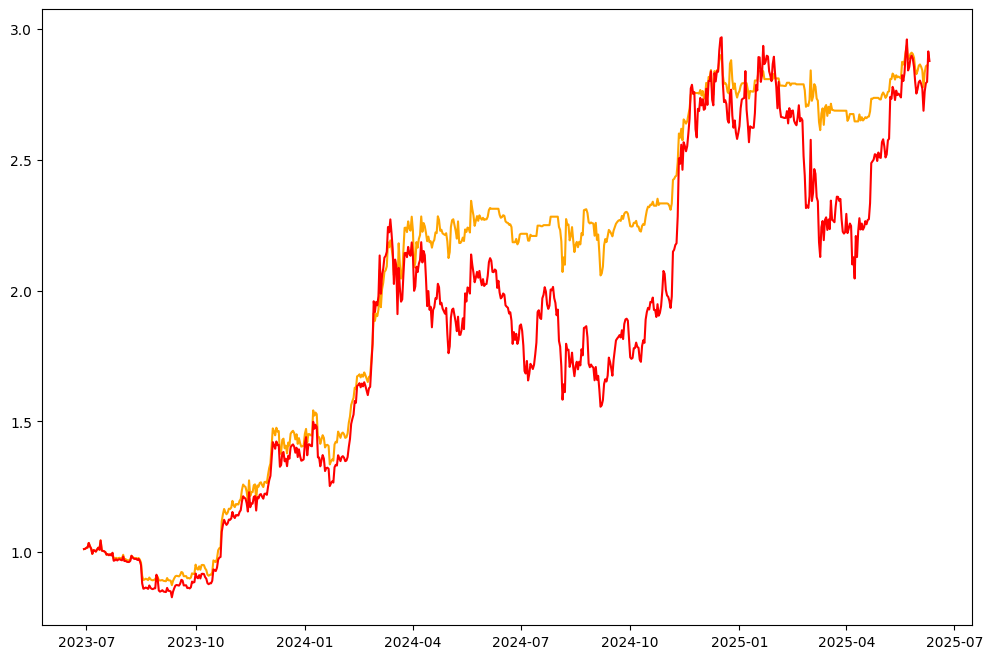

In [136]:
plt.figure(figsize=(12,8))

plt.plot(cum_strat.index,cum_strat.values,'orange')

plt.plot(cum_bench.index,cum_bench.values,'red')


In [77]:
from uptrend_detector import detect_uptrend

uptrend = detect_uptrend(enhanced_master_df['btc_close'])

In [59]:
for col in prediction_df.columns:
    for i in range(len(prediction_df)):
        if uptrend.iloc[i] == 1 and prediction_df[col].iloc[i] == 1:
            prediction_df[col].iloc[i] == 0

In [149]:
wierd_stuff = (final_binary_exit *  uptrend)

'''for i in range(len(wierd_stuff)):
    if wierd_stuff.iloc[i] != 0 or wierd_stuff.iloc[i] != 1:
        if wierd_stuff.iloc[i] > 1:
            wierd_stuff.iloc[i] -= 1'''

'for i in range(len(wierd_stuff)):\n    if wierd_stuff.iloc[i] != 0 or wierd_stuff.iloc[i] != 1:\n        if wierd_stuff.iloc[i] > 1:\n            wierd_stuff.iloc[i] -= 1'

In [150]:
wierd_stuff.value_counts()

0.000000    1424
1.000000     429
0.666667     257
0.333333     138
Name: count, dtype: int64

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import accuracy_score, classification_report, precision_score,recall_score
import xgboost as xgb
import matplotlib.pyplot as plt
import warnings
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline as ImbPipeline
# =============================================================================
# MODIFIED ORIGINAL CELL - Added Precision Outputs
# =============================================================================
warnings.filterwarnings('ignore', category=UserWarning, message='.*Precision is ill-defined.*')

def create_balanced_data(X, y, strategy='moderate'):
    """Create balanced training data"""
    
    if strategy == 'aggressive':
        # Increase minority class to 30% of majority
        smote = SMOTE(sampling_strategy=0.3, random_state=42)
    elif strategy == 'moderate':
        # Increase minority class to 20% of majority  
        smote = SMOTE(sampling_strategy=0.2, random_state=42)
    else:  # conservative
        # Increase minority class to 15% of majority
        smote = SMOTE(sampling_strategy=0.15, random_state=42)
    
    X_balanced, y_balanced = smote.fit_resample(X, y)
    
    print(f"Original distribution: {np.bincount(y)}")
    print(f"Balanced distribution: {np.bincount(y_balanced)}")
    
    return X_balanced, y_balanced

print("\n" + "="*50)
print("LOGISTIC REGRESSION & RANDOM FOREST WITH PRECISION")
print("="*50)

# Multiple feature selection methods
print("Feature Selection Methods:")

# Method 1: F-classif (ANOVA F-test)
selector_f = SelectKBest(score_func=f_classif, k=15)
X_selected_f = selector_f.fit_transform(enhanced_master_df[features_7d], target)
selected_features_f = selector_f.get_support(indices=True)
print(f"F-classif selected features: {selected_features_f}")

# Method 2: Mutual Information
selector_mi = SelectKBest(score_func=mutual_info_classif, k=30)
X_selected_mi = selector_mi.fit_transform(enhanced_master_df[features_30d], target)
selected_features_mi = selector_mi.get_support(indices=True)
print(f"Mutual Info selected features: {selected_features_mi}")

# Choose the best performing method (using F-classif for consistency)
X_selected = X_selected_mi
selected_features = selected_features_mi

# Time Series Split for validation
tscv = TimeSeriesSplit(n_splits=10)

# Split data chronologically (last 30% as test)
split_idx = int(0.7 * len(target))
X_train = X_selected[:split_idx]
X_test = X_selected[split_idx:]
y_train = target.iloc[:split_idx]
y_test = target.iloc[split_idx:]

X_train_orig, y_train_orig = X_train, y_train

X_train, y_train = create_balanced_data(X_train,y_train,strategy='aggressive')

# Grid Search parameters
lr_param_grid = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [10,20,30]
}

# Logistic Regression with GridSearch
print("\nLogistic Regression with GridSearch:")
lr_grid_search = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid=lr_param_grid,
    cv=tscv,
    scoring='precision_weighted',
    n_jobs=-1
)
lr_grid_search.fit(X_train, y_train)
lr_model = lr_grid_search.best_estimator_

print(f"  Best parameters: {lr_grid_search.best_params_}")
print(f"  Best CV precision: {lr_grid_search.best_score_:.4f}")

# In-sample predictions
y_train_pred_lr = lr_model.predict(X_train_orig)
lr_precision_train = precision_score(y_train_orig, y_train_pred_lr, average='weighted',zero_division=0)
cr_train_lr = classification_report(y_train_orig, y_train_pred_lr)

# Out-of-sample predictions
y_test_pred_lr = lr_model.predict(X_test)
lr_precision_test = precision_score(y_test, y_test_pred_lr, average='weighted',zero_division=0)
cr_ter_lr = classification_report(y_test, y_test_pred_lr)

print(f"  In-sample Precision: {lr_precision_train:.4f}")
print(f"  Out-of-sample Precision: {lr_precision_test:.4f}")

# Feature importance (coefficients)
lr_feature_importance = np.abs(lr_model.coef_[0])
print(f"  Feature Importance (top 5):")
top_indices = np.argsort(lr_feature_importance)[::-1][:10]
for i, idx in enumerate(top_indices):
    original_idx = selected_features[idx]
    print(f"    Feature {original_idx}: {lr_feature_importance[idx]:.4f}")

# Random Forest with GridSearch
print("\nRandom Forest with GridSearch:")
rf_grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    cv=tscv,
    scoring='precision_weighted',
    n_jobs=-1
)
rf_grid_search.fit(X_train, y_train)
rf_model = rf_grid_search.best_estimator_

print(f"  Best parameters: {rf_grid_search.best_params_}")
print(f"  Best CV precision: {rf_grid_search.best_score_:.4f}")

# In-sample predictions
y_train_pred_rf = rf_model.predict(X_train)
rf_precision_train = precision_score(y_train, y_train_pred_rf, average='weighted',zero_division=0)
cr_train_rf = classification_report(y_train, y_train_pred_rf)

# Out-of-sample predictions
y_test_pred_rf = rf_model.predict(X_test)
rf_precision_test = precision_score(y_test, y_test_pred_rf, average='weighted',zero_division=0)
cr_test_rf = classification_report(y_test, y_test_pred_rf)


print(f"  In-sample Precision: {rf_precision_train:.4f}")
print(f"  Out-of-sample Precision: {rf_precision_test:.4f}")

# Feature importance
rf_feature_importance = rf_model.feature_importances_
print(f"  Feature Importance (top 5):")
top_indices = np.argsort(rf_feature_importance)[::-1][:10]
for i, idx in enumerate(top_indices):
    original_idx = selected_features[idx]
    print(f"    Feature {original_idx}: {rf_feature_importance[idx]:.4f}")


LOGISTIC REGRESSION & RANDOM FOREST WITH PRECISION
Feature Selection Methods:
F-classif selected features: [ 5  7  8 12 13 16 22 38 39 45 69 71 74 77 78]
Mutual Info selected features: [  3   4   7  13  18  27  50  64  65  66  67  68  69  70  71  72  83  84
  85  86  87  88  89  90  91  92  93  94  99 146]
Original distribution: [1220  365]
Balanced distribution: [1220  366]

Logistic Regression with GridSearch:
  Best parameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
  Best CV precision: 0.7027
  In-sample Precision: 0.8373
  Out-of-sample Precision: 0.8311
  Feature Importance (top 5):
    Feature 7: 7.9188
    Feature 93: 7.0410
    Feature 18: 1.2672
    Feature 3: 0.8516
    Feature 99: 0.2139
    Feature 50: 0.1015
    Feature 146: 0.0607
    Feature 71: 0.0496
    Feature 72: 0.0443
    Feature 27: 0.0063

Random Forest with GridSearch:
  Best parameters: {'max_depth': 20, 'min_samples_split': 20, 'n_estimators': 200}
  Best CV precision: 0.7392
  In-sample Precisi

In [93]:
target.value_counts()

0    938
1     81
Name: count, dtype: int64

In [91]:
result_exit.value_counts()

1    839
0    180
Name: count, dtype: int64

<Axes: xlabel='Date'>

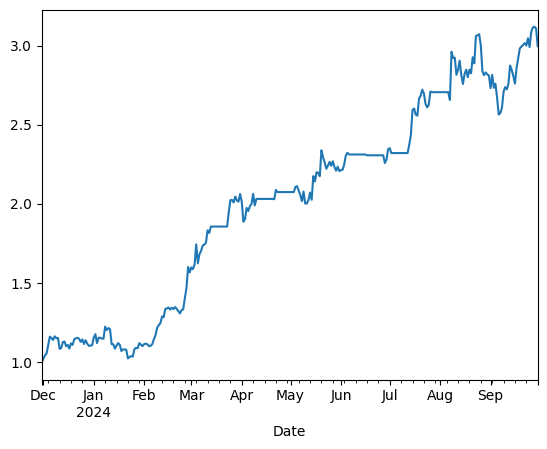

In [92]:
ret = master_df.btc_log_return.loc['2023-11-30':] * result_exit.loc['2023-11-30':]
(ret + 1).cumprod().plot()

<Axes: xlabel='Date'>

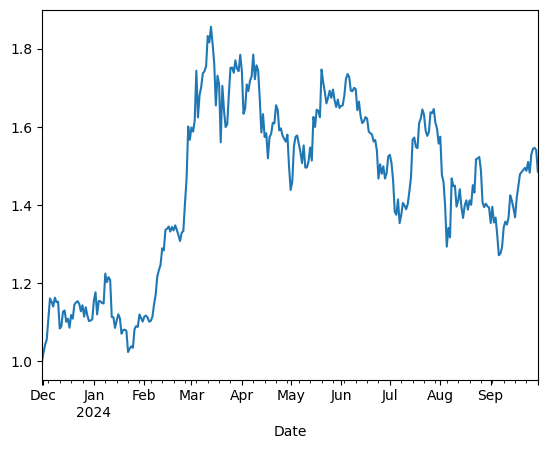

In [89]:
(master_df.btc_log_return.loc['2023-11-30':] + 1).cumprod().plot()

In [94]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("="*60)
print("ENSEMBLE PREDICTIONS")
print("="*60)

# Get predictions from both best models on the test set
lr_pred = lr_grid_search.best_estimator_.predict(X_selected[split_idx:])
rf_pred = rf_grid_search.best_estimator_.predict(X_selected[split_idx:])

# Get prediction probabilities (for weighted ensemble)
lr_proba = lr_grid_search.best_estimator_.predict_proba(X_selected[split_idx:])
rf_proba = rf_grid_search.best_estimator_.predict_proba(X_selected[split_idx:])

print(f"Test set size: {len(y_test)}")
print(f"LR predictions shape: {lr_pred.shape}")
print(f"RF predictions shape: {rf_pred.shape}")

# =============================================================================
# Method 1: Simple Voting (Hard Voting)
# =============================================================================
print(f"\nMETHOD 1: SIMPLE VOTING")
print("-" * 30)

# Simple majority vote
ensemble_vote = np.where(lr_pred + rf_pred >= 1, 1, 0)
vote_accuracy = accuracy_score(y_test, ensemble_vote)

print(f"Voting ensemble accuracy: {vote_accuracy:.4f}")

# =============================================================================
# Method 2: Weighted Voting (Soft Voting)
# =============================================================================
print(f"\nMETHOD 2: WEIGHTED VOTING")
print("-" * 30)

# Weight by CV performance
lr_weight = lr_grid_search.best_score_
rf_weight = rf_grid_search.best_score_
total_weight = lr_weight + rf_weight

# Normalize weights
lr_norm_weight = lr_weight / total_weight
rf_norm_weight = rf_weight / total_weight

print(f"LR weight: {lr_norm_weight:.3f} (CV score: {lr_weight:.3f})")
print(f"RF weight: {rf_norm_weight:.3f} (CV score: {rf_weight:.3f})")

# Weighted average of probabilities
ensemble_proba = (lr_norm_weight * lr_proba + rf_norm_weight * rf_proba)
ensemble_weighted = np.argmax(ensemble_proba, axis=1)
weighted_accuracy = accuracy_score(y_test, ensemble_weighted)

print(f"Weighted ensemble accuracy: {weighted_accuracy:.4f}")

# =============================================================================
# Method 3: Confidence-Based Ensemble
# =============================================================================
print(f"\nMETHOD 3: CONFIDENCE-BASED ENSEMBLE")
print("-" * 30)

# Use the model with higher confidence for each prediction
lr_confidence = np.max(lr_proba, axis=1)
rf_confidence = np.max(rf_proba, axis=1)

# Choose prediction from more confident model
ensemble_confidence = np.where(lr_confidence >= rf_confidence, lr_pred, rf_pred)
confidence_accuracy = accuracy_score(y_test, ensemble_confidence)

print(f"Confidence-based ensemble accuracy: {confidence_accuracy:.4f}")
print(f"Times LR was more confident: {np.sum(lr_confidence >= rf_confidence)}")
print(f"Times RF was more confident: {np.sum(rf_confidence > lr_confidence)}")

# =============================================================================
# Combine Test and Validation Predictions
# =============================================================================
print(f"\nCOMBINE TEST AND VALIDATION PREDICTIONS")
print("-" * 50)

# Get predictions on the entire selected dataset (both train and test portions)
lr_all_pred = lr_grid_search.best_estimator_.predict(X_selected)
rf_all_pred = rf_grid_search.best_estimator_.predict(X_selected)
lr_all_proba = lr_grid_search.best_estimator_.predict_proba(X_selected)
rf_all_proba = rf_grid_search.best_estimator_.predict_proba(X_selected)

# Create ensemble predictions for entire dataset
ensemble_all_vote = np.where(lr_all_pred + rf_all_pred >= 1, 1, 0)
ensemble_all_weighted = np.argmax(lr_norm_weight * lr_all_proba + rf_norm_weight * rf_all_proba, axis=1)

lr_all_confidence = np.max(lr_all_proba, axis=1)
rf_all_confidence = np.max(rf_all_proba, axis=1)
ensemble_all_confidence = np.where(lr_all_confidence >= rf_all_confidence, lr_all_pred, rf_all_pred)

# Create results DataFrame
results_df_signals = pd.DataFrame({
    'actual': target.values,
    'lr_pred': lr_all_pred,
    'rf_pred': rf_all_pred,
    'ensemble_vote': ensemble_all_vote,
    'ensemble_weighted': ensemble_all_weighted,
    'ensemble_confidence': ensemble_all_confidence,
    'lr_confidence': lr_all_confidence,
    'rf_confidence': rf_all_confidence,
    'split': ['train'] * split_idx + ['test'] * (len(target) - split_idx)
},index=master_df.index)

print(f"Combined dataset shape: {results_df_signals.shape}")
print(f"Train samples: {np.sum(results_df_signals['split'] == 'train')}")
print(f"Test samples: {np.sum(results_df_signals['split'] == 'test')}")

ENSEMBLE PREDICTIONS
Test set size: 306
LR predictions shape: (306,)
RF predictions shape: (306,)

METHOD 1: SIMPLE VOTING
------------------------------
Voting ensemble accuracy: 0.7843

METHOD 2: WEIGHTED VOTING
------------------------------
LR weight: 0.475 (CV score: 0.812)
RF weight: 0.525 (CV score: 0.897)
Weighted ensemble accuracy: 0.8856

METHOD 3: CONFIDENCE-BASED ENSEMBLE
------------------------------
Confidence-based ensemble accuracy: 0.8987
Times LR was more confident: 160
Times RF was more confident: 146

COMBINE TEST AND VALIDATION PREDICTIONS
--------------------------------------------------
Combined dataset shape: (1019, 9)
Train samples: 713
Test samples: 306


In [150]:
results_df_signals[results_df_signals['split'] == 'test']

,actual,lr_pred,rf_pred,ensemble_vote,ensemble_weighted,ensemble_confidence,lr_confidence,rf_confidence,split
Date,,,,,,,,,
2023-11-30,0,0,0,0,0,0,0.942299,0.995000,test
2023-12-01,0,0,0,0,0,0,0.940548,1.000000,test
2023-12-02,0,0,0,0,0,0,0.936939,1.000000,test
2023-12-03,0,0,0,0,0,0,0.934768,1.000000,test
2023-12-04,0,0,0,0,0,0,0.911473,1.000000,test
...,...,...,...,...,...,...,...,...,...
2024-09-26,0,0,0,0,0,0,0.514925,0.711743,test
2024-09-27,0,0,0,0,0,0,0.516955,0.741743,test
2024-09-28,0,0,0,0,0,0,0.516343,0.716743,test


In [136]:
def exit_signals_creater(signals:pd.Series):
    counter = 0
    result_exit = []
    for i in range(len(target)):
        if target.iloc[i] == 1 and counter == 0:
            counter = 30
            result_exit.append(1)
            continue
        if counter != 0:
            counter -= 1
            result_exit.append(0)
        elif counter == 0:
            result_exit.append(1)
    result_exit = pd.Series(result_exit,index=target.index) 
    return result_exit

In [137]:
exit_sginals = pd.DataFrame()
for col in results_df_signals.columns:
    if col == 'split':
        continue
    if col =='lr_confidence' or col == 'rf_confidence':
        retss = results_df_signals[col] * master_df.btc_log_return 
        exit_sginals[col] = (retss + 1).cumprod()
    else:
        retss = exit_signals_creater(results_df_signals[col])*master_df.btc_log_return 
        exit_sginals[col] = (retss + 1).cumprod()
exit_sginals.index = master_df.index

<Axes: xlabel='Date'>

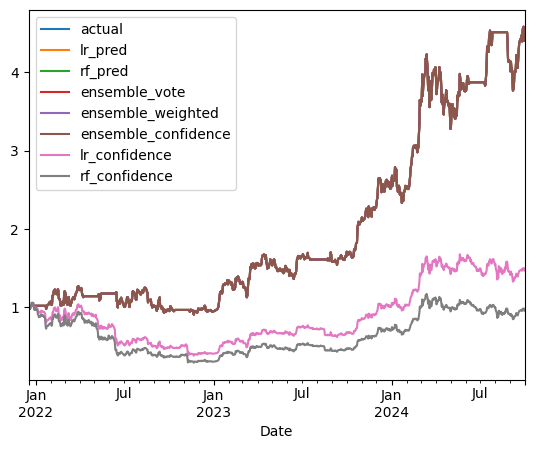

In [146]:
exit_sginals.plot()

<Axes: xlabel='Date'>

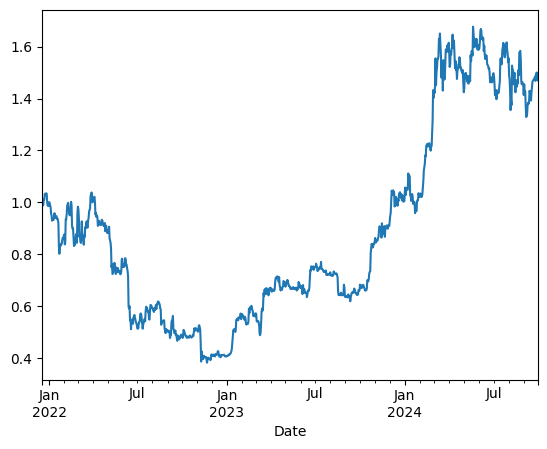

In [145]:
test = results_df_signals.lr_confidence * master_df.btc_log_return
(test + 1).cumprod().plot()

## Step 6: Add date features for analysis

In [ ]:
# Date components
master_df['year'] = master_df.index.year
master_df['month'] = master_df.index.month
master_df['day'] = master_df.index.day
master_df['weekday'] = master_df.index.weekday
master_df['week_of_year'] = master_df.index.isocalendar().week
master_df['is_weekend'] = (master_df['weekday'] >= 5).astype(int)
master_df['is_month_end'] = master_df.index.is_month_end.astype(int)
master_df['is_quarter_end'] = master_df.index.is_quarter_end.astype(int)

## Step 7: Save the organized data

In [ ]:
# Save full dataset
master_df.to_csv('bitcoin_master_data_complete.csv')
print(f"Saved full dataset: {master_df.shape}")

# Save clean dataset (no NaN in key columns)
key_columns = ['btc_close', 'btc_return', 'rolling_vol_7d', 'rolling_vol_30d', 
               'rolling_skew_30d', 'skew_index']
clean_df = master_df.dropna(subset=[col for col in key_columns if col in master_df.columns])
clean_df.to_csv('bitcoin_master_data_clean.csv')
print(f"Saved clean dataset: {clean_df.shape}")

## Step 8: Display summary statistics

In [ ]:
# Summary statistics
print("=== Data Summary ===")
print(f"Date range: {master_df.index.min()} to {master_df.index.max()}")
print(f"Total days: {len(master_df)}")
print(f"Total columns: {len(master_df.columns)}")

# Key metrics summary
summary_cols = ['btc_close', 'btc_return', 'rolling_vol_30d', 'rolling_skew_30d']
if 'skew_index' in master_df.columns:
    summary_cols.append('skew_index')

print("\n=== Key Metrics Summary ===")
print(master_df[summary_cols].describe())

# Missing values
print("\n=== Missing Values ===")
missing = master_df[summary_cols].isna().sum()
print(missing[missing > 0])

# Correlations
print("\n=== Correlations ===")
print(master_df[summary_cols].corr())

## Step 9: Quick visualization

In [ ]:
# Create subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Bitcoin price
axes[0].plot(master_df.index, master_df['btc_close'])
axes[0].set_ylabel('BTC Price ($)')
axes[0].set_title('Bitcoin Price and Risk Metrics')
axes[0].grid(True, alpha=0.3)

# Rolling volatility
axes[1].plot(master_df.index, master_df['rolling_vol_30d'])
axes[1].set_ylabel('30-day Vol (ann.)')
axes[1].grid(True, alpha=0.3)

# Rolling skewness
axes[2].plot(master_df.index, master_df['rolling_skew_30d'])
axes[2].set_ylabel('30-day Skew')
axes[2].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[2].grid(True, alpha=0.3)

# SKEW index
if 'skew_index' in master_df.columns:
    axes[3].plot(master_df.index, master_df['skew_index'])
    axes[3].set_ylabel('SKEW Index')
    axes[3].axhline(y=100, color='r', linestyle='--', alpha=0.5)
    axes[3].axhline(y=120, color='orange', linestyle='--', alpha=0.5)
    axes[3].axhline(y=130, color='red', linestyle='--', alpha=0.5)
else:
    axes[3].text(0.5, 0.5, 'SKEW Index not available', 
                 ha='center', va='center', transform=axes[3].transAxes)

axes[3].set_xlabel('Date')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display the final DataFrame
print("\n=== Master DataFrame Preview ===")
print(master_df.head())
print("\n=== Available Columns ===")
print(sorted(master_df.columns.tolist()))